# Install extra dependencies

In [ ]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=bc26e71003b3a8409e0d7fe9a84d5361b07efe0a6fc189637d0af191a8b7535f
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import dependencies

In [ ]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import gc
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from vit_pytorch import ViT
from math import sqrt
import torch
from torch.utils.tensorboard import SummaryWriter
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
from sklearn.metrics import roc_curve, auc

import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchsummary import summary
import torch.nn as nn
import psutil
import time

from torchviz import make_dot

from einops import rearrange
from einops.layers.torch import Rearrange
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

# Setup PyTorch Dataset
This notebook was tested with colab ( all the data is taken from google drive and run on colab GPU)



In [ ]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

model_save_folder = os.path.join(data_filepath, "models")
tensorboard_save_folder = os.path.join(data_filepath, "tensorboard")

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

electronX, electronY = np.array(electronFile.get("X")), np.array(electronFile.get('y'))
photonX, photonY     = np.array(photonFile.get("X")),   np.array(photonFile.get('y'))

mean_electron = np.mean(electronX.reshape(-1, 2), axis=0)
std_electron  = np.std(electronX.reshape(-1, 2), axis=0)
electronX = (electronX - mean_electron) / std_electron

mean_photon   = np.mean(photonX.reshape(-1, 2), axis=0)
std_photon    = np.std(photonX.reshape(-1, 2), axis=0)
photonX = (photonX - mean_electron) / std_electron

## Pytorch Dataset

In [ ]:
class PhotonElectronDataset(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            image = photonX[self.photon_indexes[idx // 2], :, :, :]
            label = photonY[self.photon_indexes[idx // 2]]
        # electron if odd
        else:
            image = electronX[self.electron_indexes[idx // 2], :, :, :]
            label = electronY[self.electron_indexes[idx // 2]]

        if self.transform:
            image = self.transform(image)
        return image, label


## Pytorch dataset from ensemble models

In [ ]:
import random 

class PhotonElectronDatasetWithReplacement(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            val_idx = random.randint(0, len(self.photon_indexes)-1)
            image = photonX[self.photon_indexes[val_idx], :, :, :]
            label = photonY[self.photon_indexes[val_idx]]
        # electron if odd
        else:
            val_idx = random.randint(0, len(self.electron_indexes)-1)
            image = electronX[self.electron_indexes[val_idx], :, :, :]
            label = electronY[self.electron_indexes[val_idx]]

        if self.transform:
            image = self.transform(image)
        return image, label

## Create the datasets
and do some little EDA 

In [ ]:
# Train, valid split ( validation is final metric how well the model is performing)
train_size = 0.9
validation_size = 0.1

# Batch Size
batch_size = 64


# size of datasets
nElectronImgs = len(electronFile["X"])
nPhotonImgs = len(photonFile['y'])

# randomize the indices to choose from
electrons_idxs = np.arange(0, nElectronImgs)
np.random.shuffle(electrons_idxs)
photon_idxs = np.arange(0, nPhotonImgs)
np.random.shuffle(photon_idxs)

# Do the split
electron_training_idxs   = electrons_idxs[0: int(train_size * nElectronImgs)]
electron_validation_idxs = electrons_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]

photon_training_idxs   = photon_idxs[0: int(train_size * nElectronImgs)]
photon_validation_idxs = photon_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]

# Create the normal datasets
train_ds = PhotonElectronDataset(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
val_ds  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))

# Record the sizes
training_ds_size = len(train_ds)
validation_ds_size = len(val_ds)

# Print the sizes
print(f"training size : {training_ds_size}")
print(f"validation size : {validation_ds_size}")

# Create the dataloader
train_dl      = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

### Visualize few images from batch

In [ ]:
train_features, train_labels = next(iter(train_dl))
label_val_to_text = {1 : "Electron", 0 : "Photon"}

scale = 5
n = int(batch_size)
to_plot = 5
plt.figure(figsize=(2*scale , scale * to_plot))


for y in range(to_plot):
  plt.subplot(to_plot, 2, 2 * y + 1)
  label = label_val_to_text[train_labels[y].item()]
  plt.title(f"label={label} : energy")
  plt.imshow(train_features[y, 0, :, :], cmap='gray')

  plt.subplot(to_plot, 2, 2 * y + 2)
  plt.title(f"label={label} : time")
  plt.imshow(train_features[y, 1, :, :], cmap='gray')


plt.show()

# PyTorch Training/Eval Functions

## Evaluate Model 
take a model, dataloader and size of dataset and report final metrics (accuracy and AUC )

In [ ]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = F.binary_cross_entropy

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            pred_labels = (outputs >= 0.5).reshape(-1)
            # probs, preds = torch.max(outputs, 1)
  
            loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))
            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  
    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')
    return {"loss" : epoch_loss, "accuracy" : epoch_acc.item(), "AUC_ROC" : AUC_ROC}

## Train Model

In [ ]:
def training_epoch(model, optimizer, scheduler, 
                   train_dataloader, train_dataset_size,
                   valid_dataloader, valid_dataset_size, 
                   num_epochs=25, update_every=5,
                   clean_every = 10,
                   save_path=os.path.join(model_save_folder, 'model_AUC={}.pth')):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : [],
                  "validationLoss" : [], "validationAccuracy" : [], "validationAUC" : []}
    best_model_wts = copy.deepcopy(model)
    best_acc = 0.0
    criterion = F.binary_cross_entropy
    best_AUC_score = 0
    model_best = copy.deepcopy(model)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()

        i = 0
        samples_so_far = 0
        # Iterate over data.
        progress_bar = tqdm(train_dataloader)
        for inputs, labels in progress_bar:
            i += 1
            samples_so_far += inputs.shape[0]
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                pred_labels = (outputs >= 0.5).reshape(-1)

                loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))
                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)

            if i % update_every == 0:
                rl_avg = running_loss / samples_so_far
                acc_avg = running_corrects / samples_so_far
                AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy()) 

                progress_bar.set_description(f"loss = {rl_avg}, accuracy : {acc_avg}, AUC ROC {AUC_ROC}")
            
            if clean_every != -1 and i % clean_every == 0:
                gc.collect()

            scheduler.step()
            
        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy()) 

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'TRAINING ; Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        eval_result = evaluate_model(model, valid_dataloader, valid_dataset_size)

        returnDict["validationLoss"].append(eval_result["loss"])
        returnDict["validationAccuracy"].append(eval_result["accuracy"])
        returnDict["validationAUC"].append(eval_result["AUC_ROC"])

        if eval_result["AUC_ROC"] > best_AUC_score:
          best_AUC_score = eval_result["AUC_ROC"]
          model_best = copy.deepcopy(model)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model_best
    torch.save(model_best, save_path.format(round(best_AUC_score, 3)))
    return returnDict

## Plot the results

In [ ]:
def plotResults(results):
    global val_dl, val_ds

    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()
    plt.show()

    model = results["best_model"]
    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    y = []
    pred_y = []

    with torch.set_grad_enabled(False):
      # Iterate over data.
      for inputs, labels in tqdm(val_dl):
          inputs = inputs.to(device).float()
          labels = labels.to(device)
          labels = labels.long()
          y.extend(labels.cpu())
          
          # forward
          outputs = model(inputs)

          pred_y.extend(outputs.cpu())
      
    fpr, thr, threshold = roc_curve(y, pred_y)
    plt.figure(figsize=(8,8))
    plt.title(f"ROC curve (AUC ROC = {round(roc_auc_score(y, pred_y), 3)})")
    plt.plot(fpr, thr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()


## Do Experiment
train a model for a given number of epochs, with Adam optimizer with set learning rate


In [ ]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, 
                 _summary=True, input_size=(3,32,32),
                 clean_every=100, nameOfModel="model_AUC={}.pth"):
  global train_dl, train_ds, val_dl, val_ds
  if _summary:
    print(summary(model_ft, input_size=input_size, device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.CyclicLR(optim, learning_rate, 5 * learning_rate,
                                      step_size_up = len(train_dl), cycle_momentum=False)

  dats = training_epoch(model_ft, optim, lr_sched, 
                        train_dl,  len(train_ds) , 
                        val_dl, len(val_ds),
                        num_epochs=epochs,
                        clean_every=clean_every,
                        save_path=os.path.join(model_save_folder, nameOfModel))
  
  if plot:
    plotResults(dats)
  return dats

# Baseline

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 590,593
Trainable params: 590,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------
None
Epoch 0/9
----------


loss = 0.6242581275488649, accuracy : 0.6587923765182495, AUC ROC 0.7075572933412176: 100%|██████████| 7004/7004 [02:26<00:00, 47.90it/s]


TRAINING ; Loss: 0.6243 Acc: 0.6588 AUC ROC : 0.7076 Time taken : 146.4


100%|██████████| 779/779 [00:01<00:00, 438.29it/s]


VALIDATION : Loss: 0.6110 Acc: 0.6741 AUC ROC : 0.7279 Time taken : 1.8
Epoch 1/9
----------


loss = 0.5889077739204679, accuracy : 0.6976629495620728, AUC ROC 0.7520422160210761: 100%|██████████| 7004/7004 [02:26<00:00, 47.79it/s]


TRAINING ; Loss: 0.5889 Acc: 0.6977 AUC ROC : 0.7521 Time taken : 146.79


100%|██████████| 779/779 [00:01<00:00, 394.27it/s]


VALIDATION : Loss: 0.5836 Acc: 0.7032 AUC ROC : 0.7589 Time taken : 2.0
Epoch 2/9
----------


loss = 0.5731708145482199, accuracy : 0.7112611532211304, AUC ROC 0.7694953238765372: 100%|██████████| 7004/7004 [02:23<00:00, 48.66it/s]


TRAINING ; Loss: 0.5732 Acc: 0.7112 AUC ROC : 0.7695 Time taken : 144.17


100%|██████████| 779/779 [00:01<00:00, 418.09it/s]


VALIDATION : Loss: 0.5959 Acc: 0.6919 AUC ROC : 0.7486 Time taken : 1.89
Epoch 3/9
----------


loss = 0.5702366921007633, accuracy : 0.7125714421272278, AUC ROC 0.7727739392502363: 100%|██████████| 7004/7004 [02:22<00:00, 49.07it/s]


TRAINING ; Loss: 0.5702 Acc: 0.7126 AUC ROC : 0.7728 Time taken : 142.96


100%|██████████| 779/779 [00:01<00:00, 422.56it/s]


VALIDATION : Loss: 0.5787 Acc: 0.7084 AUC ROC : 0.7648 Time taken : 1.87
Epoch 4/9
----------


loss = 0.5541050927426134, accuracy : 0.723850429058075, AUC ROC 0.7884992203899972: 100%|██████████| 7004/7004 [02:25<00:00, 47.98it/s]


TRAINING ; Loss: 0.5541 Acc: 0.7238 AUC ROC : 0.7885 Time taken : 146.18


100%|██████████| 779/779 [00:01<00:00, 414.32it/s]


VALIDATION : Loss: 0.5919 Acc: 0.6977 AUC ROC : 0.7547 Time taken : 1.9
Epoch 5/9
----------


loss = 0.553805222856147, accuracy : 0.724040150642395, AUC ROC 0.788961993853845: 100%|██████████| 7004/7004 [02:24<00:00, 48.43it/s]


TRAINING ; Loss: 0.5538 Acc: 0.7241 AUC ROC : 0.7890 Time taken : 144.83


100%|██████████| 779/779 [00:01<00:00, 411.53it/s]


VALIDATION : Loss: 0.5910 Acc: 0.7053 AUC ROC : 0.7619 Time taken : 1.92
Epoch 6/9
----------


loss = 0.5354305310845375, accuracy : 0.735205352306366, AUC ROC 0.8048882389387122: 100%|██████████| 7004/7004 [02:24<00:00, 48.51it/s]


TRAINING ; Loss: 0.5355 Acc: 0.7352 AUC ROC : 0.8048 Time taken : 144.61


100%|██████████| 779/779 [00:01<00:00, 412.90it/s]


VALIDATION : Loss: 0.6258 Acc: 0.6964 AUC ROC : 0.7493 Time taken : 1.91
Epoch 7/9
----------


loss = 0.537800299014364, accuracy : 0.7339375019073486, AUC ROC 0.803182834231579: 100%|██████████| 7004/7004 [02:24<00:00, 48.53it/s]


TRAINING ; Loss: 0.5378 Acc: 0.7339 AUC ROC : 0.8032 Time taken : 144.56


100%|██████████| 779/779 [00:01<00:00, 405.38it/s]


VALIDATION : Loss: 0.6055 Acc: 0.7036 AUC ROC : 0.7565 Time taken : 1.94
Epoch 8/9
----------


loss = 0.5190340382031032, accuracy : 0.7446317076683044, AUC ROC 0.8184073453498413: 100%|██████████| 7004/7004 [02:23<00:00, 48.91it/s]


TRAINING ; Loss: 0.5190 Acc: 0.7446 AUC ROC : 0.8184 Time taken : 143.42


100%|██████████| 779/779 [00:01<00:00, 408.14it/s]


VALIDATION : Loss: 0.6242 Acc: 0.6982 AUC ROC : 0.7502 Time taken : 1.93
Epoch 9/9
----------


loss = 0.5231081449559757, accuracy : 0.7423995733261108, AUC ROC 0.8152718565326411: 100%|██████████| 7004/7004 [02:24<00:00, 48.61it/s]


TRAINING ; Loss: 0.5231 Acc: 0.7424 AUC ROC : 0.8153 Time taken : 144.29


100%|██████████| 779/779 [00:01<00:00, 413.39it/s]


VALIDATION : Loss: 0.6394 Acc: 0.7000 AUC ROC : 0.7518 Time taken : 1.91
Training complete in 24m 27s


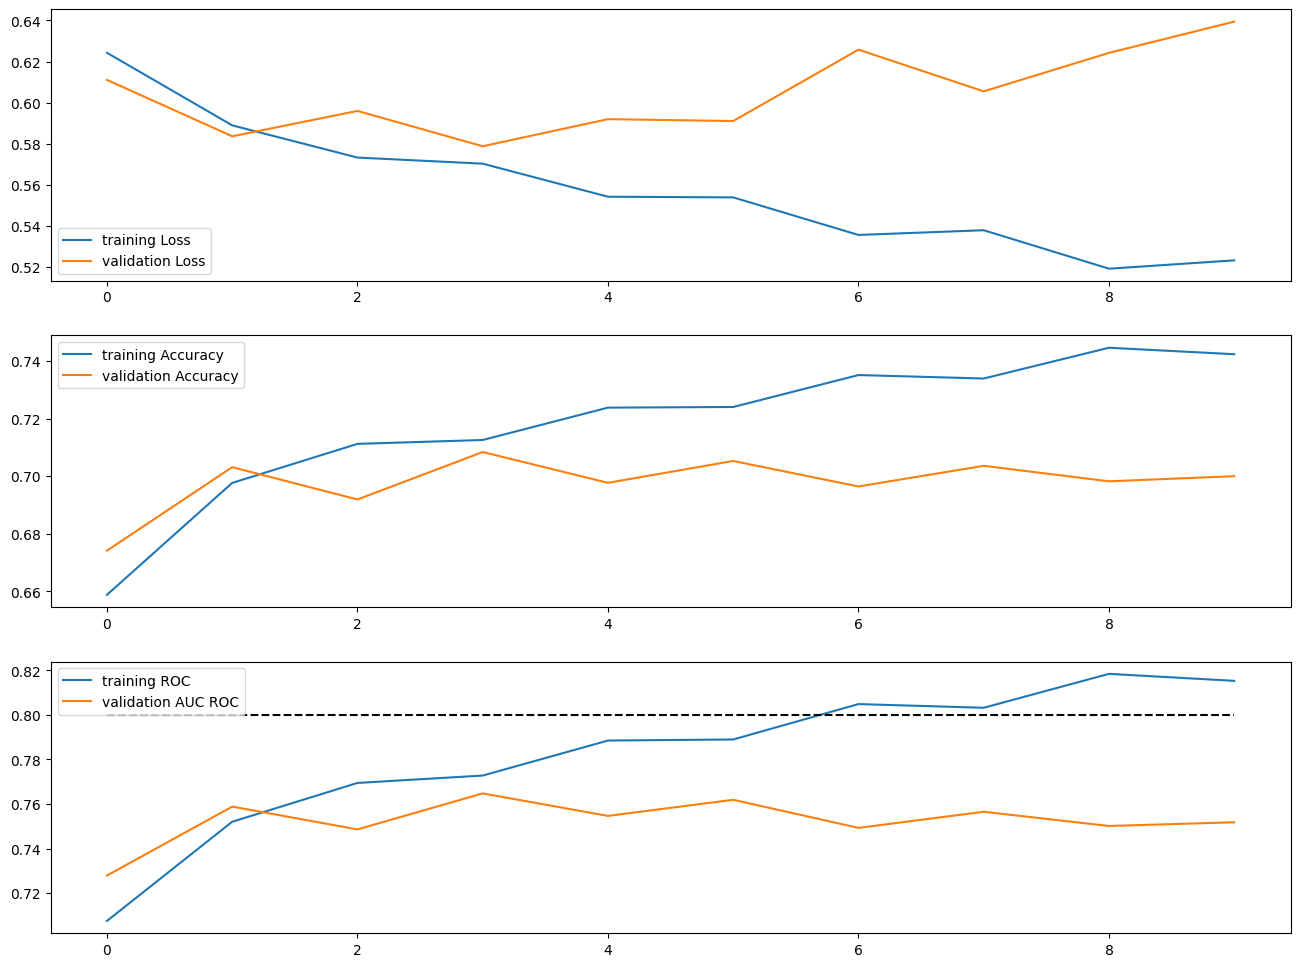

100%|██████████| 779/779 [00:01<00:00, 491.66it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

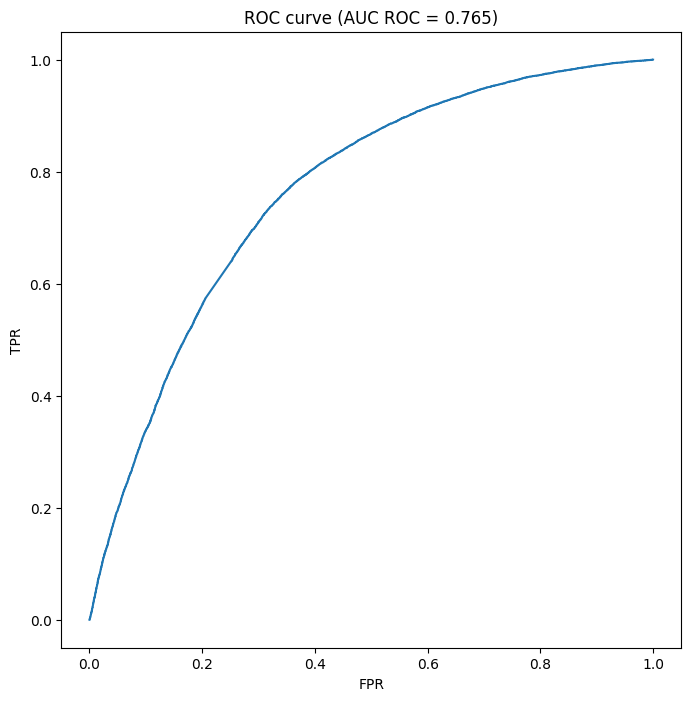

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

MLP_results = doExperiment(BasicNN(), learning_rate=1e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=10,
             nameOfModel="MLP_AUC={}.pth")

# Basic CNN


## Experiment 1 
- architecture simillar to LeNet
- kernel_size = 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 80, 24, 24]          46,080
       BatchNorm2d-8           [-1, 80, 24, 24]             160
         MaxPool2d-9           [-1, 80, 12, 12]               0
           Linear-10                    [-1, 1]          11,520
          Sigmoid-11                    [-1, 1]               0
Total params: 100,096
Trainable params: 100,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

loss = 0.6101693694293499, accuracy : 0.6755714416503906, AUC ROC 0.7292963577954573: 100%|██████████| 7004/7004 [03:32<00:00, 32.89it/s]


TRAINING ; Loss: 0.6101 Acc: 0.6756 AUC ROC : 0.7293 Time taken : 213.19


100%|██████████| 779/779 [00:02<00:00, 261.45it/s]


VALIDATION : Loss: 0.5852 Acc: 0.7012 AUC ROC : 0.7617 Time taken : 3.01
Epoch 1/9
----------


loss = 0.5717425712219306, accuracy : 0.7106718420982361, AUC ROC 0.7719691394779918: 100%|██████████| 7004/7004 [03:27<00:00, 33.82it/s]


TRAINING ; Loss: 0.5717 Acc: 0.7107 AUC ROC : 0.7720 Time taken : 207.77


100%|██████████| 779/779 [00:02<00:00, 286.53it/s]


VALIDATION : Loss: 0.5654 Acc: 0.7155 AUC ROC : 0.7835 Time taken : 2.75
Epoch 2/9
----------


loss = 0.5641510560597692, accuracy : 0.7157433032989502, AUC ROC 0.7797682048977169: 100%|██████████| 7004/7004 [03:26<00:00, 33.88it/s]


TRAINING ; Loss: 0.5642 Acc: 0.7157 AUC ROC : 0.7798 Time taken : 207.38


100%|██████████| 779/779 [00:02<00:00, 268.06it/s]


VALIDATION : Loss: 0.5704 Acc: 0.7146 AUC ROC : 0.7790 Time taken : 2.93
Epoch 3/9
----------


loss = 0.5606091716715268, accuracy : 0.7187566757202148, AUC ROC 0.7832648146563603: 100%|██████████| 7004/7004 [03:28<00:00, 33.63it/s]


TRAINING ; Loss: 0.5606 Acc: 0.7187 AUC ROC : 0.7833 Time taken : 208.96


100%|██████████| 779/779 [00:02<00:00, 279.51it/s]


VALIDATION : Loss: 0.5574 Acc: 0.7208 AUC ROC : 0.7888 Time taken : 2.82
Epoch 4/9
----------


loss = 0.5563893327670438, accuracy : 0.7219442129135132, AUC ROC 0.7873493752709979: 100%|██████████| 7004/7004 [03:28<00:00, 33.53it/s]


TRAINING ; Loss: 0.5564 Acc: 0.7220 AUC ROC : 0.7874 Time taken : 209.52


100%|██████████| 779/779 [00:02<00:00, 271.90it/s]


VALIDATION : Loss: 0.5601 Acc: 0.7185 AUC ROC : 0.7837 Time taken : 2.89
Epoch 5/9
----------


loss = 0.5553163663191455, accuracy : 0.7223839163780212, AUC ROC 0.7883559640333148: 100%|██████████| 7004/7004 [03:29<00:00, 33.48it/s]


TRAINING ; Loss: 0.5553 Acc: 0.7224 AUC ROC : 0.7884 Time taken : 209.88


100%|██████████| 779/779 [00:02<00:00, 275.21it/s]


VALIDATION : Loss: 0.5502 Acc: 0.7272 AUC ROC : 0.7929 Time taken : 2.86
Epoch 6/9
----------


loss = 0.5520100515825408, accuracy : 0.7251227498054504, AUC ROC 0.791547295074661: 100%|██████████| 7004/7004 [03:27<00:00, 33.74it/s]


TRAINING ; Loss: 0.5520 Acc: 0.7251 AUC ROC : 0.7915 Time taken : 208.27


100%|██████████| 779/779 [00:02<00:00, 274.51it/s]


VALIDATION : Loss: 0.5597 Acc: 0.7236 AUC ROC : 0.7863 Time taken : 2.87
Epoch 7/9
----------


loss = 0.5514746850516115, accuracy : 0.7255379557609558, AUC ROC 0.7921048351528408: 100%|██████████| 7004/7004 [03:25<00:00, 34.11it/s]


TRAINING ; Loss: 0.5515 Acc: 0.7255 AUC ROC : 0.7921 Time taken : 206.04


100%|██████████| 779/779 [00:02<00:00, 276.76it/s]


VALIDATION : Loss: 0.5472 Acc: 0.7282 AUC ROC : 0.7965 Time taken : 2.84
Epoch 8/9
----------


loss = 0.548660365496363, accuracy : 0.7271272540092468, AUC ROC 0.7947514268264274: 100%|██████████| 7004/7004 [03:14<00:00, 36.03it/s]


TRAINING ; Loss: 0.5487 Acc: 0.7271 AUC ROC : 0.7947 Time taken : 195.05


100%|██████████| 779/779 [00:02<00:00, 280.86it/s]


VALIDATION : Loss: 0.5545 Acc: 0.7219 AUC ROC : 0.7891 Time taken : 2.8
Epoch 9/9
----------


loss = 0.5482708139078958, accuracy : 0.7283437252044678, AUC ROC 0.795083329881278: 100%|██████████| 7004/7004 [03:14<00:00, 36.05it/s]


TRAINING ; Loss: 0.5483 Acc: 0.7283 AUC ROC : 0.7951 Time taken : 194.96


100%|██████████| 779/779 [00:02<00:00, 288.08it/s]


VALIDATION : Loss: 0.5457 Acc: 0.7303 AUC ROC : 0.7972 Time taken : 2.73
Training complete in 34m 50s


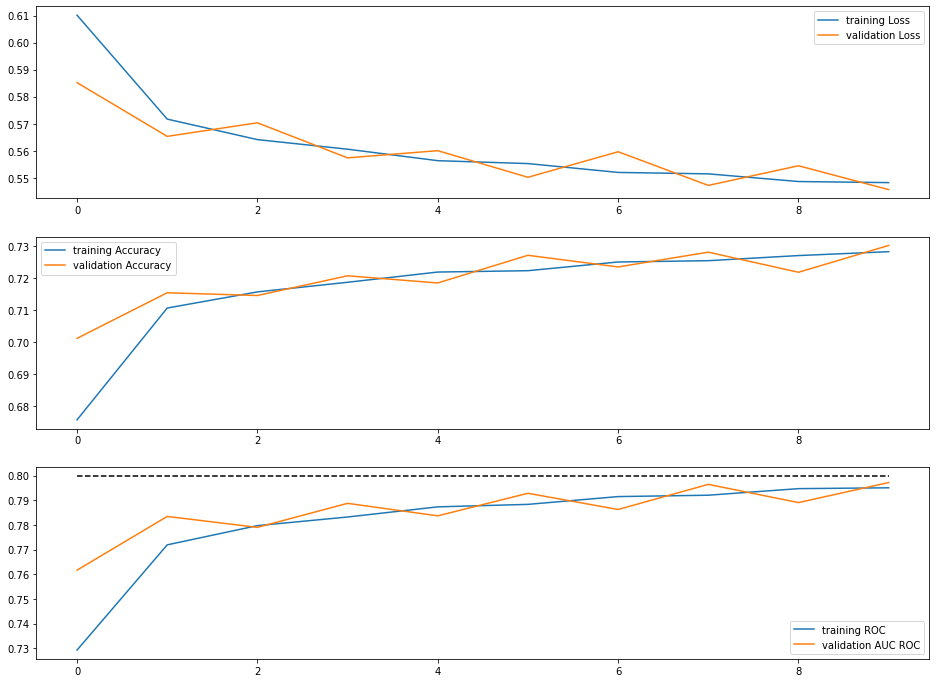

100%|██████████| 779/779 [00:02<00:00, 302.76it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

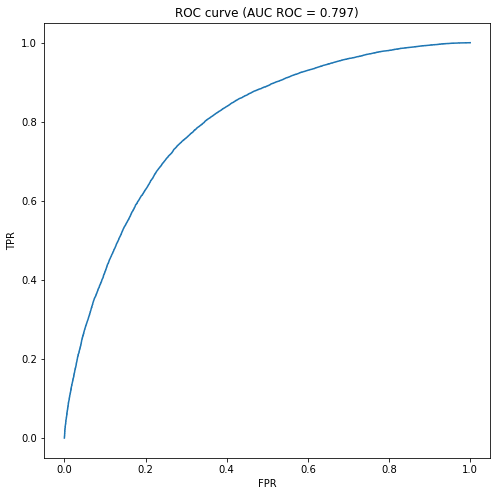

In [ ]:
class CNNSmall1(nn.Module):
    def __init__(self):
        super(CNNSmall1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)
        self.conv4_bn = nn.BatchNorm2d(80)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(11520, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.max_pool(conv4)
        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN1 = doExperiment(CNNSmall1(), learning_rate=1e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=10,
             nameOfModel="CNN_Small1_AUC={}.pth")

## Experiment 2
- LeNet type
- kernel Size 5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,632
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 48, 24, 24]          38,448
       BatchNorm2d-4           [-1, 48, 24, 24]              96
            Conv2d-5           [-1, 64, 20, 20]          76,864
       BatchNorm2d-6           [-1, 64, 20, 20]             128
         MaxPool2d-7           [-1, 64, 10, 10]               0
            Linear-8                    [-1, 1]           6,401
           Sigmoid-9                    [-1, 1]               0
Total params: 123,633
Trainable params: 123,633
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.24
Params size (MB): 0.47
Estimated Total Size (MB): 1.72
-------------------------------------------

loss = 0.6136792371698788, accuracy : 0.6684442162513733, AUC ROC 0.7232769950621277: 100%|██████████| 7004/7004 [03:08<00:00, 37.15it/s]


TRAINING ; Loss: 0.6137 Acc: 0.6685 AUC ROC : 0.7233 Time taken : 188.7


100%|██████████| 779/779 [00:02<00:00, 280.56it/s]


VALIDATION : Loss: 0.6008 Acc: 0.6841 AUC ROC : 0.7658 Time taken : 2.8
Epoch 1/9
----------


loss = 0.5674849775731563, accuracy : 0.713948667049408, AUC ROC 0.7760197724828579: 100%|██████████| 7004/7004 [03:04<00:00, 37.87it/s]


TRAINING ; Loss: 0.5675 Acc: 0.7139 AUC ROC : 0.7760 Time taken : 185.19


100%|██████████| 779/779 [00:02<00:00, 272.89it/s]


VALIDATION : Loss: 0.5543 Acc: 0.7218 AUC ROC : 0.7931 Time taken : 2.88
Epoch 2/9
----------


loss = 0.5584110924346106, accuracy : 0.7208214402198792, AUC ROC 0.785268349136744: 100%|██████████| 7004/7004 [03:03<00:00, 38.19it/s]


TRAINING ; Loss: 0.5584 Acc: 0.7208 AUC ROC : 0.7853 Time taken : 183.67


100%|██████████| 779/779 [00:02<00:00, 272.10it/s]


VALIDATION : Loss: 0.5592 Acc: 0.7188 AUC ROC : 0.7876 Time taken : 2.89
Epoch 3/9
----------


loss = 0.5541643762716225, accuracy : 0.7236517667770386, AUC ROC 0.789393764641613: 100%|██████████| 7004/7004 [03:03<00:00, 38.12it/s]


TRAINING ; Loss: 0.5542 Acc: 0.7237 AUC ROC : 0.7894 Time taken : 183.98


100%|██████████| 779/779 [00:02<00:00, 269.61it/s]


VALIDATION : Loss: 0.5443 Acc: 0.7294 AUC ROC : 0.7984 Time taken : 2.91
Epoch 4/9
----------


loss = 0.54914882383602, accuracy : 0.7275803685188293, AUC ROC 0.7941096686481042: 100%|██████████| 7004/7004 [03:02<00:00, 38.36it/s]


TRAINING ; Loss: 0.5492 Acc: 0.7276 AUC ROC : 0.7941 Time taken : 182.85


100%|██████████| 779/779 [00:02<00:00, 273.15it/s]


VALIDATION : Loss: 0.5598 Acc: 0.7206 AUC ROC : 0.7923 Time taken : 2.88
Epoch 5/9
----------


loss = 0.5480979148490088, accuracy : 0.7284419536590576, AUC ROC 0.7952370309156528: 100%|██████████| 7004/7004 [03:02<00:00, 38.41it/s]


TRAINING ; Loss: 0.5481 Acc: 0.7284 AUC ROC : 0.7952 Time taken : 182.6


100%|██████████| 779/779 [00:03<00:00, 253.23it/s]


VALIDATION : Loss: 0.5424 Acc: 0.7312 AUC ROC : 0.8007 Time taken : 3.1
Epoch 6/9
----------


loss = 0.5433616669390883, accuracy : 0.7315424084663391, AUC ROC 0.7995952608457905: 100%|██████████| 7004/7004 [03:01<00:00, 38.48it/s]


TRAINING ; Loss: 0.5434 Acc: 0.7315 AUC ROC : 0.7996 Time taken : 182.24


100%|██████████| 779/779 [00:02<00:00, 268.33it/s]


VALIDATION : Loss: 0.5508 Acc: 0.7244 AUC ROC : 0.7939 Time taken : 2.93
Epoch 7/9
----------


loss = 0.5436489732137748, accuracy : 0.7314307689666748, AUC ROC 0.7993477075748668: 100%|██████████| 7004/7004 [03:01<00:00, 38.55it/s]


TRAINING ; Loss: 0.5437 Acc: 0.7314 AUC ROC : 0.7993 Time taken : 181.91


100%|██████████| 779/779 [00:02<00:00, 275.72it/s]


VALIDATION : Loss: 0.5406 Acc: 0.7323 AUC ROC : 0.8023 Time taken : 2.85
Epoch 8/9
----------


loss = 0.5389189498126506, accuracy : 0.7347589135169983, AUC ROC 0.803622866644065: 100%|██████████| 7004/7004 [03:05<00:00, 37.72it/s]


TRAINING ; Loss: 0.5389 Acc: 0.7348 AUC ROC : 0.8036 Time taken : 185.95


100%|██████████| 779/779 [00:02<00:00, 273.02it/s]


VALIDATION : Loss: 0.5539 Acc: 0.7227 AUC ROC : 0.7918 Time taken : 2.88
Epoch 9/9
----------


loss = 0.5392777629281793, accuracy : 0.7342432737350464, AUC ROC 0.8033478513403532: 100%|██████████| 7004/7004 [03:05<00:00, 37.83it/s]


TRAINING ; Loss: 0.5393 Acc: 0.7342 AUC ROC : 0.8033 Time taken : 185.41


100%|██████████| 779/779 [00:03<00:00, 256.74it/s]


VALIDATION : Loss: 0.5405 Acc: 0.7319 AUC ROC : 0.8022 Time taken : 3.06
Training complete in 31m 12s


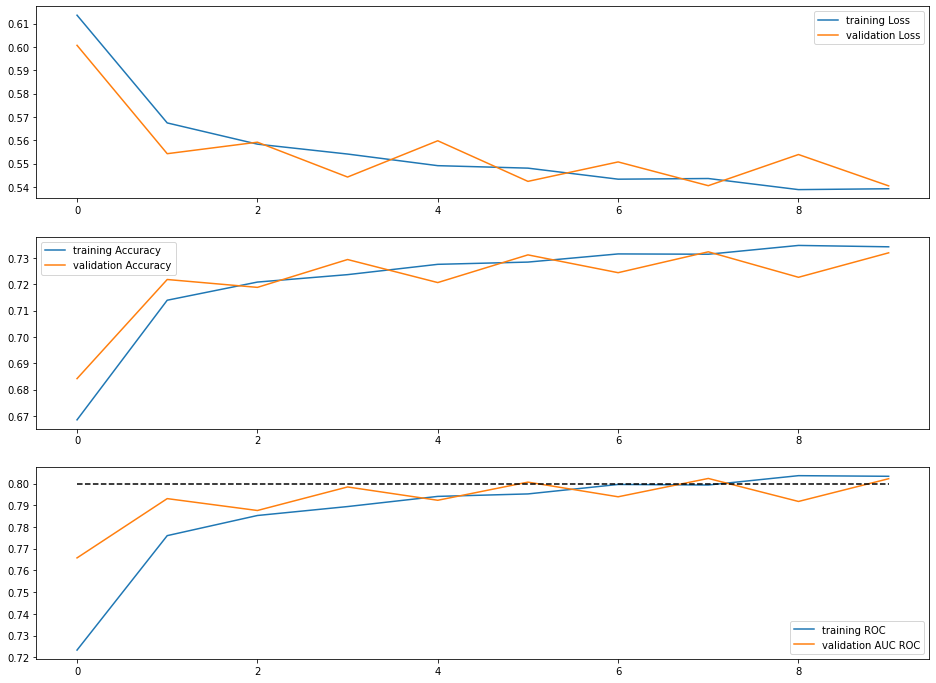

100%|██████████| 779/779 [00:02<00:00, 280.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

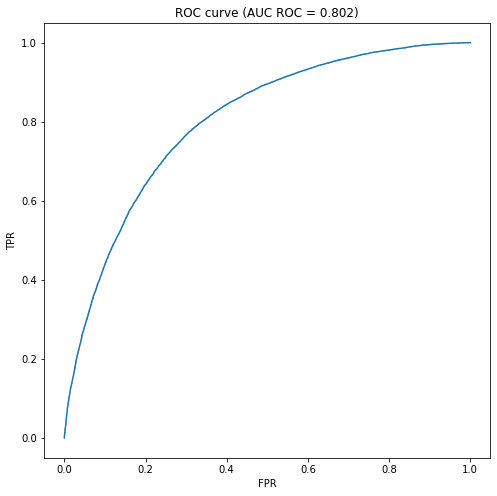

In [ ]:
class CNNSmall2(nn.Module):
    def __init__(self):
        super(CNNSmall2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, bias=True)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 5, bias=True)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 5, bias=True)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6400, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        max_pool = self.max_pool(conv3)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN2 = doExperiment(CNNSmall2(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=10,
             nameOfModel="CNN_Small2_KS=5_AUC={}.pth")

## Experiment 3
- LeNet type
- kernel Size 7

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           3,168
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 48, 20, 20]          75,312
       BatchNorm2d-4           [-1, 48, 20, 20]              96
            Conv2d-5           [-1, 64, 14, 14]         150,592
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Linear-8                    [-1, 1]           3,137
           Sigmoid-9                    [-1, 1]               0
Total params: 232,497
Trainable params: 232,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.89
Estimated Total Size (MB): 1.73
-------------------------------------------

loss = 0.6078096107372216, accuracy : 0.67335045337677, AUC ROC 0.7301708645724737: 100%|██████████| 7004/7004 [02:58<00:00, 39.15it/s]


TRAINING ; Loss: 0.6078 Acc: 0.6734 AUC ROC : 0.7302 Time taken : 179.08


100%|██████████| 779/779 [00:02<00:00, 288.79it/s]


VALIDATION : Loss: 0.5729 Acc: 0.7083 AUC ROC : 0.7713 Time taken : 2.72
Epoch 1/9
----------


loss = 0.5634337789501462, accuracy : 0.7171874642372131, AUC ROC 0.7799138086459593: 100%|██████████| 7004/7004 [03:00<00:00, 38.74it/s]


TRAINING ; Loss: 0.5634 Acc: 0.7172 AUC ROC : 0.7799 Time taken : 181.05


100%|██████████| 779/779 [00:02<00:00, 281.27it/s]


VALIDATION : Loss: 0.5500 Acc: 0.7245 AUC ROC : 0.7944 Time taken : 2.79
Epoch 2/9
----------


loss = 0.5551884790446077, accuracy : 0.7228169441223145, AUC ROC 0.7883991823557551: 100%|██████████| 7004/7004 [03:02<00:00, 38.39it/s]


TRAINING ; Loss: 0.5552 Acc: 0.7228 AUC ROC : 0.7884 Time taken : 182.67


100%|██████████| 779/779 [00:02<00:00, 272.76it/s]


VALIDATION : Loss: 0.5571 Acc: 0.7224 AUC ROC : 0.7904 Time taken : 2.88
Epoch 3/9
----------


loss = 0.5513037795126439, accuracy : 0.7253549098968506, AUC ROC 0.7920074565388235: 100%|██████████| 7004/7004 [03:00<00:00, 38.79it/s]


TRAINING ; Loss: 0.5513 Acc: 0.7253 AUC ROC : 0.7920 Time taken : 180.83


100%|██████████| 779/779 [00:02<00:00, 286.20it/s]


VALIDATION : Loss: 0.5437 Acc: 0.7318 AUC ROC : 0.7996 Time taken : 2.74
Epoch 4/9
----------


loss = 0.5457562226695674, accuracy : 0.7296339273452759, AUC ROC 0.7973551544270315: 100%|██████████| 7004/7004 [02:58<00:00, 39.14it/s]


TRAINING ; Loss: 0.5458 Acc: 0.7296 AUC ROC : 0.7973 Time taken : 179.19


100%|██████████| 779/779 [00:02<00:00, 290.33it/s]


VALIDATION : Loss: 0.5537 Acc: 0.7222 AUC ROC : 0.7918 Time taken : 2.71
Epoch 5/9
----------


loss = 0.5447930291295051, accuracy : 0.7301763296127319, AUC ROC 0.7981952108545514: 100%|██████████| 7004/7004 [02:58<00:00, 39.15it/s]


TRAINING ; Loss: 0.5448 Acc: 0.7302 AUC ROC : 0.7982 Time taken : 179.16


100%|██████████| 779/779 [00:02<00:00, 277.40it/s]


VALIDATION : Loss: 0.5388 Acc: 0.7328 AUC ROC : 0.8033 Time taken : 2.83
Epoch 6/9
----------


loss = 0.5395455538673061, accuracy : 0.7336316704750061, AUC ROC 0.8030271744305493: 100%|██████████| 7004/7004 [02:57<00:00, 39.43it/s]


TRAINING ; Loss: 0.5396 Acc: 0.7336 AUC ROC : 0.8030 Time taken : 177.85


100%|██████████| 779/779 [00:02<00:00, 290.37it/s]


VALIDATION : Loss: 0.5456 Acc: 0.7292 AUC ROC : 0.7977 Time taken : 2.7
Epoch 7/9
----------


loss = 0.538923148044518, accuracy : 0.734261155128479, AUC ROC 0.8036210296602477: 100%|██████████| 7004/7004 [02:58<00:00, 39.29it/s]


TRAINING ; Loss: 0.5389 Acc: 0.7343 AUC ROC : 0.8036 Time taken : 178.47


100%|██████████| 779/779 [00:02<00:00, 272.04it/s]


VALIDATION : Loss: 0.5407 Acc: 0.7325 AUC ROC : 0.8030 Time taken : 2.89
Epoch 8/9
----------


loss = 0.5326817123081002, accuracy : 0.7384151816368103, AUC ROC 0.8091947834484453: 100%|██████████| 7004/7004 [02:58<00:00, 39.28it/s]


TRAINING ; Loss: 0.5327 Acc: 0.7384 AUC ROC : 0.8092 Time taken : 178.57


100%|██████████| 779/779 [00:02<00:00, 292.14it/s]


VALIDATION : Loss: 0.5481 Acc: 0.7281 AUC ROC : 0.7954 Time taken : 2.69
Epoch 9/9
----------


loss = 0.5323032320610115, accuracy : 0.7387120723724365, AUC ROC 0.8095883782178769: 100%|██████████| 7004/7004 [02:57<00:00, 39.38it/s]


TRAINING ; Loss: 0.5323 Acc: 0.7387 AUC ROC : 0.8096 Time taken : 178.11


100%|██████████| 779/779 [00:02<00:00, 281.99it/s]


VALIDATION : Loss: 0.5421 Acc: 0.7318 AUC ROC : 0.8014 Time taken : 2.79
Training complete in 30m 23s


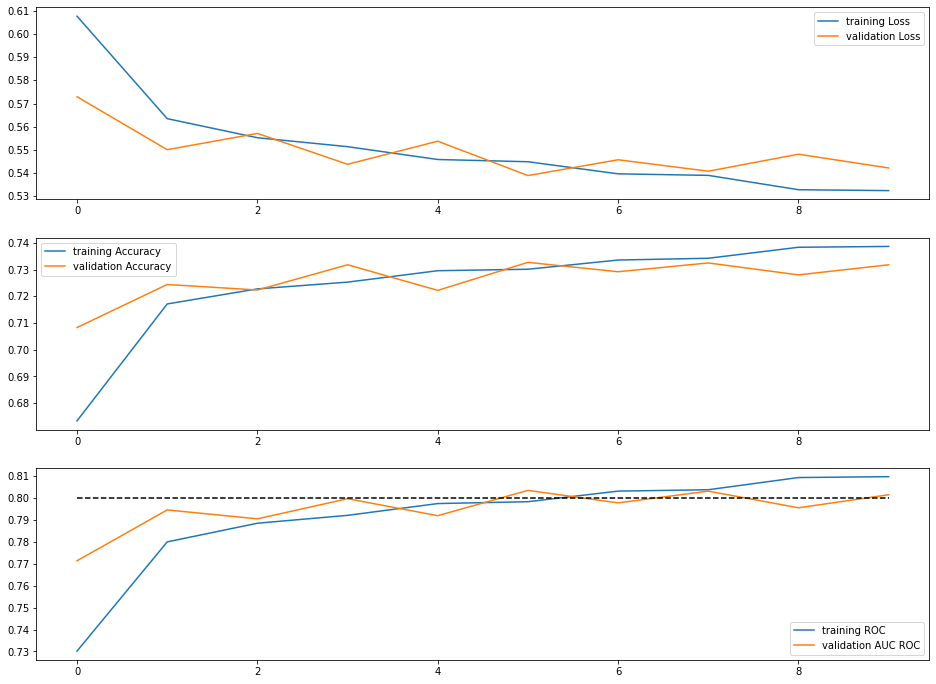

100%|██████████| 779/779 [00:02<00:00, 305.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

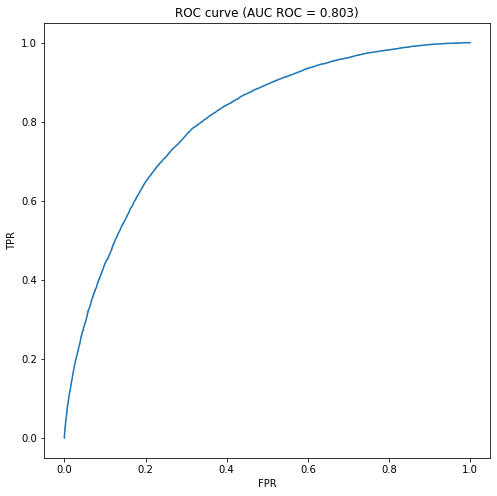

In [ ]:
class CNNSmall3(nn.Module):
    def __init__(self):
        super(CNNSmall3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 7, bias=True)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 7, bias=True)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 7, bias=True)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        max_pool = self.max_pool(conv3)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN3 = doExperiment(CNNSmall3(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=10,
             nameOfModel="CNN_Small3_KS=7_AUC={}.pth")

## Experiment 4 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool2d-1            [-1, 2, 16, 16]               0
            Conv2d-2           [-1, 32, 14, 14]             608
       BatchNorm2d-3           [-1, 32, 14, 14]              64
            Conv2d-4           [-1, 48, 12, 12]          13,872
       BatchNorm2d-5           [-1, 48, 12, 12]              96
            Conv2d-6           [-1, 64, 10, 10]          27,712
       BatchNorm2d-7           [-1, 64, 10, 10]             128
            Linear-8                    [-1, 1]           6,401
           Sigmoid-9                    [-1, 1]               0
Total params: 48,881
Trainable params: 48,881
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.19
Estimated Total Size (MB): 0.50
---------------------------------------------

loss = 0.63799731446164, accuracy : 0.6375691890716553, AUC ROC 0.6864077860258686: 100%|██████████| 7004/7004 [02:39<00:00, 44.00it/s]


TRAINING ; Loss: 0.6380 Acc: 0.6376 AUC ROC : 0.6864 Time taken : 159.36


100%|██████████| 779/779 [00:02<00:00, 337.15it/s]


VALIDATION : Loss: 0.6140 Acc: 0.6658 AUC ROC : 0.7236 Time taken : 2.34
Epoch 1/9
----------


loss = 0.6048381094804832, accuracy : 0.6772009134292603, AUC ROC 0.7337413105935813: 100%|██████████| 7004/7004 [02:39<00:00, 44.05it/s]


TRAINING ; Loss: 0.6048 Acc: 0.6772 AUC ROC : 0.7337 Time taken : 159.24


100%|██████████| 779/779 [00:02<00:00, 330.73it/s]


VALIDATION : Loss: 0.5939 Acc: 0.6891 AUC ROC : 0.7468 Time taken : 2.38
Epoch 2/9
----------


loss = 0.598623845074858, accuracy : 0.6824665069580078, AUC ROC 0.7413982001860441: 100%|██████████| 7004/7004 [02:38<00:00, 44.21it/s]


TRAINING ; Loss: 0.5986 Acc: 0.6825 AUC ROC : 0.7414 Time taken : 158.68


100%|██████████| 779/779 [00:02<00:00, 317.82it/s]


VALIDATION : Loss: 0.6014 Acc: 0.6818 AUC ROC : 0.7390 Time taken : 2.48
Epoch 3/9
----------


loss = 0.5958053164737566, accuracy : 0.6850848197937012, AUC ROC 0.7446686960496804: 100%|██████████| 7004/7004 [02:38<00:00, 44.07it/s]


TRAINING ; Loss: 0.5958 Acc: 0.6851 AUC ROC : 0.7447 Time taken : 159.17


100%|██████████| 779/779 [00:02<00:00, 336.13it/s]


VALIDATION : Loss: 0.5901 Acc: 0.6916 AUC ROC : 0.7514 Time taken : 2.34
Epoch 4/9
----------


loss = 0.5929600075015, accuracy : 0.6876963973045349, AUC ROC 0.7480138360032961: 100%|██████████| 7004/7004 [02:40<00:00, 43.54it/s]


TRAINING ; Loss: 0.5930 Acc: 0.6877 AUC ROC : 0.7480 Time taken : 161.16


100%|██████████| 779/779 [00:02<00:00, 343.74it/s]


VALIDATION : Loss: 0.6022 Acc: 0.6811 AUC ROC : 0.7414 Time taken : 2.29
Epoch 5/9
----------


loss = 0.5917714751831122, accuracy : 0.6882455348968506, AUC ROC 0.7492735754469714: 100%|██████████| 7004/7004 [02:40<00:00, 43.67it/s]


TRAINING ; Loss: 0.5918 Acc: 0.6882 AUC ROC : 0.7493 Time taken : 160.65


100%|██████████| 779/779 [00:02<00:00, 332.54it/s]


VALIDATION : Loss: 0.5880 Acc: 0.6924 AUC ROC : 0.7532 Time taken : 2.37
Epoch 6/9
----------


loss = 0.5895550306779997, accuracy : 0.6905423998832703, AUC ROC 0.7519180863175432: 100%|██████████| 7004/7004 [02:40<00:00, 43.69it/s]


TRAINING ; Loss: 0.5896 Acc: 0.6905 AUC ROC : 0.7519 Time taken : 160.55


100%|██████████| 779/779 [00:02<00:00, 339.78it/s]


VALIDATION : Loss: 0.5954 Acc: 0.6842 AUC ROC : 0.7453 Time taken : 2.32
Epoch 7/9
----------


loss = 0.5891877528343882, accuracy : 0.6910825967788696, AUC ROC 0.7524371910529324: 100%|██████████| 7004/7004 [02:39<00:00, 43.94it/s]


TRAINING ; Loss: 0.5892 Acc: 0.6911 AUC ROC : 0.7525 Time taken : 159.65


100%|██████████| 779/779 [00:02<00:00, 352.37it/s]


VALIDATION : Loss: 0.5861 Acc: 0.6942 AUC ROC : 0.7554 Time taken : 2.23
Epoch 8/9
----------


loss = 0.5872406252324581, accuracy : 0.6919821500778198, AUC ROC 0.7546169422428297: 100%|██████████| 7004/7004 [02:40<00:00, 43.61it/s]


TRAINING ; Loss: 0.5873 Acc: 0.6920 AUC ROC : 0.7546 Time taken : 160.85


100%|██████████| 779/779 [00:02<00:00, 355.92it/s]


VALIDATION : Loss: 0.5955 Acc: 0.6880 AUC ROC : 0.7467 Time taken : 2.21
Epoch 9/9
----------


loss = 0.587641413548163, accuracy : 0.6918571591377258, AUC ROC 0.7541225665470735: 100%|██████████| 7004/7004 [02:41<00:00, 43.44it/s]


TRAINING ; Loss: 0.5876 Acc: 0.6919 AUC ROC : 0.7542 Time taken : 161.49


100%|██████████| 779/779 [00:02<00:00, 343.60it/s]


VALIDATION : Loss: 0.5866 Acc: 0.6942 AUC ROC : 0.7557 Time taken : 2.29
Training complete in 27m 4s


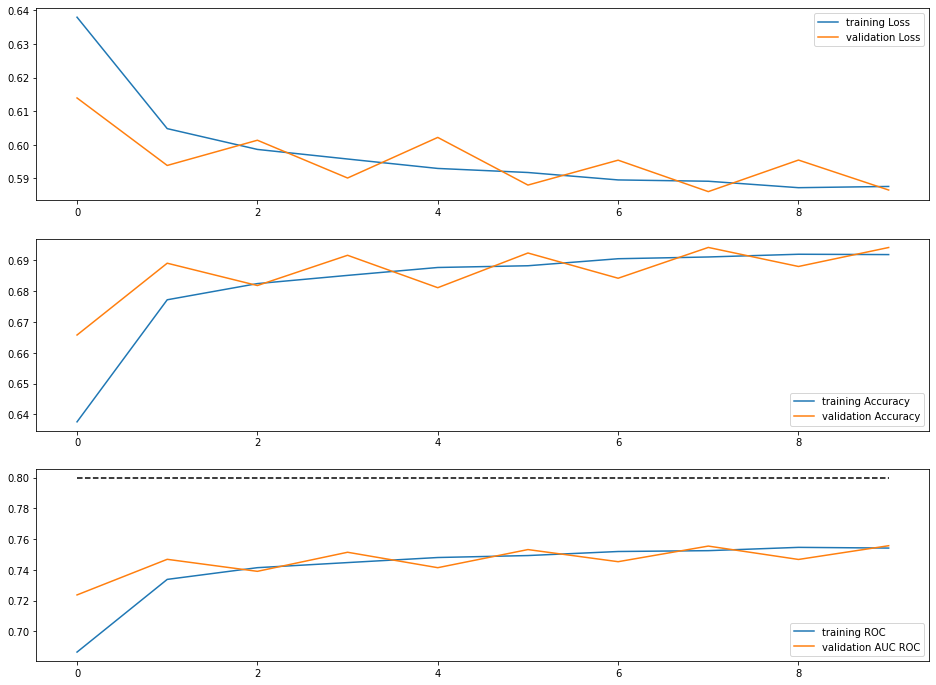

100%|██████████| 779/779 [00:02<00:00, 378.73it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

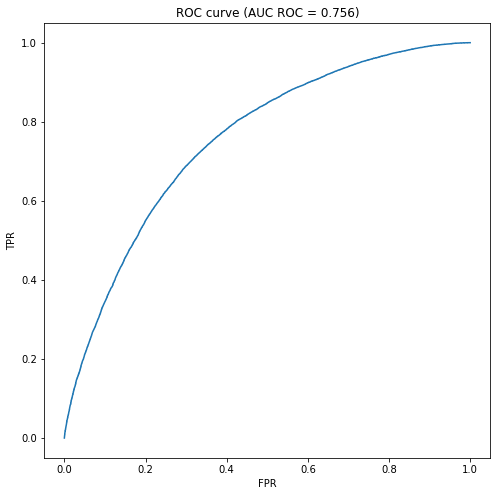

In [ ]:
class CNNSmall4(nn.Module):
    def __init__(self):
        super(CNNSmall4, self).__init__()
        self.pool = nn.AvgPool2d(2)
        self.conv1 = nn.Conv2d(2, 32, 3, bias=True)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=True)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=True)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(6400, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x     = self.pool(x)
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        flat1 = torch.flatten(conv3.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN4 = doExperiment(CNNSmall4(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=10,
             nameOfModel="CNN_Small4_KS=7_AUC={}.pth")

## Experiment 5


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 31, 31]           4,096
       BatchNorm2d-4           [-1, 32, 31, 31]              64
            Conv2d-5           [-1, 48, 30, 30]           6,144
       BatchNorm2d-6           [-1, 48, 30, 30]              96
            Conv2d-7           [-1, 48, 28, 28]          20,736
       BatchNorm2d-8           [-1, 48, 28, 28]              96
            Conv2d-9           [-1, 64, 26, 26]          27,648
      BatchNorm2d-10           [-1, 64, 26, 26]             128
           Conv2d-11           [-1, 64, 22, 22]         102,400
      BatchNorm2d-12           [-1, 64, 22, 22]             128
           Conv2d-13           [-1, 64, 18, 18]         102,400
      BatchNorm2d-14           [-1, 64,

loss = 0.6022667490158762, accuracy : 0.6828727722167969, AUC ROC 0.7374341026075386: 100%|██████████| 7004/7004 [03:58<00:00, 29.43it/s]


TRAINING ; Loss: 0.6023 Acc: 0.6829 AUC ROC : 0.7374 Time taken : 238.19


100%|██████████| 779/779 [00:04<00:00, 167.53it/s]


VALIDATION : Loss: 0.5773 Acc: 0.7016 AUC ROC : 0.7699 Time taken : 4.68
Epoch 1/24
----------


loss = 0.5627890497488635, accuracy : 0.7178995609283447, AUC ROC 0.780939409499033: 100%|██████████| 7004/7004 [04:01<00:00, 29.03it/s]


TRAINING ; Loss: 0.5628 Acc: 0.7179 AUC ROC : 0.7810 Time taken : 241.56


100%|██████████| 779/779 [00:04<00:00, 169.68it/s]


VALIDATION : Loss: 0.5477 Acc: 0.7277 AUC ROC : 0.7958 Time taken : 4.61
Epoch 2/24
----------


loss = 0.5547493684462138, accuracy : 0.7239508628845215, AUC ROC 0.7888214641094404: 100%|██████████| 7004/7004 [04:00<00:00, 29.07it/s]


TRAINING ; Loss: 0.5548 Acc: 0.7239 AUC ROC : 0.7888 Time taken : 241.22


100%|██████████| 779/779 [00:04<00:00, 168.56it/s]


VALIDATION : Loss: 0.5528 Acc: 0.7254 AUC ROC : 0.7912 Time taken : 4.64
Epoch 3/24
----------


loss = 0.5498883962162904, accuracy : 0.7269843816757202, AUC ROC 0.7935795812797668: 100%|██████████| 7004/7004 [03:59<00:00, 29.24it/s]


TRAINING ; Loss: 0.5499 Acc: 0.7270 AUC ROC : 0.7936 Time taken : 239.86


100%|██████████| 779/779 [00:04<00:00, 167.69it/s]


VALIDATION : Loss: 0.5397 Acc: 0.7330 AUC ROC : 0.8035 Time taken : 4.67
Epoch 4/24
----------


loss = 0.5458403914357934, accuracy : 0.7301227450370789, AUC ROC 0.7973532313044848: 100%|██████████| 7004/7004 [04:00<00:00, 29.16it/s]


TRAINING ; Loss: 0.5458 Acc: 0.7301 AUC ROC : 0.7974 Time taken : 240.52


100%|██████████| 779/779 [00:04<00:00, 168.63it/s]


VALIDATION : Loss: 0.5437 Acc: 0.7296 AUC ROC : 0.7988 Time taken : 4.64
Epoch 5/24
----------


loss = 0.5440050382188388, accuracy : 0.7315736413002014, AUC ROC 0.7990412515241556: 100%|██████████| 7004/7004 [03:59<00:00, 29.19it/s]


TRAINING ; Loss: 0.5440 Acc: 0.7316 AUC ROC : 0.7991 Time taken : 240.26


100%|██████████| 779/779 [00:04<00:00, 170.19it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7340 AUC ROC : 0.8051 Time taken : 4.6
Epoch 6/24
----------


loss = 0.5406236752016204, accuracy : 0.7339397072792053, AUC ROC 0.8021157366137963: 100%|██████████| 7004/7004 [04:01<00:00, 29.04it/s]


TRAINING ; Loss: 0.5406 Acc: 0.7339 AUC ROC : 0.8021 Time taken : 241.5


100%|██████████| 779/779 [00:04<00:00, 168.36it/s]


VALIDATION : Loss: 0.5439 Acc: 0.7316 AUC ROC : 0.8010 Time taken : 4.65
Epoch 7/24
----------


loss = 0.5397033090719154, accuracy : 0.7347209453582764, AUC ROC 0.8030024415916576: 100%|██████████| 7004/7004 [04:01<00:00, 29.05it/s]


TRAINING ; Loss: 0.5397 Acc: 0.7347 AUC ROC : 0.8030 Time taken : 241.38


100%|██████████| 779/779 [00:04<00:00, 161.92it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7348 AUC ROC : 0.8068 Time taken : 4.84
Epoch 8/24
----------


loss = 0.5369966915845871, accuracy : 0.7366004586219788, AUC ROC 0.8054299665040144: 100%|██████████| 7004/7004 [04:03<00:00, 28.81it/s]


TRAINING ; Loss: 0.5370 Acc: 0.7366 AUC ROC : 0.8054 Time taken : 243.38


100%|██████████| 779/779 [00:04<00:00, 167.70it/s]


VALIDATION : Loss: 0.5624 Acc: 0.7141 AUC ROC : 0.7923 Time taken : 4.67
Epoch 9/24
----------


loss = 0.5365902775951794, accuracy : 0.7369441986083984, AUC ROC 0.8058261737685296: 100%|██████████| 7004/7004 [04:04<00:00, 28.66it/s]


TRAINING ; Loss: 0.5366 Acc: 0.7369 AUC ROC : 0.8058 Time taken : 244.71


100%|██████████| 779/779 [00:04<00:00, 167.15it/s]


VALIDATION : Loss: 0.5329 Acc: 0.7377 AUC ROC : 0.8089 Time taken : 4.69
Epoch 10/24
----------


loss = 0.5338709847756794, accuracy : 0.7386384010314941, AUC ROC 0.8082450801150977: 100%|██████████| 7004/7004 [04:02<00:00, 28.92it/s]


TRAINING ; Loss: 0.5339 Acc: 0.7387 AUC ROC : 0.8083 Time taken : 242.54


100%|██████████| 779/779 [00:04<00:00, 168.48it/s]


VALIDATION : Loss: 0.5494 Acc: 0.7270 AUC ROC : 0.8016 Time taken : 4.65
Epoch 11/24
----------


loss = 0.533811309929405, accuracy : 0.738861620426178, AUC ROC 0.8083016997729652: 100%|██████████| 7004/7004 [04:04<00:00, 28.63it/s]


TRAINING ; Loss: 0.5338 Acc: 0.7388 AUC ROC : 0.8083 Time taken : 244.96


100%|██████████| 779/779 [00:04<00:00, 165.79it/s]


VALIDATION : Loss: 0.5313 Acc: 0.7377 AUC ROC : 0.8104 Time taken : 4.73
Epoch 12/24
----------


loss = 0.5304738208310945, accuracy : 0.7405446171760559, AUC ROC 0.8112407433928542: 100%|██████████| 7004/7004 [04:08<00:00, 28.19it/s]


TRAINING ; Loss: 0.5305 Acc: 0.7405 AUC ROC : 0.8112 Time taken : 248.81


100%|██████████| 779/779 [00:04<00:00, 163.33it/s]


VALIDATION : Loss: 0.5545 Acc: 0.7253 AUC ROC : 0.7994 Time taken : 4.8
Epoch 13/24
----------


loss = 0.5309473923572472, accuracy : 0.7408013343811035, AUC ROC 0.8108175492700938: 100%|██████████| 7004/7004 [04:05<00:00, 28.59it/s]


TRAINING ; Loss: 0.5310 Acc: 0.7408 AUC ROC : 0.8108 Time taken : 245.33


100%|██████████| 779/779 [00:04<00:00, 168.66it/s]


VALIDATION : Loss: 0.5319 Acc: 0.7378 AUC ROC : 0.8103 Time taken : 4.64
Epoch 14/24
----------


loss = 0.5274143691829273, accuracy : 0.7428638339042664, AUC ROC 0.8138291512146391: 100%|██████████| 7004/7004 [04:04<00:00, 28.62it/s]


TRAINING ; Loss: 0.5274 Acc: 0.7429 AUC ROC : 0.8138 Time taken : 245.01


100%|██████████| 779/779 [00:04<00:00, 168.09it/s]


VALIDATION : Loss: 0.5494 Acc: 0.7268 AUC ROC : 0.7965 Time taken : 4.66
Epoch 15/24
----------


loss = 0.5279303755632468, accuracy : 0.7421897053718567, AUC ROC 0.8133130967569826: 100%|██████████| 7004/7004 [04:04<00:00, 28.66it/s]


TRAINING ; Loss: 0.5279 Acc: 0.7422 AUC ROC : 0.8133 Time taken : 244.7


100%|██████████| 779/779 [00:04<00:00, 168.66it/s]


VALIDATION : Loss: 0.5314 Acc: 0.7380 AUC ROC : 0.8104 Time taken : 4.64
Epoch 16/24
----------


loss = 0.5240083831208093, accuracy : 0.7452142834663391, AUC ROC 0.8167807581497034: 100%|██████████| 7004/7004 [04:05<00:00, 28.58it/s]


TRAINING ; Loss: 0.5240 Acc: 0.7452 AUC ROC : 0.8168 Time taken : 245.35


100%|██████████| 779/779 [00:04<00:00, 168.35it/s]


VALIDATION : Loss: 0.5478 Acc: 0.7313 AUC ROC : 0.8013 Time taken : 4.65
Epoch 17/24
----------


loss = 0.5248951541398252, accuracy : 0.7442209720611572, AUC ROC 0.8161268694380867: 100%|██████████| 7004/7004 [04:04<00:00, 28.66it/s]


TRAINING ; Loss: 0.5249 Acc: 0.7442 AUC ROC : 0.8161 Time taken : 244.72


100%|██████████| 779/779 [00:04<00:00, 162.76it/s]


VALIDATION : Loss: 0.5326 Acc: 0.7379 AUC ROC : 0.8101 Time taken : 4.81
Epoch 18/24
----------


loss = 0.5208969892220838, accuracy : 0.7467164993286133, AUC ROC 0.8194194614412803: 100%|██████████| 7004/7004 [04:09<00:00, 28.08it/s]


TRAINING ; Loss: 0.5209 Acc: 0.7467 AUC ROC : 0.8194 Time taken : 249.73


100%|██████████| 779/779 [00:04<00:00, 163.79it/s]


VALIDATION : Loss: 0.5429 Acc: 0.7329 AUC ROC : 0.8016 Time taken : 4.78
Epoch 19/24
----------


loss = 0.5217807179902281, accuracy : 0.7464441657066345, AUC ROC 0.8186768932153293: 100%|██████████| 7004/7004 [04:06<00:00, 28.40it/s]


TRAINING ; Loss: 0.5218 Acc: 0.7464 AUC ROC : 0.8187 Time taken : 246.96


100%|██████████| 779/779 [00:04<00:00, 165.56it/s]


VALIDATION : Loss: 0.5336 Acc: 0.7378 AUC ROC : 0.8088 Time taken : 4.73
Epoch 20/24
----------


loss = 0.517507885392223, accuracy : 0.7494732141494751, AUC ROC 0.8222856254947043: 100%|██████████| 7004/7004 [04:05<00:00, 28.57it/s]


TRAINING ; Loss: 0.5175 Acc: 0.7495 AUC ROC : 0.8223 Time taken : 245.48


100%|██████████| 779/779 [00:04<00:00, 167.59it/s]


VALIDATION : Loss: 0.5392 Acc: 0.7341 AUC ROC : 0.8063 Time taken : 4.67
Epoch 21/24
----------


loss = 0.518151378606047, accuracy : 0.7482053637504578, AUC ROC 0.8216531502627911: 100%|██████████| 7004/7004 [04:06<00:00, 28.37it/s]


TRAINING ; Loss: 0.5181 Acc: 0.7482 AUC ROC : 0.8217 Time taken : 247.2


100%|██████████| 779/779 [00:04<00:00, 165.82it/s]


VALIDATION : Loss: 0.5352 Acc: 0.7362 AUC ROC : 0.8092 Time taken : 4.73
Epoch 22/24
----------


loss = 0.5127362462239606, accuracy : 0.7526049017906189, AUC ROC 0.8260764876980777: 100%|██████████| 7004/7004 [04:08<00:00, 28.18it/s]


TRAINING ; Loss: 0.5128 Acc: 0.7526 AUC ROC : 0.8261 Time taken : 248.86


100%|██████████| 779/779 [00:04<00:00, 166.65it/s]


VALIDATION : Loss: 0.5435 Acc: 0.7295 AUC ROC : 0.8005 Time taken : 4.7
Epoch 23/24
----------


loss = 0.5140059157737664, accuracy : 0.7517812252044678, AUC ROC 0.8251050711960601: 100%|██████████| 7004/7004 [04:05<00:00, 28.49it/s]


TRAINING ; Loss: 0.5140 Acc: 0.7518 AUC ROC : 0.8251 Time taken : 246.18


100%|██████████| 779/779 [00:04<00:00, 166.26it/s]


VALIDATION : Loss: 0.5379 Acc: 0.7360 AUC ROC : 0.8080 Time taken : 4.71
Epoch 24/24
----------


loss = 0.5080780898886067, accuracy : 0.7555223107337952, AUC ROC 0.8297693218165642: 100%|██████████| 7004/7004 [04:05<00:00, 28.58it/s]


TRAINING ; Loss: 0.5081 Acc: 0.7555 AUC ROC : 0.8298 Time taken : 245.37


100%|██████████| 779/779 [00:04<00:00, 163.35it/s]


VALIDATION : Loss: 0.5554 Acc: 0.7228 AUC ROC : 0.7981 Time taken : 4.79
Training complete in 103m 41s


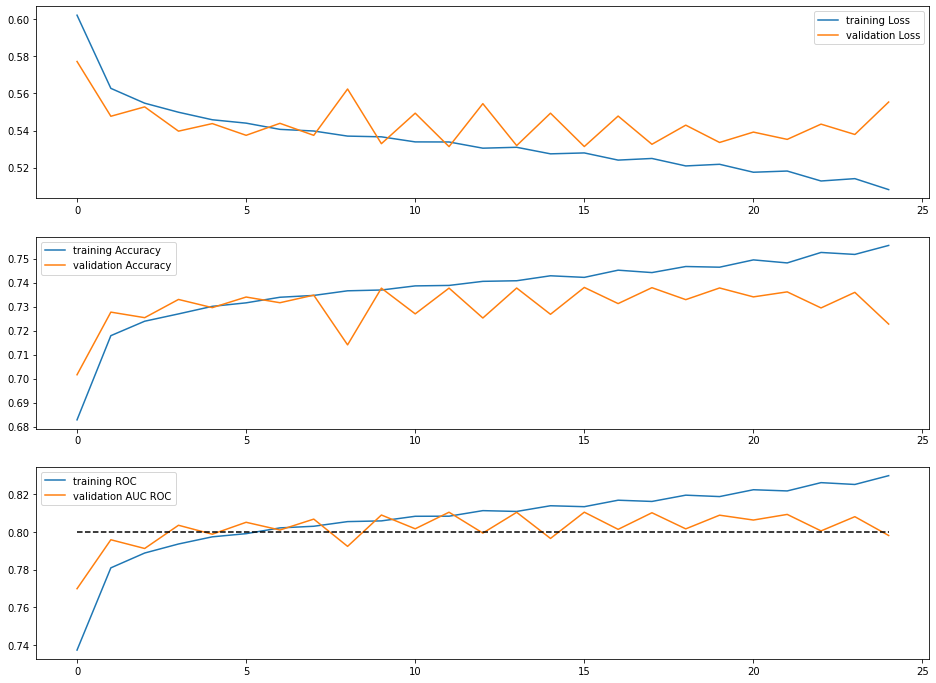

100%|██████████| 779/779 [00:04<00:00, 171.90it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

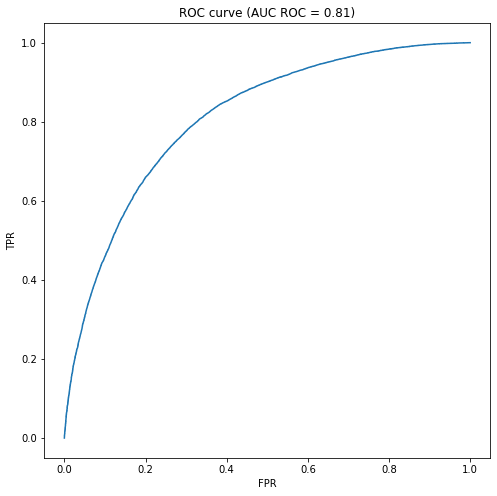

In [ ]:
class CNNSmall5(nn.Module):
    def __init__(self):
        super(CNNSmall5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN5 = doExperiment(CNNSmall5(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="CNN_Small5_KS=mix_AUC={}.pth")

## Experiment 6
previous one with bias

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              96
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 31, 31]           4,128
       BatchNorm2d-4           [-1, 32, 31, 31]              64
            Conv2d-5           [-1, 48, 30, 30]           6,192
       BatchNorm2d-6           [-1, 48, 30, 30]              96
            Conv2d-7           [-1, 48, 28, 28]          20,784
       BatchNorm2d-8           [-1, 48, 28, 28]              96
            Conv2d-9           [-1, 64, 26, 26]          27,712
      BatchNorm2d-10           [-1, 64, 26, 26]             128
           Conv2d-11           [-1, 64, 22, 22]         102,464
      BatchNorm2d-12           [-1, 64, 22, 22]             128
           Conv2d-13           [-1, 64, 18, 18]         102,464
      BatchNorm2d-14           [-1, 64,

loss = 0.6046167367483888, accuracy : 0.6808526515960693, AUC ROC 0.7348475454202712: 100%|██████████| 7004/7004 [04:06<00:00, 28.43it/s]


TRAINING ; Loss: 0.6046 Acc: 0.6808 AUC ROC : 0.7348 Time taken : 246.51


100%|██████████| 779/779 [00:04<00:00, 156.03it/s]


VALIDATION : Loss: 0.5770 Acc: 0.7108 AUC ROC : 0.7736 Time taken : 5.02
Epoch 1/24
----------


loss = 0.5639372064386096, accuracy : 0.7175111770629883, AUC ROC 0.7798541071410767: 100%|██████████| 7004/7004 [04:06<00:00, 28.42it/s]


TRAINING ; Loss: 0.5639 Acc: 0.7175 AUC ROC : 0.7799 Time taken : 246.71


100%|██████████| 779/779 [00:05<00:00, 153.06it/s]


VALIDATION : Loss: 0.5479 Acc: 0.7276 AUC ROC : 0.7959 Time taken : 5.11
Epoch 2/24
----------


loss = 0.554365349569491, accuracy : 0.724598228931427, AUC ROC 0.7893441939132123: 100%|██████████| 7004/7004 [04:02<00:00, 28.85it/s]


TRAINING ; Loss: 0.5544 Acc: 0.7246 AUC ROC : 0.7893 Time taken : 243.11


100%|██████████| 779/779 [00:04<00:00, 158.19it/s]


VALIDATION : Loss: 0.5524 Acc: 0.7240 AUC ROC : 0.7921 Time taken : 4.95
Epoch 3/24
----------


loss = 0.5500313521197864, accuracy : 0.7273035645484924, AUC ROC 0.7933942978192028: 100%|██████████| 7004/7004 [04:01<00:00, 28.98it/s]


TRAINING ; Loss: 0.5500 Acc: 0.7273 AUC ROC : 0.7934 Time taken : 242.04


100%|██████████| 779/779 [00:04<00:00, 158.69it/s]


VALIDATION : Loss: 0.5423 Acc: 0.7305 AUC ROC : 0.8015 Time taken : 4.93
Epoch 4/24
----------


loss = 0.5462204632035323, accuracy : 0.7296718955039978, AUC ROC 0.7970068868931781: 100%|██████████| 7004/7004 [04:06<00:00, 28.43it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7296 AUC ROC : 0.7970 Time taken : 246.71


100%|██████████| 779/779 [00:05<00:00, 153.07it/s]


VALIDATION : Loss: 0.5570 Acc: 0.7237 AUC ROC : 0.7910 Time taken : 5.11
Epoch 5/24
----------


loss = 0.5443103829664844, accuracy : 0.731515645980835, AUC ROC 0.7987055060390146: 100%|██████████| 7004/7004 [04:07<00:00, 28.25it/s]


TRAINING ; Loss: 0.5443 Acc: 0.7315 AUC ROC : 0.7987 Time taken : 248.29


100%|██████████| 779/779 [00:05<00:00, 152.86it/s]


VALIDATION : Loss: 0.5373 Acc: 0.7352 AUC ROC : 0.8055 Time taken : 5.12
Epoch 6/24
----------


loss = 0.5419460430911609, accuracy : 0.7337455153465271, AUC ROC 0.8008157791216386: 100%|██████████| 7004/7004 [04:04<00:00, 28.61it/s]


TRAINING ; Loss: 0.5419 Acc: 0.7337 AUC ROC : 0.8008 Time taken : 245.09


100%|██████████| 779/779 [00:05<00:00, 151.48it/s]


VALIDATION : Loss: 0.5948 Acc: 0.6794 AUC ROC : 0.7596 Time taken : 5.17
Epoch 7/24
----------


loss = 0.5409903195415224, accuracy : 0.7340424060821533, AUC ROC 0.8018156581393856: 100%|██████████| 7004/7004 [04:07<00:00, 28.35it/s]


TRAINING ; Loss: 0.5410 Acc: 0.7341 AUC ROC : 0.8018 Time taken : 247.33


100%|██████████| 779/779 [00:05<00:00, 155.06it/s]


VALIDATION : Loss: 0.5361 Acc: 0.7361 AUC ROC : 0.8066 Time taken : 5.05
Epoch 8/24
----------


loss = 0.5381149719953537, accuracy : 0.7353057861328125, AUC ROC 0.804421320802984: 100%|██████████| 7004/7004 [04:08<00:00, 28.24it/s]


TRAINING ; Loss: 0.5381 Acc: 0.7353 AUC ROC : 0.8044 Time taken : 248.31


100%|██████████| 779/779 [00:05<00:00, 152.55it/s]


VALIDATION : Loss: 0.5396 Acc: 0.7338 AUC ROC : 0.8040 Time taken : 5.13
Epoch 9/24
----------


loss = 0.5376133600856576, accuracy : 0.7362098097801208, AUC ROC 0.8049235759928075: 100%|██████████| 7004/7004 [04:09<00:00, 28.10it/s]


TRAINING ; Loss: 0.5376 Acc: 0.7362 AUC ROC : 0.8049 Time taken : 249.59


100%|██████████| 779/779 [00:05<00:00, 153.53it/s]


VALIDATION : Loss: 0.5368 Acc: 0.7356 AUC ROC : 0.8080 Time taken : 5.1
Epoch 10/24
----------


loss = 0.5349382996857166, accuracy : 0.73795086145401, AUC ROC 0.807221255317427: 100%|██████████| 7004/7004 [04:05<00:00, 28.49it/s]


TRAINING ; Loss: 0.5350 Acc: 0.7379 AUC ROC : 0.8072 Time taken : 246.15


100%|██████████| 779/779 [00:05<00:00, 151.05it/s]


VALIDATION : Loss: 0.5582 Acc: 0.7178 AUC ROC : 0.7907 Time taken : 5.18
Epoch 11/24
----------


loss = 0.5347958109591688, accuracy : 0.7379018068313599, AUC ROC 0.8074230713571982: 100%|██████████| 7004/7004 [04:05<00:00, 28.53it/s]


TRAINING ; Loss: 0.5348 Acc: 0.7379 AUC ROC : 0.8074 Time taken : 245.84


100%|██████████| 779/779 [00:05<00:00, 154.51it/s]


VALIDATION : Loss: 0.5339 Acc: 0.7359 AUC ROC : 0.8086 Time taken : 5.07
Epoch 12/24
----------


loss = 0.5322517522786345, accuracy : 0.7397656440734863, AUC ROC 0.8096398259488529: 100%|██████████| 7004/7004 [04:07<00:00, 28.34it/s]


TRAINING ; Loss: 0.5322 Acc: 0.7398 AUC ROC : 0.8096 Time taken : 247.43


100%|██████████| 779/779 [00:05<00:00, 148.36it/s]


VALIDATION : Loss: 0.5446 Acc: 0.7297 AUC ROC : 0.7999 Time taken : 5.28
Epoch 13/24
----------


loss = 0.5321433649361134, accuracy : 0.7398593425750732, AUC ROC 0.8096751036062448: 100%|██████████| 7004/7004 [04:08<00:00, 28.17it/s]


TRAINING ; Loss: 0.5321 Acc: 0.7399 AUC ROC : 0.8097 Time taken : 248.93


100%|██████████| 779/779 [00:05<00:00, 151.84it/s]


VALIDATION : Loss: 0.5329 Acc: 0.7362 AUC ROC : 0.8091 Time taken : 5.15
Epoch 14/24
----------


loss = 0.5295779161666121, accuracy : 0.7411718964576721, AUC ROC 0.8120469374758909: 100%|██████████| 7004/7004 [04:06<00:00, 28.40it/s]


TRAINING ; Loss: 0.5296 Acc: 0.7412 AUC ROC : 0.8121 Time taken : 246.92


100%|██████████| 779/779 [00:05<00:00, 151.40it/s]


VALIDATION : Loss: 0.5403 Acc: 0.7334 AUC ROC : 0.8044 Time taken : 5.17
Epoch 15/24
----------


loss = 0.5296838828197548, accuracy : 0.741167426109314, AUC ROC 0.8119296492890918: 100%|██████████| 7004/7004 [04:05<00:00, 28.55it/s]


TRAINING ; Loss: 0.5296 Acc: 0.7412 AUC ROC : 0.8120 Time taken : 245.63


100%|██████████| 779/779 [00:04<00:00, 157.35it/s]


VALIDATION : Loss: 0.5324 Acc: 0.7381 AUC ROC : 0.8095 Time taken : 4.97
Epoch 16/24
----------


loss = 0.5266459803623813, accuracy : 0.7433459758758545, AUC ROC 0.8145226884219167: 100%|██████████| 7004/7004 [04:08<00:00, 28.22it/s]


TRAINING ; Loss: 0.5267 Acc: 0.7433 AUC ROC : 0.8145 Time taken : 248.46


100%|██████████| 779/779 [00:05<00:00, 151.40it/s]


VALIDATION : Loss: 0.5391 Acc: 0.7346 AUC ROC : 0.8034 Time taken : 5.17
Epoch 17/24
----------


loss = 0.5269827472737857, accuracy : 0.7430200576782227, AUC ROC 0.8141961825124412: 100%|██████████| 7004/7004 [04:10<00:00, 27.98it/s]


TRAINING ; Loss: 0.5270 Acc: 0.7430 AUC ROC : 0.8142 Time taken : 250.68


100%|██████████| 779/779 [00:05<00:00, 149.35it/s]


VALIDATION : Loss: 0.5330 Acc: 0.7386 AUC ROC : 0.8093 Time taken : 5.24
Epoch 18/24
----------


loss = 0.5235633716242654, accuracy : 0.7457812428474426, AUC ROC 0.817174812965453: 100%|██████████| 7004/7004 [04:09<00:00, 28.09it/s]


TRAINING ; Loss: 0.5235 Acc: 0.7458 AUC ROC : 0.8172 Time taken : 249.64


100%|██████████| 779/779 [00:05<00:00, 153.57it/s]


VALIDATION : Loss: 0.5442 Acc: 0.7278 AUC ROC : 0.8017 Time taken : 5.1
Epoch 19/24
----------


loss = 0.5242927960966315, accuracy : 0.7454397082328796, AUC ROC 0.8165303665181214: 100%|██████████| 7004/7004 [04:09<00:00, 28.03it/s]


TRAINING ; Loss: 0.5243 Acc: 0.7454 AUC ROC : 0.8165 Time taken : 250.16


100%|██████████| 779/779 [00:05<00:00, 153.14it/s]


VALIDATION : Loss: 0.5335 Acc: 0.7372 AUC ROC : 0.8088 Time taken : 5.11
Epoch 20/24
----------


loss = 0.5204437186590263, accuracy : 0.7478013038635254, AUC ROC 0.8198512293664468: 100%|██████████| 7004/7004 [04:08<00:00, 28.13it/s]


TRAINING ; Loss: 0.5204 Acc: 0.7478 AUC ROC : 0.8199 Time taken : 249.31


100%|██████████| 779/779 [00:05<00:00, 153.52it/s]


VALIDATION : Loss: 0.6027 Acc: 0.6808 AUC ROC : 0.7664 Time taken : 5.1
Epoch 21/24
----------


loss = 0.5209022876194546, accuracy : 0.7468906044960022, AUC ROC 0.8194241406523999: 100%|██████████| 7004/7004 [04:07<00:00, 28.26it/s]


TRAINING ; Loss: 0.5209 Acc: 0.7469 AUC ROC : 0.8194 Time taken : 248.14


100%|██████████| 779/779 [00:05<00:00, 153.07it/s]


VALIDATION : Loss: 0.5335 Acc: 0.7380 AUC ROC : 0.8098 Time taken : 5.12
Epoch 22/24
----------


loss = 0.5167089149568762, accuracy : 0.7504732012748718, AUC ROC 0.8228476858838016: 100%|██████████| 7004/7004 [04:04<00:00, 28.59it/s]


TRAINING ; Loss: 0.5167 Acc: 0.7505 AUC ROC : 0.8229 Time taken : 245.26


100%|██████████| 779/779 [00:05<00:00, 154.49it/s]


VALIDATION : Loss: 0.5394 Acc: 0.7345 AUC ROC : 0.8043 Time taken : 5.07
Epoch 23/24
----------


loss = 0.5174173165772642, accuracy : 0.7493839263916016, AUC ROC 0.82226521952306: 100%|██████████| 7004/7004 [04:07<00:00, 28.31it/s]


TRAINING ; Loss: 0.5174 Acc: 0.7494 AUC ROC : 0.8223 Time taken : 247.69


100%|██████████| 779/779 [00:05<00:00, 153.44it/s]


VALIDATION : Loss: 0.5382 Acc: 0.7367 AUC ROC : 0.8063 Time taken : 5.1
Epoch 24/24
----------


loss = 0.5122856271862983, accuracy : 0.7528928518295288, AUC ROC 0.826463072792853: 100%|██████████| 7004/7004 [04:09<00:00, 28.12it/s]


TRAINING ; Loss: 0.5123 Acc: 0.7529 AUC ROC : 0.8265 Time taken : 249.41


100%|██████████| 779/779 [00:05<00:00, 149.69it/s]


VALIDATION : Loss: 0.5473 Acc: 0.7303 AUC ROC : 0.8014 Time taken : 5.23
Training complete in 105m 11s


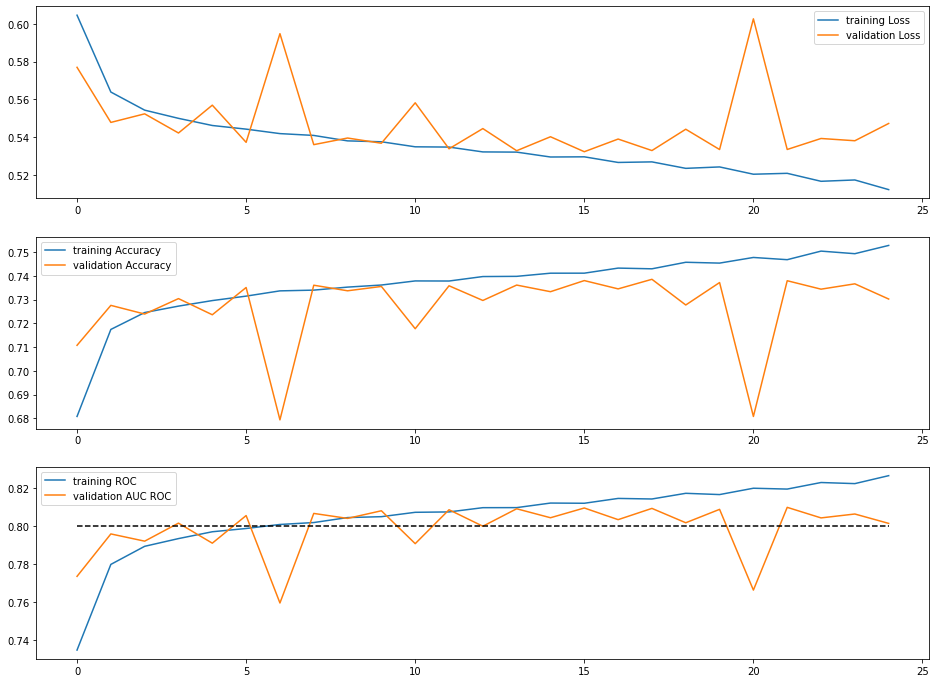

100%|██████████| 779/779 [00:04<00:00, 157.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

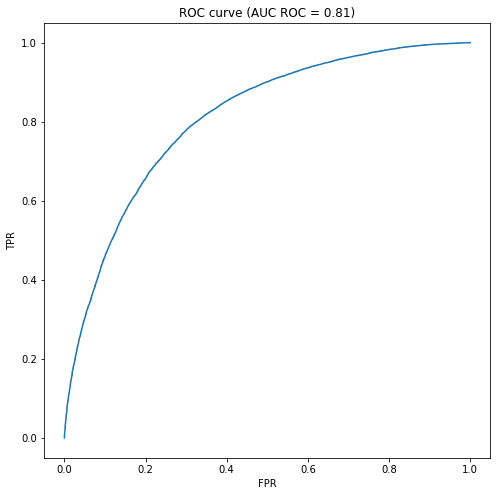

In [ ]:
class CNNSmall6(nn.Module):
    def __init__(self):
        super(CNNSmall6, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=True)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=True)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=True)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=True)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=True)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN6 = doExperiment(CNNSmall6(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="CNN_Small6_KS=mix_AUC={}.pth")

## Experiment 7
- previous one with larger head

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              96
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 31, 31]           4,128
       BatchNorm2d-4           [-1, 32, 31, 31]              64
            Conv2d-5           [-1, 48, 30, 30]           6,192
       BatchNorm2d-6           [-1, 48, 30, 30]              96
            Conv2d-7           [-1, 48, 28, 28]          20,784
       BatchNorm2d-8           [-1, 48, 28, 28]              96
            Conv2d-9           [-1, 64, 26, 26]          27,712
      BatchNorm2d-10           [-1, 64, 26, 26]             128
           Conv2d-11           [-1, 64, 22, 22]         102,464
      BatchNorm2d-12           [-1, 64, 22, 22]             128
           Conv2d-13           [-1, 64, 18, 18]         102,464
      BatchNorm2d-14           [-1, 64,

loss = 0.5971386863929885, accuracy : 0.6858459711074829, AUC ROC 0.7429695227248678: 100%|██████████| 7004/7004 [04:18<00:00, 27.07it/s]


TRAINING ; Loss: 0.5972 Acc: 0.6858 AUC ROC : 0.7430 Time taken : 258.91


100%|██████████| 779/779 [00:05<00:00, 153.94it/s]


VALIDATION : Loss: 0.6001 Acc: 0.6761 AUC ROC : 0.7638 Time taken : 5.08
Epoch 1/24
----------


loss = 0.560451981557267, accuracy : 0.7189040184020996, AUC ROC 0.7833760073398313: 100%|██████████| 7004/7004 [04:16<00:00, 27.36it/s]


TRAINING ; Loss: 0.5604 Acc: 0.7189 AUC ROC : 0.7834 Time taken : 256.34


100%|██████████| 779/779 [00:05<00:00, 148.96it/s]


VALIDATION : Loss: 0.5431 Acc: 0.7322 AUC ROC : 0.7993 Time taken : 5.26
Epoch 2/24
----------


loss = 0.551875387843166, accuracy : 0.7255848050117493, AUC ROC 0.7916409385595953: 100%|██████████| 7004/7004 [04:14<00:00, 27.48it/s]


TRAINING ; Loss: 0.5519 Acc: 0.7256 AUC ROC : 0.7917 Time taken : 255.17


100%|██████████| 779/779 [00:05<00:00, 148.66it/s]


VALIDATION : Loss: 0.6819 Acc: 0.6058 AUC ROC : 0.7086 Time taken : 5.27
Epoch 3/24
----------


loss = 0.5473227663593633, accuracy : 0.7287834882736206, AUC ROC 0.7958088455622561: 100%|██████████| 7004/7004 [04:14<00:00, 27.56it/s]


TRAINING ; Loss: 0.5473 Acc: 0.7288 AUC ROC : 0.7958 Time taken : 254.5


100%|██████████| 779/779 [00:05<00:00, 148.92it/s]


VALIDATION : Loss: 0.5377 Acc: 0.7367 AUC ROC : 0.8053 Time taken : 5.26
Epoch 4/24
----------


loss = 0.5430526351502963, accuracy : 0.732080340385437, AUC ROC 0.7999494914161989: 100%|██████████| 7004/7004 [04:07<00:00, 28.26it/s]


TRAINING ; Loss: 0.5431 Acc: 0.7321 AUC ROC : 0.7999 Time taken : 248.11


100%|██████████| 779/779 [00:04<00:00, 157.76it/s]


VALIDATION : Loss: 0.5426 Acc: 0.7329 AUC ROC : 0.8006 Time taken : 4.96
Epoch 5/24
----------


loss = 0.5411926025961127, accuracy : 0.7335825562477112, AUC ROC 0.801552142696953: 100%|██████████| 7004/7004 [04:09<00:00, 28.12it/s]


TRAINING ; Loss: 0.5412 Acc: 0.7336 AUC ROC : 0.8016 Time taken : 249.43


100%|██████████| 779/779 [00:05<00:00, 155.45it/s]


VALIDATION : Loss: 0.5304 Acc: 0.7410 AUC ROC : 0.8108 Time taken : 5.04
Epoch 6/24
----------


loss = 0.5377447876972812, accuracy : 0.7362098097801208, AUC ROC 0.8046976167365905: 100%|██████████| 7004/7004 [04:16<00:00, 27.35it/s]


TRAINING ; Loss: 0.5378 Acc: 0.7362 AUC ROC : 0.8047 Time taken : 256.4


100%|██████████| 779/779 [00:05<00:00, 148.73it/s]


VALIDATION : Loss: 0.5589 Acc: 0.7217 AUC ROC : 0.7991 Time taken : 5.26
Epoch 7/24
----------


loss = 0.5368939788043499, accuracy : 0.736881673336029, AUC ROC 0.805512766353492: 100%|██████████| 7004/7004 [04:14<00:00, 27.57it/s]


TRAINING ; Loss: 0.5369 Acc: 0.7369 AUC ROC : 0.8055 Time taken : 254.38


100%|██████████| 779/779 [00:05<00:00, 144.74it/s]


VALIDATION : Loss: 0.5288 Acc: 0.7422 AUC ROC : 0.8122 Time taken : 5.41
Epoch 8/24
----------


loss = 0.5338900493255684, accuracy : 0.7384285926818848, AUC ROC 0.8082340831791379: 100%|██████████| 7004/7004 [04:16<00:00, 27.34it/s]


TRAINING ; Loss: 0.5339 Acc: 0.7384 AUC ROC : 0.8082 Time taken : 256.56


100%|██████████| 779/779 [00:05<00:00, 150.32it/s]


VALIDATION : Loss: 0.5548 Acc: 0.7251 AUC ROC : 0.7986 Time taken : 5.21
Epoch 9/24
----------


loss = 0.5331115658496107, accuracy : 0.738997757434845, AUC ROC 0.8088141443366402: 100%|██████████| 7004/7004 [04:18<00:00, 27.14it/s]


TRAINING ; Loss: 0.5331 Acc: 0.7390 AUC ROC : 0.8088 Time taken : 258.39


100%|██████████| 779/779 [00:05<00:00, 150.22it/s]


VALIDATION : Loss: 0.5291 Acc: 0.7416 AUC ROC : 0.8128 Time taken : 5.21
Epoch 10/24
----------


loss = 0.5302439485447747, accuracy : 0.7407366037368774, AUC ROC 0.8113523877949617: 100%|██████████| 7004/7004 [04:15<00:00, 27.38it/s]


TRAINING ; Loss: 0.5303 Acc: 0.7407 AUC ROC : 0.8113 Time taken : 256.12


100%|██████████| 779/779 [00:05<00:00, 149.74it/s]


VALIDATION : Loss: 0.5439 Acc: 0.7309 AUC ROC : 0.7997 Time taken : 5.23
Epoch 11/24
----------


loss = 0.5299189215430191, accuracy : 0.7411383986473083, AUC ROC 0.81153233662002: 100%|██████████| 7004/7004 [04:17<00:00, 27.23it/s]


TRAINING ; Loss: 0.5299 Acc: 0.7411 AUC ROC : 0.8115 Time taken : 257.56


100%|██████████| 779/779 [00:05<00:00, 148.36it/s]


VALIDATION : Loss: 0.5286 Acc: 0.7416 AUC ROC : 0.8145 Time taken : 5.28
Epoch 12/24
----------


loss = 0.5266421901285648, accuracy : 0.7432745695114136, AUC ROC 0.8144447704446349: 100%|██████████| 7004/7004 [04:14<00:00, 27.54it/s]


TRAINING ; Loss: 0.5267 Acc: 0.7433 AUC ROC : 0.8144 Time taken : 254.68


100%|██████████| 779/779 [00:05<00:00, 152.36it/s]


VALIDATION : Loss: 0.5406 Acc: 0.7364 AUC ROC : 0.8078 Time taken : 5.14
Epoch 13/24
----------


loss = 0.5265611450842449, accuracy : 0.743040144443512, AUC ROC 0.8145846080503298: 100%|██████████| 7004/7004 [04:16<00:00, 27.35it/s]


TRAINING ; Loss: 0.5265 Acc: 0.7431 AUC ROC : 0.8146 Time taken : 256.4


100%|██████████| 779/779 [00:05<00:00, 152.19it/s]


VALIDATION : Loss: 0.5273 Acc: 0.7431 AUC ROC : 0.8145 Time taken : 5.14
Epoch 14/24
----------


loss = 0.5233264057465962, accuracy : 0.7455312609672546, AUC ROC 0.8172896549491582: 100%|██████████| 7004/7004 [04:14<00:00, 27.49it/s]


TRAINING ; Loss: 0.5233 Acc: 0.7455 AUC ROC : 0.8173 Time taken : 255.12


100%|██████████| 779/779 [00:05<00:00, 154.47it/s]


VALIDATION : Loss: 0.5409 Acc: 0.7375 AUC ROC : 0.8077 Time taken : 5.07
Epoch 15/24
----------


loss = 0.5231304447863783, accuracy : 0.7456941604614258, AUC ROC 0.8173904213323016: 100%|██████████| 7004/7004 [04:10<00:00, 27.99it/s]


TRAINING ; Loss: 0.5231 Acc: 0.7457 AUC ROC : 0.8174 Time taken : 250.53


100%|██████████| 779/779 [00:04<00:00, 156.74it/s]


VALIDATION : Loss: 0.5252 Acc: 0.7446 AUC ROC : 0.8157 Time taken : 4.99
Epoch 16/24
----------


loss = 0.5193600187727383, accuracy : 0.7480892539024353, AUC ROC 0.820583103369111: 100%|██████████| 7004/7004 [04:18<00:00, 27.08it/s]


TRAINING ; Loss: 0.5194 Acc: 0.7481 AUC ROC : 0.8206 Time taken : 259.03


100%|██████████| 779/779 [00:05<00:00, 149.24it/s]


VALIDATION : Loss: 0.5954 Acc: 0.7160 AUC ROC : 0.8014 Time taken : 5.24
Epoch 17/24
----------


loss = 0.5198709018996783, accuracy : 0.7478214502334595, AUC ROC 0.8202263146622784: 100%|██████████| 7004/7004 [04:16<00:00, 27.26it/s]


TRAINING ; Loss: 0.5198 Acc: 0.7478 AUC ROC : 0.8202 Time taken : 257.29


100%|██████████| 779/779 [00:05<00:00, 152.19it/s]


VALIDATION : Loss: 0.5274 Acc: 0.7437 AUC ROC : 0.8142 Time taken : 5.14
Epoch 18/24
----------


loss = 0.5154064840248653, accuracy : 0.7506919503211975, AUC ROC 0.8237435111472367: 100%|██████████| 7004/7004 [04:19<00:00, 26.99it/s]


TRAINING ; Loss: 0.5154 Acc: 0.7507 AUC ROC : 0.8237 Time taken : 259.82


100%|██████████| 779/779 [00:05<00:00, 150.36it/s]


VALIDATION : Loss: 0.5417 Acc: 0.7399 AUC ROC : 0.8080 Time taken : 5.21
Epoch 19/24
----------


loss = 0.5161537949613162, accuracy : 0.7495959997177124, AUC ROC 0.8231048955640765: 100%|██████████| 7004/7004 [04:20<00:00, 26.84it/s]


TRAINING ; Loss: 0.5161 Acc: 0.7496 AUC ROC : 0.8231 Time taken : 261.26


100%|██████████| 779/779 [00:05<00:00, 149.07it/s]


VALIDATION : Loss: 0.5314 Acc: 0.7428 AUC ROC : 0.8131 Time taken : 5.25
Epoch 20/24
----------


loss = 0.5109370056433337, accuracy : 0.7527745366096497, AUC ROC 0.8273111294133809: 100%|██████████| 7004/7004 [04:19<00:00, 27.02it/s]


TRAINING ; Loss: 0.5109 Acc: 0.7528 AUC ROC : 0.8273 Time taken : 259.58


100%|██████████| 779/779 [00:05<00:00, 148.89it/s]


VALIDATION : Loss: 0.8241 Acc: 0.6552 AUC ROC : 0.7853 Time taken : 5.26
Epoch 21/24
----------


loss = 0.5116041538757937, accuracy : 0.7524999976158142, AUC ROC 0.82682526471288: 100%|██████████| 7004/7004 [04:19<00:00, 27.01it/s]


TRAINING ; Loss: 0.5116 Acc: 0.7525 AUC ROC : 0.8268 Time taken : 259.64


100%|██████████| 779/779 [00:05<00:00, 151.20it/s]


VALIDATION : Loss: 0.5325 Acc: 0.7415 AUC ROC : 0.8138 Time taken : 5.18
Epoch 22/24
----------


loss = 0.5057716490030288, accuracy : 0.7556115984916687, AUC ROC 0.8313724712668271: 100%|██████████| 7004/7004 [04:18<00:00, 27.10it/s]


TRAINING ; Loss: 0.5058 Acc: 0.7556 AUC ROC : 0.8314 Time taken : 258.8


100%|██████████| 779/779 [00:05<00:00, 149.78it/s]


VALIDATION : Loss: 1.1761 Acc: 0.6177 AUC ROC : 0.7764 Time taken : 5.23
Epoch 23/24
----------


loss = 0.5068922290503979, accuracy : 0.7552388310432434, AUC ROC 0.8305049807631318: 100%|██████████| 7004/7004 [04:17<00:00, 27.22it/s]


TRAINING ; Loss: 0.5069 Acc: 0.7552 AUC ROC : 0.8305 Time taken : 257.69


100%|██████████| 779/779 [00:05<00:00, 150.66it/s]


VALIDATION : Loss: 0.5349 Acc: 0.7411 AUC ROC : 0.8112 Time taken : 5.19
Epoch 24/24
----------


loss = 0.49986598734344756, accuracy : 0.7590914964675903, AUC ROC 0.8358438417570153: 100%|██████████| 7004/7004 [04:18<00:00, 27.15it/s]


TRAINING ; Loss: 0.4999 Acc: 0.7591 AUC ROC : 0.8358 Time taken : 258.35


100%|██████████| 779/779 [00:05<00:00, 149.19it/s]


VALIDATION : Loss: 1.5094 Acc: 0.6073 AUC ROC : 0.7694 Time taken : 5.25
Training complete in 108m 60s


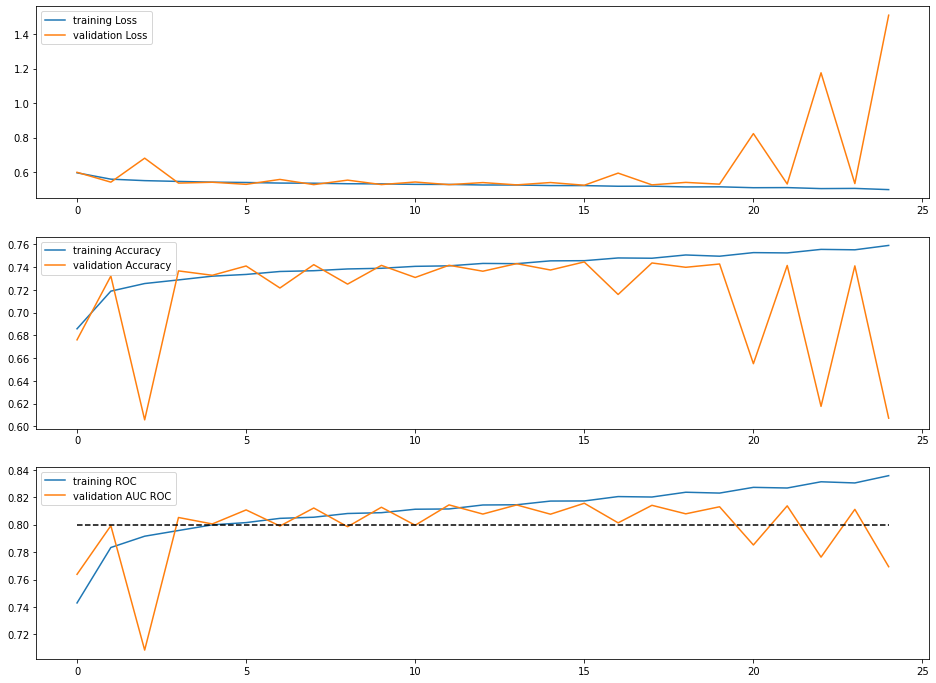

100%|██████████| 779/779 [00:04<00:00, 156.77it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

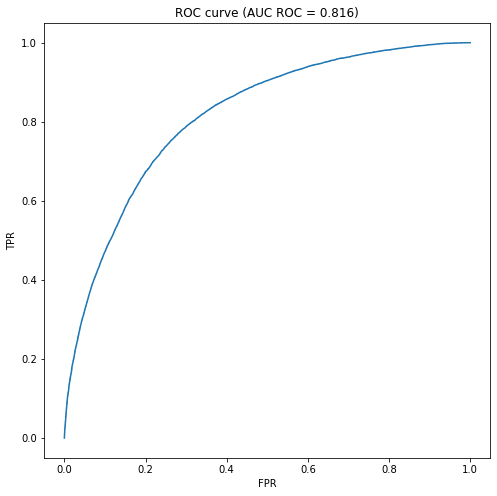

In [ ]:
class CNNSmall7_larger_head(nn.Module):
    def __init__(self):
        super(CNNSmall7_larger_head, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=True)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=True)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=True)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=True)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=True)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 128, bias=True)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        fc1 = F.relu(self.fc1(flat1))
        logits = self.fc2(fc1)
        return self.sigmoid(logits)

CNN7 = doExperiment(CNNSmall7_larger_head(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="CNN_Small7_KS=mix_AUC={}.pth")

## Experiment 8 (CNN PReLU)

- https://arxiv.org/pdf/1502.01852v1.pdf

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             PReLU-3           [-1, 32, 32, 32]               1
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
             PReLU-6           [-1, 32, 31, 31]               1
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
             PReLU-9           [-1, 48, 30, 30]               1
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
            PReLU-12           [-1, 48, 28, 28]               1
           Conv2d-13           [-1, 64, 26, 26]          27,648
      BatchNorm2d-14           [-1, 64,

loss = 0.608245501343693, accuracy : 0.6769933104515076, AUC ROC 0.730625634073263: 100%|██████████| 7004/7004 [04:32<00:00, 25.70it/s]


TRAINING ; Loss: 0.6082 Acc: 0.6770 AUC ROC : 0.7306 Time taken : 272.65


100%|██████████| 779/779 [00:04<00:00, 166.78it/s]


VALIDATION : Loss: 0.6039 Acc: 0.6828 AUC ROC : 0.7512 Time taken : 4.7
Epoch 1/24
----------


loss = 0.5639920496940612, accuracy : 0.7170692086219788, AUC ROC 0.7796917366954448: 100%|██████████| 7004/7004 [04:36<00:00, 25.34it/s]


TRAINING ; Loss: 0.5640 Acc: 0.7171 AUC ROC : 0.7797 Time taken : 276.69


100%|██████████| 779/779 [00:04<00:00, 165.76it/s]


VALIDATION : Loss: 0.5449 Acc: 0.7318 AUC ROC : 0.7981 Time taken : 4.73
Epoch 2/24
----------


loss = 0.5545661638123649, accuracy : 0.7240892648696899, AUC ROC 0.7891297035865058: 100%|██████████| 7004/7004 [04:27<00:00, 26.23it/s]


TRAINING ; Loss: 0.5545 Acc: 0.7241 AUC ROC : 0.7892 Time taken : 267.35


100%|██████████| 779/779 [00:04<00:00, 162.79it/s]


VALIDATION : Loss: 0.9268 Acc: 0.5351 AUC ROC : 0.7792 Time taken : 4.81
Epoch 3/24
----------


loss = 0.5493462625741958, accuracy : 0.7279397249221802, AUC ROC 0.794024332576122: 100%|██████████| 7004/7004 [04:27<00:00, 26.15it/s]


TRAINING ; Loss: 0.5493 Acc: 0.7280 AUC ROC : 0.7940 Time taken : 268.17


100%|██████████| 779/779 [00:04<00:00, 173.81it/s]


VALIDATION : Loss: 0.5438 Acc: 0.7327 AUC ROC : 0.8015 Time taken : 4.51
Epoch 4/24
----------


loss = 0.54480727277909, accuracy : 0.7309240698814392, AUC ROC 0.7983164134745695: 100%|██████████| 7004/7004 [04:35<00:00, 25.39it/s]


TRAINING ; Loss: 0.5448 Acc: 0.7309 AUC ROC : 0.7983 Time taken : 276.21


100%|██████████| 779/779 [00:04<00:00, 163.69it/s]


VALIDATION : Loss: 0.6501 Acc: 0.5634 AUC ROC : 0.7463 Time taken : 4.79
Epoch 5/24
----------


loss = 0.5425069566624505, accuracy : 0.7326942086219788, AUC ROC 0.8004219928312425: 100%|██████████| 7004/7004 [04:34<00:00, 25.55it/s]


TRAINING ; Loss: 0.5425 Acc: 0.7327 AUC ROC : 0.8004 Time taken : 274.4


100%|██████████| 779/779 [00:04<00:00, 166.50it/s]


VALIDATION : Loss: 0.5394 Acc: 0.7332 AUC ROC : 0.8067 Time taken : 4.71
Epoch 6/24
----------


loss = 0.5390359516314098, accuracy : 0.7352566719055176, AUC ROC 0.8036052751856351: 100%|██████████| 7004/7004 [04:27<00:00, 26.22it/s]


TRAINING ; Loss: 0.5390 Acc: 0.7353 AUC ROC : 0.8036 Time taken : 267.4


100%|██████████| 779/779 [00:04<00:00, 174.38it/s]


VALIDATION : Loss: 0.5488 Acc: 0.7271 AUC ROC : 0.7950 Time taken : 4.49
Epoch 7/24
----------


loss = 0.5379944174247129, accuracy : 0.7356294393539429, AUC ROC 0.8045661170152567: 100%|██████████| 7004/7004 [04:25<00:00, 26.39it/s]


TRAINING ; Loss: 0.5380 Acc: 0.7356 AUC ROC : 0.8046 Time taken : 265.69


100%|██████████| 779/779 [00:04<00:00, 169.90it/s]


VALIDATION : Loss: 0.5332 Acc: 0.7393 AUC ROC : 0.8086 Time taken : 4.61
Epoch 8/24
----------


loss = 0.5347979292699269, accuracy : 0.7378638386726379, AUC ROC 0.8074730949869695: 100%|██████████| 7004/7004 [04:35<00:00, 25.42it/s]


TRAINING ; Loss: 0.5348 Acc: 0.7379 AUC ROC : 0.8075 Time taken : 275.86


100%|██████████| 779/779 [00:04<00:00, 160.59it/s]


VALIDATION : Loss: 0.5490 Acc: 0.7264 AUC ROC : 0.7964 Time taken : 4.88
Epoch 9/24
----------


loss = 0.5344589560457639, accuracy : 0.7383325695991516, AUC ROC 0.8076925391077255: 100%|██████████| 7004/7004 [04:38<00:00, 25.18it/s]


TRAINING ; Loss: 0.5344 Acc: 0.7384 AUC ROC : 0.8077 Time taken : 278.52


100%|██████████| 779/779 [00:04<00:00, 162.24it/s]


VALIDATION : Loss: 0.5304 Acc: 0.7417 AUC ROC : 0.8109 Time taken : 4.83
Epoch 10/24
----------


loss = 0.5311602364054748, accuracy : 0.7407053709030151, AUC ROC 0.8106120548182638: 100%|██████████| 7004/7004 [04:29<00:00, 25.96it/s]


TRAINING ; Loss: 0.5312 Acc: 0.7407 AUC ROC : 0.8106 Time taken : 270.14


100%|██████████| 779/779 [00:04<00:00, 167.54it/s]


VALIDATION : Loss: 0.7049 Acc: 0.5229 AUC ROC : 0.7324 Time taken : 4.68
Epoch 11/24
----------


loss = 0.531098187067679, accuracy : 0.7403548955917358, AUC ROC 0.8106840115247749: 100%|██████████| 7004/7004 [04:30<00:00, 25.88it/s]


TRAINING ; Loss: 0.5311 Acc: 0.7404 AUC ROC : 0.8107 Time taken : 270.96


100%|██████████| 779/779 [00:04<00:00, 170.18it/s]


VALIDATION : Loss: 0.5294 Acc: 0.7401 AUC ROC : 0.8122 Time taken : 4.6
Epoch 12/24
----------


loss = 0.5276318306497165, accuracy : 0.7425892949104309, AUC ROC 0.8137115439816527: 100%|██████████| 7004/7004 [04:35<00:00, 25.41it/s]


TRAINING ; Loss: 0.5277 Acc: 0.7426 AUC ROC : 0.8137 Time taken : 275.99


100%|██████████| 779/779 [00:04<00:00, 164.50it/s]


VALIDATION : Loss: 0.5504 Acc: 0.7337 AUC ROC : 0.7989 Time taken : 4.76
Epoch 13/24
----------


loss = 0.5279261979205268, accuracy : 0.7422187328338623, AUC ROC 0.8134887386200574: 100%|██████████| 7004/7004 [04:32<00:00, 25.72it/s]


TRAINING ; Loss: 0.5279 Acc: 0.7422 AUC ROC : 0.8135 Time taken : 272.58


100%|██████████| 779/779 [00:04<00:00, 165.94it/s]


VALIDATION : Loss: 0.5336 Acc: 0.7408 AUC ROC : 0.8112 Time taken : 4.72
Epoch 14/24
----------


loss = 0.5241482176567827, accuracy : 0.7453415393829346, AUC ROC 0.816663765084899: 100%|██████████| 7004/7004 [04:31<00:00, 25.76it/s]


TRAINING ; Loss: 0.5241 Acc: 0.7454 AUC ROC : 0.8167 Time taken : 272.23


100%|██████████| 779/779 [00:04<00:00, 164.59it/s]


VALIDATION : Loss: 0.5560 Acc: 0.7186 AUC ROC : 0.7970 Time taken : 4.76
Epoch 15/24
----------


loss = 0.5247500894154821, accuracy : 0.7445223331451416, AUC ROC 0.8162329256071614: 100%|██████████| 7004/7004 [04:34<00:00, 25.50it/s]


TRAINING ; Loss: 0.5247 Acc: 0.7445 AUC ROC : 0.8162 Time taken : 275.0


100%|██████████| 779/779 [00:04<00:00, 162.32it/s]


VALIDATION : Loss: 0.5281 Acc: 0.7431 AUC ROC : 0.8132 Time taken : 4.83
Epoch 16/24
----------


loss = 0.5204539404426303, accuracy : 0.7471539974212646, AUC ROC 0.8198587075119129: 100%|██████████| 7004/7004 [04:27<00:00, 26.19it/s]


TRAINING ; Loss: 0.5204 Acc: 0.7472 AUC ROC : 0.8199 Time taken : 267.76


100%|██████████| 779/779 [00:04<00:00, 171.37it/s]


VALIDATION : Loss: 0.7717 Acc: 0.5139 AUC ROC : 0.5259 Time taken : 4.57
Epoch 17/24
----------


loss = 0.5211173013108117, accuracy : 0.746977686882019, AUC ROC 0.8192851584620986: 100%|██████████| 7004/7004 [04:26<00:00, 26.29it/s]


TRAINING ; Loss: 0.5211 Acc: 0.7470 AUC ROC : 0.8193 Time taken : 266.78


100%|██████████| 779/779 [00:04<00:00, 172.58it/s]


VALIDATION : Loss: 0.5296 Acc: 0.7413 AUC ROC : 0.8118 Time taken : 4.54
Epoch 18/24
----------


loss = 0.5162792218497821, accuracy : 0.7503057718276978, AUC ROC 0.823224596414349: 100%|██████████| 7004/7004 [04:25<00:00, 26.36it/s]


TRAINING ; Loss: 0.5163 Acc: 0.7503 AUC ROC : 0.8232 Time taken : 266.07


100%|██████████| 779/779 [00:04<00:00, 174.00it/s]


VALIDATION : Loss: 0.6002 Acc: 0.6878 AUC ROC : 0.7844 Time taken : 4.5
Epoch 19/24
----------


loss = 0.5176536208518914, accuracy : 0.7492812275886536, AUC ROC 0.8221536100191754: 100%|██████████| 7004/7004 [04:28<00:00, 26.11it/s]


TRAINING ; Loss: 0.5176 Acc: 0.7493 AUC ROC : 0.8222 Time taken : 268.51


100%|██████████| 779/779 [00:04<00:00, 170.64it/s]


VALIDATION : Loss: 0.5309 Acc: 0.7397 AUC ROC : 0.8124 Time taken : 4.59
Epoch 20/24
----------


loss = 0.5116164080841201, accuracy : 0.753250002861023, AUC ROC 0.8271051338749285: 100%|██████████| 7004/7004 [04:26<00:00, 26.25it/s]


TRAINING ; Loss: 0.5116 Acc: 0.7532 AUC ROC : 0.8271 Time taken : 267.09


100%|██████████| 779/779 [00:04<00:00, 174.64it/s]


VALIDATION : Loss: 0.5609 Acc: 0.7132 AUC ROC : 0.7923 Time taken : 4.49
Epoch 21/24
----------


loss = 0.5129102737648147, accuracy : 0.7528504133224487, AUC ROC 0.825999673318797: 100%|██████████| 7004/7004 [04:24<00:00, 26.48it/s]


TRAINING ; Loss: 0.5129 Acc: 0.7529 AUC ROC : 0.8260 Time taken : 264.81


100%|██████████| 779/779 [00:04<00:00, 173.58it/s]


VALIDATION : Loss: 0.5322 Acc: 0.7412 AUC ROC : 0.8114 Time taken : 4.51
Epoch 22/24
----------


loss = 0.5061064020608153, accuracy : 0.7566205263137817, AUC ROC 0.8314050999625784: 100%|██████████| 7004/7004 [04:23<00:00, 26.60it/s]


TRAINING ; Loss: 0.5061 Acc: 0.7566 AUC ROC : 0.8314 Time taken : 263.62


100%|██████████| 779/779 [00:04<00:00, 174.05it/s]


VALIDATION : Loss: 0.5413 Acc: 0.7326 AUC ROC : 0.8032 Time taken : 4.5
Epoch 23/24
----------


loss = 0.5074030861088208, accuracy : 0.7560245394706726, AUC ROC 0.8303840080779962: 100%|██████████| 7004/7004 [04:22<00:00, 26.72it/s]


TRAINING ; Loss: 0.5074 Acc: 0.7560 AUC ROC : 0.8304 Time taken : 262.45


100%|██████████| 779/779 [00:04<00:00, 175.03it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7379 AUC ROC : 0.8080 Time taken : 4.47
Epoch 24/24
----------


loss = 0.499355548198734, accuracy : 0.760558009147644, AUC ROC 0.8365913407437645: 100%|██████████| 7004/7004 [04:23<00:00, 26.61it/s]


TRAINING ; Loss: 0.4994 Acc: 0.7605 AUC ROC : 0.8366 Time taken : 263.54


100%|██████████| 779/779 [00:04<00:00, 171.20it/s]


VALIDATION : Loss: 0.5531 Acc: 0.7325 AUC ROC : 0.8000 Time taken : 4.58
Training complete in 114m 27s


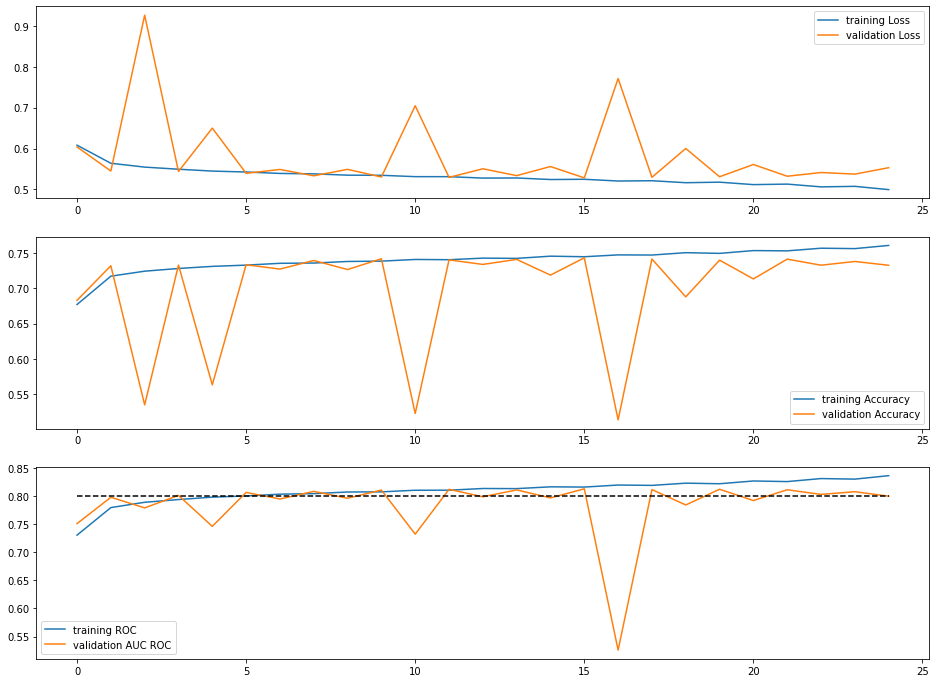

100%|██████████| 779/779 [00:04<00:00, 173.02it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

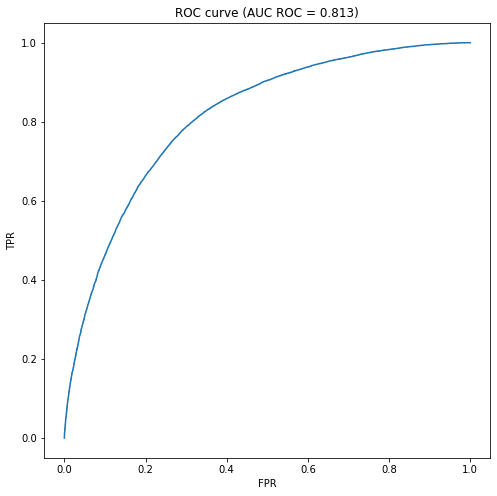

In [ ]:
class CNNSmall8(nn.Module):
    def __init__(self, param_prelu=1):
        super(CNNSmall8, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activ1 = nn.PReLU(param_prelu)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activ2 = nn.PReLU(param_prelu)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activ3 = nn.PReLU(param_prelu)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activ4 = nn.PReLU(param_prelu)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activ5 = nn.PReLU(param_prelu)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activ6 = nn.PReLU(param_prelu)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activ7 = nn.PReLU(param_prelu)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activ1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activ2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activ3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activ4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activ5(self.conv5_bn(self.conv5(conv4)))
        conv6 = self.activ6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activ7(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN8 = doExperiment(CNNSmall8(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="CNNSmall8_larger_head_AUC={}.pth")

## Experiment 9
bias = True

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              96
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             PReLU-3           [-1, 32, 32, 32]               1
            Conv2d-4           [-1, 32, 31, 31]           4,128
       BatchNorm2d-5           [-1, 32, 31, 31]              64
             PReLU-6           [-1, 32, 31, 31]               1
            Conv2d-7           [-1, 48, 30, 30]           6,192
       BatchNorm2d-8           [-1, 48, 30, 30]              96
             PReLU-9           [-1, 48, 30, 30]               1
           Conv2d-10           [-1, 48, 28, 28]          20,784
      BatchNorm2d-11           [-1, 48, 28, 28]              96
            PReLU-12           [-1, 48, 28, 28]               1
           Conv2d-13           [-1, 64, 26, 26]          27,712
      BatchNorm2d-14           [-1, 64,

loss = 0.6103181775680611, accuracy : 0.6740044355392456, AUC ROC 0.7277440396404655: 100%|██████████| 7004/7004 [04:40<00:00, 24.99it/s]


TRAINING ; Loss: 0.6103 Acc: 0.6740 AUC ROC : 0.7278 Time taken : 280.46


100%|██████████| 779/779 [00:04<00:00, 156.05it/s]


VALIDATION : Loss: 0.6251 Acc: 0.6412 AUC ROC : 0.7458 Time taken : 5.02
Epoch 1/24
----------


loss = 0.5634631428122521, accuracy : 0.7171071171760559, AUC ROC 0.7803978250576834: 100%|██████████| 7004/7004 [04:41<00:00, 24.87it/s]


TRAINING ; Loss: 0.5635 Acc: 0.7171 AUC ROC : 0.7804 Time taken : 281.9


100%|██████████| 779/779 [00:05<00:00, 151.79it/s]


VALIDATION : Loss: 0.5529 Acc: 0.7253 AUC ROC : 0.7946 Time taken : 5.16
Epoch 2/24
----------


loss = 0.5534455342079911, accuracy : 0.724745512008667, AUC ROC 0.7902196469571261: 100%|██████████| 7004/7004 [04:44<00:00, 24.60it/s]


TRAINING ; Loss: 0.5535 Acc: 0.7247 AUC ROC : 0.7902 Time taken : 285.07


100%|██████████| 779/779 [00:05<00:00, 150.49it/s]


VALIDATION : Loss: 0.5603 Acc: 0.7181 AUC ROC : 0.7856 Time taken : 5.2
Epoch 3/24
----------


loss = 0.5489481844689165, accuracy : 0.7279576063156128, AUC ROC 0.7945180702398749: 100%|██████████| 7004/7004 [04:42<00:00, 24.77it/s]


TRAINING ; Loss: 0.5489 Acc: 0.7280 AUC ROC : 0.7945 Time taken : 283.08


100%|██████████| 779/779 [00:05<00:00, 147.72it/s]


VALIDATION : Loss: 0.5411 Acc: 0.7342 AUC ROC : 0.8024 Time taken : 5.3
Epoch 4/24
----------


loss = 0.5447463196047715, accuracy : 0.7311941981315613, AUC ROC 0.7984000637112245: 100%|██████████| 7004/7004 [04:42<00:00, 24.81it/s]


TRAINING ; Loss: 0.5448 Acc: 0.7312 AUC ROC : 0.7984 Time taken : 282.68


100%|██████████| 779/779 [00:05<00:00, 153.20it/s]


VALIDATION : Loss: 0.5523 Acc: 0.7277 AUC ROC : 0.7965 Time taken : 5.11
Epoch 5/24
----------


loss = 0.5425294093106474, accuracy : 0.7327589392662048, AUC ROC 0.8004638586435839: 100%|██████████| 7004/7004 [04:41<00:00, 24.88it/s]


TRAINING ; Loss: 0.5425 Acc: 0.7327 AUC ROC : 0.8004 Time taken : 281.78


100%|██████████| 779/779 [00:05<00:00, 151.50it/s]


VALIDATION : Loss: 0.5354 Acc: 0.7369 AUC ROC : 0.8076 Time taken : 5.17
Epoch 6/24
----------


loss = 0.5395253777631691, accuracy : 0.7349754571914673, AUC ROC 0.8032049135455118: 100%|██████████| 7004/7004 [04:39<00:00, 25.06it/s]


TRAINING ; Loss: 0.5395 Acc: 0.7350 AUC ROC : 0.8032 Time taken : 279.83


100%|██████████| 779/779 [00:05<00:00, 152.13it/s]


VALIDATION : Loss: 0.5411 Acc: 0.7331 AUC ROC : 0.8022 Time taken : 5.15
Epoch 7/24
----------


loss = 0.538035740252052, accuracy : 0.7354955077171326, AUC ROC 0.8044877931478638: 100%|██████████| 7004/7004 [04:38<00:00, 25.19it/s]


TRAINING ; Loss: 0.5380 Acc: 0.7355 AUC ROC : 0.8045 Time taken : 278.42


100%|██████████| 779/779 [00:05<00:00, 152.39it/s]


VALIDATION : Loss: 0.5324 Acc: 0.7394 AUC ROC : 0.8094 Time taken : 5.14
Epoch 8/24
----------


loss = 0.5351211992672511, accuracy : 0.7378928661346436, AUC ROC 0.8072659261535231: 100%|██████████| 7004/7004 [04:38<00:00, 25.18it/s]


TRAINING ; Loss: 0.5351 Acc: 0.7379 AUC ROC : 0.8073 Time taken : 278.49


100%|██████████| 779/779 [00:05<00:00, 154.48it/s]


VALIDATION : Loss: 0.5419 Acc: 0.7338 AUC ROC : 0.8028 Time taken : 5.07
Epoch 9/24
----------


loss = 0.5344804258900029, accuracy : 0.7381517887115479, AUC ROC 0.807719267373463: 100%|██████████| 7004/7004 [04:38<00:00, 25.18it/s]


TRAINING ; Loss: 0.5345 Acc: 0.7382 AUC ROC : 0.8077 Time taken : 278.42


100%|██████████| 779/779 [00:05<00:00, 153.02it/s]


VALIDATION : Loss: 0.5326 Acc: 0.7385 AUC ROC : 0.8112 Time taken : 5.12
Epoch 10/24
----------


loss = 0.5317572382262775, accuracy : 0.7397946119308472, AUC ROC 0.8100718530396169: 100%|██████████| 7004/7004 [04:38<00:00, 25.17it/s]


TRAINING ; Loss: 0.5317 Acc: 0.7398 AUC ROC : 0.8101 Time taken : 278.55


100%|██████████| 779/779 [00:05<00:00, 155.34it/s]


VALIDATION : Loss: 0.5367 Acc: 0.7362 AUC ROC : 0.8055 Time taken : 5.04
Epoch 11/24
----------


loss = 0.5314643873742648, accuracy : 0.7399709820747375, AUC ROC 0.8104005968040817: 100%|██████████| 7004/7004 [04:40<00:00, 25.00it/s]


TRAINING ; Loss: 0.5315 Acc: 0.7400 AUC ROC : 0.8104 Time taken : 280.46


100%|██████████| 779/779 [00:05<00:00, 150.81it/s]


VALIDATION : Loss: 0.5291 Acc: 0.7419 AUC ROC : 0.8123 Time taken : 5.19
Epoch 12/24
----------


loss = 0.5281577727496624, accuracy : 0.7422611713409424, AUC ROC 0.8131905683097705: 100%|██████████| 7004/7004 [04:41<00:00, 24.92it/s]


TRAINING ; Loss: 0.5282 Acc: 0.7423 AUC ROC : 0.8132 Time taken : 281.41


100%|██████████| 779/779 [00:05<00:00, 147.63it/s]


VALIDATION : Loss: 0.5360 Acc: 0.7368 AUC ROC : 0.8063 Time taken : 5.31
Epoch 13/24
----------


loss = 0.528142297161477, accuracy : 0.7422477602958679, AUC ROC 0.813296086860517: 100%|██████████| 7004/7004 [04:42<00:00, 24.79it/s]


TRAINING ; Loss: 0.5282 Acc: 0.7422 AUC ROC : 0.8133 Time taken : 282.88


100%|██████████| 779/779 [00:05<00:00, 153.38it/s]


VALIDATION : Loss: 0.5294 Acc: 0.7421 AUC ROC : 0.8120 Time taken : 5.1
Epoch 14/24
----------


loss = 0.524710077809436, accuracy : 0.7450000047683716, AUC ROC 0.8162046810123588: 100%|██████████| 7004/7004 [04:40<00:00, 24.95it/s]


TRAINING ; Loss: 0.5247 Acc: 0.7450 AUC ROC : 0.8162 Time taken : 281.02


100%|██████████| 779/779 [00:05<00:00, 151.29it/s]


VALIDATION : Loss: 0.5385 Acc: 0.7332 AUC ROC : 0.8045 Time taken : 5.17
Epoch 15/24
----------


loss = 0.5250070387508188, accuracy : 0.7444576025009155, AUC ROC 0.8159238027013576: 100%|██████████| 7004/7004 [04:41<00:00, 24.85it/s]


TRAINING ; Loss: 0.5250 Acc: 0.7445 AUC ROC : 0.8159 Time taken : 282.19


100%|██████████| 779/779 [00:05<00:00, 147.29it/s]


VALIDATION : Loss: 0.5313 Acc: 0.7413 AUC ROC : 0.8126 Time taken : 5.32
Epoch 16/24
----------


loss = 0.5205635718022074, accuracy : 0.747341513633728, AUC ROC 0.8196385178447214: 100%|██████████| 7004/7004 [04:38<00:00, 25.17it/s]


TRAINING ; Loss: 0.5206 Acc: 0.7473 AUC ROC : 0.8196 Time taken : 278.64


100%|██████████| 779/779 [00:05<00:00, 155.47it/s]


VALIDATION : Loss: 0.5392 Acc: 0.7354 AUC ROC : 0.8070 Time taken : 5.04
Epoch 17/24
----------


loss = 0.5212446217962674, accuracy : 0.746912956237793, AUC ROC 0.8190455196870825: 100%|██████████| 7004/7004 [04:39<00:00, 25.02it/s]


TRAINING ; Loss: 0.5212 Acc: 0.7469 AUC ROC : 0.8191 Time taken : 280.26


100%|██████████| 779/779 [00:05<00:00, 150.47it/s]


VALIDATION : Loss: 0.5297 Acc: 0.7406 AUC ROC : 0.8120 Time taken : 5.21
Epoch 18/24
----------


loss = 0.5158014346190861, accuracy : 0.7503973245620728, AUC ROC 0.8235662290197359: 100%|██████████| 7004/7004 [04:42<00:00, 24.80it/s]


TRAINING ; Loss: 0.5158 Acc: 0.7504 AUC ROC : 0.8236 Time taken : 282.76


100%|██████████| 779/779 [00:05<00:00, 151.81it/s]


VALIDATION : Loss: 0.5356 Acc: 0.7370 AUC ROC : 0.8089 Time taken : 5.16
Epoch 19/24
----------


loss = 0.5169210175573826, accuracy : 0.7492455244064331, AUC ROC 0.8227191899446649: 100%|██████████| 7004/7004 [04:39<00:00, 25.09it/s]


TRAINING ; Loss: 0.5169 Acc: 0.7493 AUC ROC : 0.8227 Time taken : 279.43


100%|██████████| 779/779 [00:05<00:00, 152.05it/s]


VALIDATION : Loss: 0.5310 Acc: 0.7408 AUC ROC : 0.8110 Time taken : 5.15
Epoch 20/24
----------


loss = 0.5107373076379299, accuracy : 0.7536294460296631, AUC ROC 0.8277042671590616: 100%|██████████| 7004/7004 [04:39<00:00, 25.04it/s]


TRAINING ; Loss: 0.5107 Acc: 0.7536 AUC ROC : 0.8277 Time taken : 279.99


100%|██████████| 779/779 [00:05<00:00, 155.00it/s]


VALIDATION : Loss: 0.5578 Acc: 0.7230 AUC ROC : 0.7944 Time taken : 5.05
Epoch 21/24
----------


loss = 0.5115108252423151, accuracy : 0.7529687285423279, AUC ROC 0.8270324716758635: 100%|██████████| 7004/7004 [04:38<00:00, 25.16it/s]


TRAINING ; Loss: 0.5115 Acc: 0.7530 AUC ROC : 0.8270 Time taken : 278.72


100%|██████████| 779/779 [00:05<00:00, 150.98it/s]


VALIDATION : Loss: 0.5351 Acc: 0.7391 AUC ROC : 0.8095 Time taken : 5.18
Epoch 22/24
----------


loss = 0.5044161479430539, accuracy : 0.7579308152198792, AUC ROC 0.8327006106686241: 100%|██████████| 7004/7004 [04:39<00:00, 25.08it/s]


TRAINING ; Loss: 0.5044 Acc: 0.7579 AUC ROC : 0.8327 Time taken : 279.59


100%|██████████| 779/779 [00:05<00:00, 153.61it/s]


VALIDATION : Loss: 0.5411 Acc: 0.7357 AUC ROC : 0.8048 Time taken : 5.1
Epoch 23/24
----------


loss = 0.505663223790271, accuracy : 0.7570289969444275, AUC ROC 0.8316343890285874: 100%|██████████| 7004/7004 [04:39<00:00, 25.04it/s]


TRAINING ; Loss: 0.5057 Acc: 0.7570 AUC ROC : 0.8316 Time taken : 280.06


100%|██████████| 779/779 [00:05<00:00, 150.79it/s]


VALIDATION : Loss: 0.5376 Acc: 0.7380 AUC ROC : 0.8064 Time taken : 5.19
Epoch 24/24
----------


loss = 0.497085026374885, accuracy : 0.7621808052062988, AUC ROC 0.8382586624065717: 100%|██████████| 7004/7004 [04:39<00:00, 25.02it/s]


TRAINING ; Loss: 0.4971 Acc: 0.7622 AUC ROC : 0.8383 Time taken : 280.22


100%|██████████| 779/779 [00:05<00:00, 152.22it/s]


VALIDATION : Loss: 0.5470 Acc: 0.7299 AUC ROC : 0.7990 Time taken : 5.15
Training complete in 119m 5s


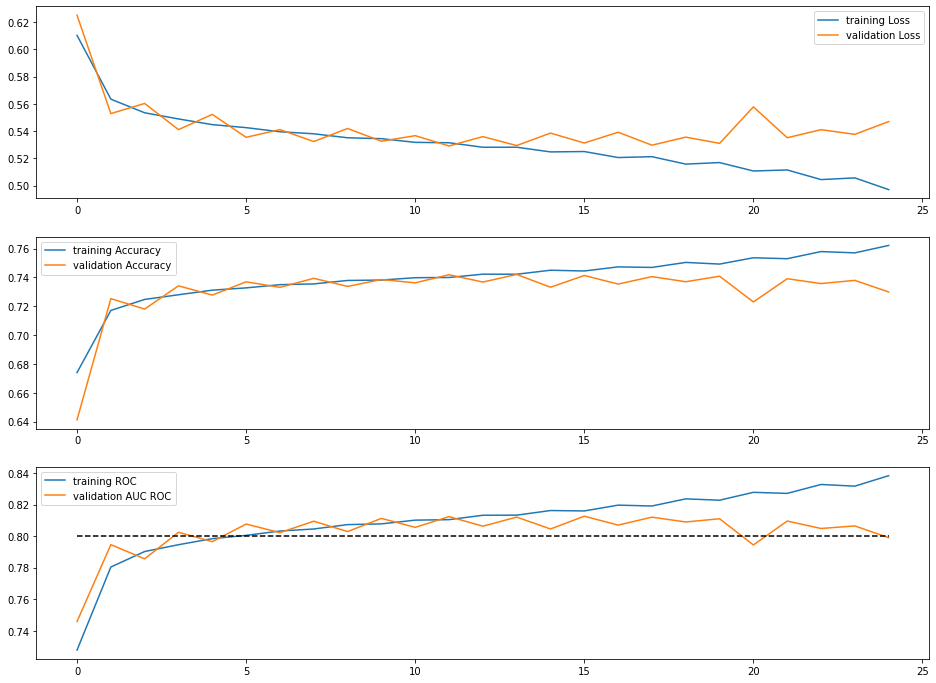

100%|██████████| 779/779 [00:04<00:00, 157.65it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

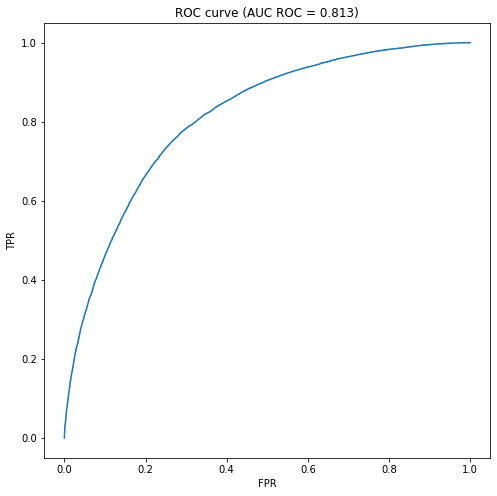

In [ ]:
class CNNSmall9_bias(nn.Module):
    def __init__(self, param_prelu=1):
        super(CNNSmall9_bias, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=True)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activ1 = nn.PReLU(param_prelu)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=True)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activ2 = nn.PReLU(param_prelu)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=True)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activ3 = nn.PReLU(param_prelu)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=True)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activ4 = nn.PReLU(param_prelu)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=True)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activ5 = nn.PReLU(param_prelu)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activ6 = nn.PReLU(param_prelu)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=True)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activ7 = nn.PReLU(param_prelu)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activ1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activ2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activ3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activ4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activ5(self.conv5_bn(self.conv5(conv4)))
        conv6 = self.activ6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activ7(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

CNN9 = doExperiment(CNNSmall9_bias(), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="CNN9_PRELU_AUC={}.pth")

# ResNet based

## Architecture

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return 

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(2, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.logits = nn.Linear(512 * block.expansion, 1)
        self.activ_head = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.logits(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self.activ_head(self._forward_impl(x))

## Experiments

### Experiment 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           6,272
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

loss = 0.6158031508241381, accuracy : 0.6684218645095825, AUC ROC 0.7203880834506614: 100%|██████████| 7004/7004 [04:25<00:00, 26.36it/s]


TRAINING ; Loss: 0.6158 Acc: 0.6684 AUC ROC : 0.7204 Time taken : 265.9


100%|██████████| 779/779 [00:04<00:00, 162.70it/s]


VALIDATION : Loss: 0.5930 Acc: 0.6946 AUC ROC : 0.7502 Time taken : 4.81
Epoch 1/24
----------


loss = 0.5779519214204379, accuracy : 0.7051718831062317, AUC ROC 0.7648944776187819: 100%|██████████| 7004/7004 [04:21<00:00, 26.77it/s]


TRAINING ; Loss: 0.5780 Acc: 0.7051 AUC ROC : 0.7649 Time taken : 262.14


100%|██████████| 779/779 [00:04<00:00, 166.45it/s]


VALIDATION : Loss: 0.5652 Acc: 0.7151 AUC ROC : 0.7818 Time taken : 4.7
Epoch 2/24
----------


loss = 0.5672836444761072, accuracy : 0.7130535840988159, AUC ROC 0.7763993765345983: 100%|██████████| 7004/7004 [04:24<00:00, 26.49it/s]


TRAINING ; Loss: 0.5673 Acc: 0.7130 AUC ROC : 0.7764 Time taken : 264.87


100%|██████████| 779/779 [00:04<00:00, 158.80it/s]


VALIDATION : Loss: 0.5767 Acc: 0.7052 AUC ROC : 0.7702 Time taken : 4.93
Epoch 3/24
----------


loss = 0.5621799206861428, accuracy : 0.716341495513916, AUC ROC 0.7812912360193307: 100%|██████████| 7004/7004 [04:23<00:00, 26.61it/s]


TRAINING ; Loss: 0.5622 Acc: 0.7163 AUC ROC : 0.7813 Time taken : 263.71


100%|██████████| 779/779 [00:04<00:00, 162.88it/s]


VALIDATION : Loss: 0.5543 Acc: 0.7224 AUC ROC : 0.7905 Time taken : 4.81
Epoch 4/24
----------


loss = 0.5560551086110728, accuracy : 0.721609354019165, AUC ROC 0.7875262630869361: 100%|██████████| 7004/7004 [04:23<00:00, 26.60it/s]


TRAINING ; Loss: 0.5561 Acc: 0.7216 AUC ROC : 0.7875 Time taken : 263.87


100%|██████████| 779/779 [00:05<00:00, 147.80it/s]


VALIDATION : Loss: 0.5627 Acc: 0.7173 AUC ROC : 0.7842 Time taken : 5.29
Epoch 5/24
----------


loss = 0.5552966338992119, accuracy : 0.722064733505249, AUC ROC 0.7883064089627093: 100%|██████████| 7004/7004 [04:19<00:00, 26.94it/s]


TRAINING ; Loss: 0.5553 Acc: 0.7221 AUC ROC : 0.7883 Time taken : 260.48


100%|██████████| 779/779 [00:04<00:00, 171.27it/s]


VALIDATION : Loss: 0.5490 Acc: 0.7274 AUC ROC : 0.7950 Time taken : 4.57
Epoch 6/24
----------


loss = 0.5507762781551906, accuracy : 0.7250691652297974, AUC ROC 0.7925396672847704: 100%|██████████| 7004/7004 [04:17<00:00, 27.25it/s]


TRAINING ; Loss: 0.5508 Acc: 0.7251 AUC ROC : 0.7925 Time taken : 257.54


100%|██████████| 779/779 [00:04<00:00, 163.02it/s]


VALIDATION : Loss: 0.5736 Acc: 0.7086 AUC ROC : 0.7780 Time taken : 4.8
Epoch 7/24
----------


loss = 0.5507056099091258, accuracy : 0.7252388596534729, AUC ROC 0.7925750415887576: 100%|██████████| 7004/7004 [04:20<00:00, 26.85it/s]


TRAINING ; Loss: 0.5507 Acc: 0.7252 AUC ROC : 0.7926 Time taken : 261.39


100%|██████████| 779/779 [00:04<00:00, 165.21it/s]


VALIDATION : Loss: 0.5455 Acc: 0.7299 AUC ROC : 0.7979 Time taken : 4.74
Epoch 8/24
----------


loss = 0.5463181326389313, accuracy : 0.7287343740463257, AUC ROC 0.7966832266007072: 100%|██████████| 7004/7004 [04:25<00:00, 26.36it/s]


TRAINING ; Loss: 0.5464 Acc: 0.7287 AUC ROC : 0.7966 Time taken : 266.24


100%|██████████| 779/779 [00:04<00:00, 163.23it/s]


VALIDATION : Loss: 0.5607 Acc: 0.7156 AUC ROC : 0.7847 Time taken : 4.8
Epoch 9/24
----------


loss = 0.5468147925010749, accuracy : 0.7283281087875366, AUC ROC 0.7962673792088861: 100%|██████████| 7004/7004 [04:21<00:00, 26.78it/s]


TRAINING ; Loss: 0.5468 Acc: 0.7283 AUC ROC : 0.7963 Time taken : 262.03


100%|██████████| 779/779 [00:04<00:00, 169.88it/s]


VALIDATION : Loss: 0.5452 Acc: 0.7294 AUC ROC : 0.7990 Time taken : 4.61
Epoch 10/24
----------


loss = 0.5427821339709418, accuracy : 0.7313839197158813, AUC ROC 0.8000019821727519: 100%|██████████| 7004/7004 [04:20<00:00, 26.89it/s]


TRAINING ; Loss: 0.5428 Acc: 0.7314 AUC ROC : 0.8000 Time taken : 260.94


100%|██████████| 779/779 [00:04<00:00, 164.45it/s]


VALIDATION : Loss: 0.5575 Acc: 0.7210 AUC ROC : 0.7872 Time taken : 4.76
Epoch 11/24
----------


loss = 0.5440875027818339, accuracy : 0.730013370513916, AUC ROC 0.7988492230824482: 100%|██████████| 7004/7004 [04:21<00:00, 26.81it/s]


TRAINING ; Loss: 0.5441 Acc: 0.7300 AUC ROC : 0.7989 Time taken : 261.81


100%|██████████| 779/779 [00:04<00:00, 165.73it/s]


VALIDATION : Loss: 0.5436 Acc: 0.7322 AUC ROC : 0.7996 Time taken : 4.72
Epoch 12/24
----------


loss = 0.5405127938432353, accuracy : 0.7329017519950867, AUC ROC 0.8022030557778382: 100%|██████████| 7004/7004 [04:22<00:00, 26.68it/s]


TRAINING ; Loss: 0.5405 Acc: 0.7329 AUC ROC : 0.8022 Time taken : 263.03


100%|██████████| 779/779 [00:04<00:00, 164.53it/s]


VALIDATION : Loss: 0.5534 Acc: 0.7230 AUC ROC : 0.7918 Time taken : 4.76
Epoch 13/24
----------


loss = 0.5411545569683824, accuracy : 0.7321138381958008, AUC ROC 0.801505661737167: 100%|██████████| 7004/7004 [04:21<00:00, 26.82it/s]


TRAINING ; Loss: 0.5411 Acc: 0.7321 AUC ROC : 0.8015 Time taken : 261.66


100%|██████████| 779/779 [00:05<00:00, 153.20it/s]


VALIDATION : Loss: 0.5429 Acc: 0.7324 AUC ROC : 0.8004 Time taken : 5.11
Epoch 14/24
----------


loss = 0.5376273756154946, accuracy : 0.7345245480537415, AUC ROC 0.8047119645349623: 100%|██████████| 7004/7004 [04:15<00:00, 27.41it/s]


TRAINING ; Loss: 0.5376 Acc: 0.7345 AUC ROC : 0.8047 Time taken : 256.01


100%|██████████| 779/779 [00:04<00:00, 171.70it/s]


VALIDATION : Loss: 0.5564 Acc: 0.7218 AUC ROC : 0.7878 Time taken : 4.56
Epoch 15/24
----------


loss = 0.5383745893112251, accuracy : 0.7344709634780884, AUC ROC 0.803976979209263: 100%|██████████| 7004/7004 [04:15<00:00, 27.40it/s]


TRAINING ; Loss: 0.5384 Acc: 0.7345 AUC ROC : 0.8040 Time taken : 256.1


100%|██████████| 779/779 [00:04<00:00, 171.80it/s]


VALIDATION : Loss: 0.5429 Acc: 0.7323 AUC ROC : 0.8012 Time taken : 4.56
Epoch 16/24
----------


loss = 0.5350585599584239, accuracy : 0.7368437647819519, AUC ROC 0.8070665429126482: 100%|██████████| 7004/7004 [04:21<00:00, 26.79it/s]


TRAINING ; Loss: 0.5351 Acc: 0.7368 AUC ROC : 0.8071 Time taken : 261.94


100%|██████████| 779/779 [00:05<00:00, 155.13it/s]


VALIDATION : Loss: 0.5561 Acc: 0.7240 AUC ROC : 0.7904 Time taken : 5.05
Epoch 17/24
----------


loss = 0.5360299478939602, accuracy : 0.735975444316864, AUC ROC 0.8061643831014828: 100%|██████████| 7004/7004 [04:20<00:00, 26.93it/s]


TRAINING ; Loss: 0.5361 Acc: 0.7359 AUC ROC : 0.8061 Time taken : 260.59


100%|██████████| 779/779 [00:04<00:00, 165.43it/s]


VALIDATION : Loss: 0.5419 Acc: 0.7334 AUC ROC : 0.8012 Time taken : 4.73
Epoch 18/24
----------


loss = 0.5320961692546096, accuracy : 0.73875892162323, AUC ROC 0.8096500933504942: 100%|██████████| 7004/7004 [04:14<00:00, 27.53it/s]


TRAINING ; Loss: 0.5321 Acc: 0.7388 AUC ROC : 0.8097 Time taken : 254.92


100%|██████████| 779/779 [00:04<00:00, 164.91it/s]


VALIDATION : Loss: 0.5519 Acc: 0.7263 AUC ROC : 0.7947 Time taken : 4.75
Epoch 19/24
----------


loss = 0.5332291548592704, accuracy : 0.7377946376800537, AUC ROC 0.8087118766884128: 100%|██████████| 7004/7004 [04:15<00:00, 27.43it/s]


TRAINING ; Loss: 0.5332 Acc: 0.7378 AUC ROC : 0.8087 Time taken : 255.89


100%|██████████| 779/779 [00:04<00:00, 165.90it/s]


VALIDATION : Loss: 0.5438 Acc: 0.7325 AUC ROC : 0.7998 Time taken : 4.72
Epoch 20/24
----------


loss = 0.529058326457228, accuracy : 0.7410089373588562, AUC ROC 0.8123797571111011: 100%|██████████| 7004/7004 [04:14<00:00, 27.50it/s]


TRAINING ; Loss: 0.5291 Acc: 0.7410 AUC ROC : 0.8124 Time taken : 255.17


100%|██████████| 779/779 [00:04<00:00, 176.44it/s]


VALIDATION : Loss: 0.5530 Acc: 0.7259 AUC ROC : 0.7923 Time taken : 4.44
Epoch 21/24
----------


loss = 0.5305803628649031, accuracy : 0.7398124933242798, AUC ROC 0.8109784631235901: 100%|██████████| 7004/7004 [04:15<00:00, 27.47it/s]


TRAINING ; Loss: 0.5306 Acc: 0.7398 AUC ROC : 0.8110 Time taken : 255.51


100%|██████████| 779/779 [00:04<00:00, 171.81it/s]


VALIDATION : Loss: 0.5449 Acc: 0.7317 AUC ROC : 0.7992 Time taken : 4.56
Epoch 22/24
----------


loss = 0.5257067502183573, accuracy : 0.7431473135948181, AUC ROC 0.8151309271433496: 100%|██████████| 7004/7004 [04:15<00:00, 27.39it/s]


TRAINING ; Loss: 0.5257 Acc: 0.7431 AUC ROC : 0.8151 Time taken : 256.26


100%|██████████| 779/779 [00:04<00:00, 173.54it/s]


VALIDATION : Loss: 0.5541 Acc: 0.7241 AUC ROC : 0.7934 Time taken : 4.51
Epoch 23/24
----------


loss = 0.5269941019628729, accuracy : 0.7421294450759888, AUC ROC 0.8140546694297267: 100%|██████████| 7004/7004 [04:15<00:00, 27.47it/s]


TRAINING ; Loss: 0.5270 Acc: 0.7421 AUC ROC : 0.8140 Time taken : 255.5


100%|██████████| 779/779 [00:04<00:00, 171.42it/s]


VALIDATION : Loss: 0.5458 Acc: 0.7315 AUC ROC : 0.7985 Time taken : 4.57
Epoch 24/24
----------


loss = 0.5214921013798033, accuracy : 0.7460267543792725, AUC ROC 0.818641323042212: 100%|██████████| 7004/7004 [04:15<00:00, 27.39it/s]


TRAINING ; Loss: 0.5215 Acc: 0.7460 AUC ROC : 0.8187 Time taken : 256.2


100%|██████████| 779/779 [00:04<00:00, 159.44it/s]


VALIDATION : Loss: 0.5529 Acc: 0.7241 AUC ROC : 0.7932 Time taken : 4.91
Training complete in 110m 19s


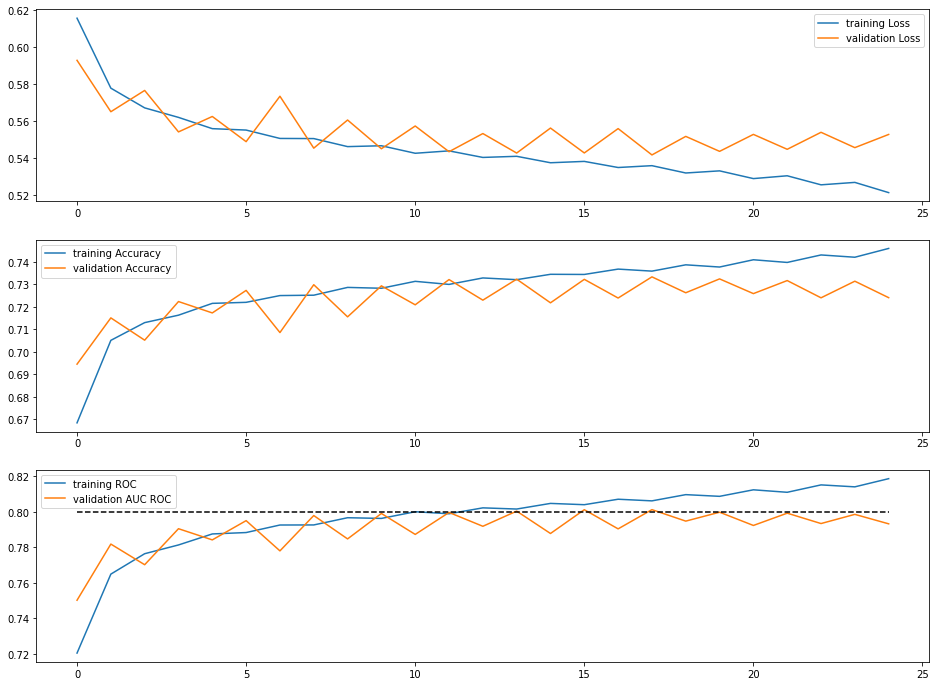

100%|██████████| 779/779 [00:04<00:00, 167.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

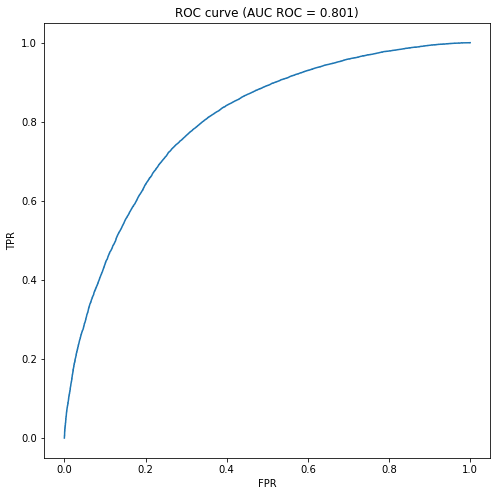

{'trainingLoss': [0.6158051948672902,
  0.5779692993670476,
  0.5673095309856693,
  0.5621661846534528,
  0.5560704716647751,
  0.5553097685316427,
  0.5507768997620494,
  0.5507047080568095,
  0.5463580636029156,
  0.5468245895778107,
  0.542763287217848,
  0.5440550765359258,
  0.5405091306813218,
  0.5411172609555833,
  0.53763379648135,
  0.5383634578974212,
  0.5350599915446154,
  0.5360551237357828,
  0.5320937142756197,
  0.533245355735023,
  0.5290658118936538,
  0.5305836578672989,
  0.5256950448347701,
  0.5270081880293697,
  0.521480089742549],
 'trainingAccuracy': [0.6684381972333779,
  0.7051472556894244,
  0.7130343596608657,
  0.7163453815261044,
  0.7216019634091924,
  0.7220638107987506,
  0.7250736278447122,
  0.7252409638554217,
  0.7287037037037037,
  0.728326639892905,
  0.7314056224899599,
  0.7300401606425703,
  0.7329138777331549,
  0.7321441320838912,
  0.7345336903168229,
  0.7344689870593485,
  0.7368496207050425,
  0.7359482373940206,
  0.7387527889335118,
 

In [ ]:
doExperiment(ResNet(BasicBlock, [2, 2, 2, 2]), learning_rate=1e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="Resnet_smallerInp_AUC={}.pth")

### Experiment 2


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           6,272
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12            [-1, 128, 4, 4]          73,728
      BatchNorm2d-13            [-1, 128, 4, 4]             256
             ReLU-14            [-1, 12

loss = 0.6116347960276263, accuracy : 0.6710245609283447, AUC ROC 0.7246311885779401: 100%|██████████| 7004/7004 [03:43<00:00, 31.40it/s]


TRAINING ; Loss: 0.6116 Acc: 0.6711 AUC ROC : 0.7247 Time taken : 223.25


100%|██████████| 779/779 [00:03<00:00, 221.46it/s]


VALIDATION : Loss: 0.5901 Acc: 0.6932 AUC ROC : 0.7520 Time taken : 3.54
Epoch 1/14
----------


loss = 0.5736970001544272, accuracy : 0.7080379128456116, AUC ROC 0.7695828761609794: 100%|██████████| 7004/7004 [03:44<00:00, 31.24it/s]


TRAINING ; Loss: 0.5737 Acc: 0.7080 AUC ROC : 0.7696 Time taken : 224.55


100%|██████████| 779/779 [00:03<00:00, 234.79it/s]


VALIDATION : Loss: 0.5592 Acc: 0.7198 AUC ROC : 0.7850 Time taken : 3.34
Epoch 2/14
----------


loss = 0.56312027072055, accuracy : 0.7162142992019653, AUC ROC 0.7804290069299017: 100%|██████████| 7004/7004 [03:40<00:00, 31.77it/s]


TRAINING ; Loss: 0.5631 Acc: 0.7162 AUC ROC : 0.7804 Time taken : 220.86


100%|██████████| 779/779 [00:03<00:00, 233.70it/s]


VALIDATION : Loss: 0.5653 Acc: 0.7151 AUC ROC : 0.7803 Time taken : 3.36
Epoch 3/14
----------


loss = 0.558926297643355, accuracy : 0.7195758819580078, AUC ROC 0.7846910779413405: 100%|██████████| 7004/7004 [03:39<00:00, 31.89it/s]


TRAINING ; Loss: 0.5589 Acc: 0.7196 AUC ROC : 0.7847 Time taken : 220.03


100%|██████████| 779/779 [00:03<00:00, 233.54it/s]


VALIDATION : Loss: 0.5520 Acc: 0.7262 AUC ROC : 0.7919 Time taken : 3.36
Epoch 4/14
----------


loss = 0.553482000035899, accuracy : 0.7240223288536072, AUC ROC 0.7899849905660028: 100%|██████████| 7004/7004 [03:39<00:00, 31.86it/s]


TRAINING ; Loss: 0.5535 Acc: 0.7240 AUC ROC : 0.7900 Time taken : 220.18


100%|██████████| 779/779 [00:03<00:00, 221.57it/s]


VALIDATION : Loss: 0.5623 Acc: 0.7172 AUC ROC : 0.7825 Time taken : 3.54
Epoch 5/14
----------


loss = 0.5524301095732621, accuracy : 0.7246986627578735, AUC ROC 0.7909984331277701: 100%|██████████| 7004/7004 [03:39<00:00, 31.86it/s]


TRAINING ; Loss: 0.5524 Acc: 0.7247 AUC ROC : 0.7910 Time taken : 220.22


100%|██████████| 779/779 [00:03<00:00, 231.17it/s]


VALIDATION : Loss: 0.5474 Acc: 0.7297 AUC ROC : 0.7962 Time taken : 3.39
Epoch 6/14
----------


loss = 0.548400950146573, accuracy : 0.7276942133903503, AUC ROC 0.7947538965814105: 100%|██████████| 7004/7004 [03:39<00:00, 31.97it/s]


TRAINING ; Loss: 0.5484 Acc: 0.7277 AUC ROC : 0.7948 Time taken : 219.43


100%|██████████| 779/779 [00:03<00:00, 220.16it/s]


VALIDATION : Loss: 0.5538 Acc: 0.7233 AUC ROC : 0.7902 Time taken : 3.56
Epoch 7/14
----------


loss = 0.5478332033114773, accuracy : 0.7278727889060974, AUC ROC 0.7953129143750248: 100%|██████████| 7004/7004 [03:38<00:00, 32.09it/s]


TRAINING ; Loss: 0.5478 Acc: 0.7279 AUC ROC : 0.7953 Time taken : 218.65


100%|██████████| 779/779 [00:03<00:00, 241.92it/s]


VALIDATION : Loss: 0.5463 Acc: 0.7304 AUC ROC : 0.7970 Time taken : 3.24
Epoch 8/14
----------


loss = 0.5442129381384169, accuracy : 0.7302276492118835, AUC ROC 0.7986491427313425: 100%|██████████| 7004/7004 [03:41<00:00, 31.66it/s]


TRAINING ; Loss: 0.5442 Acc: 0.7302 AUC ROC : 0.7986 Time taken : 221.6


100%|██████████| 779/779 [00:03<00:00, 225.49it/s]


VALIDATION : Loss: 0.5662 Acc: 0.7149 AUC ROC : 0.7805 Time taken : 3.48
Epoch 9/14
----------


loss = 0.5447885269607816, accuracy : 0.7299084663391113, AUC ROC 0.7981313180694611: 100%|██████████| 7004/7004 [03:38<00:00, 32.09it/s]


TRAINING ; Loss: 0.5448 Acc: 0.7299 AUC ROC : 0.7981 Time taken : 218.62


100%|██████████| 779/779 [00:03<00:00, 234.29it/s]


VALIDATION : Loss: 0.5437 Acc: 0.7320 AUC ROC : 0.7996 Time taken : 3.35
Epoch 10/14
----------


loss = 0.5415732758130346, accuracy : 0.7321071624755859, AUC ROC 0.8010758628504031: 100%|██████████| 7004/7004 [03:39<00:00, 31.92it/s]


TRAINING ; Loss: 0.5416 Acc: 0.7321 AUC ROC : 0.8011 Time taken : 219.81


100%|██████████| 779/779 [00:03<00:00, 227.48it/s]


VALIDATION : Loss: 0.5527 Acc: 0.7250 AUC ROC : 0.7919 Time taken : 3.45
Epoch 11/14
----------


loss = 0.54225182685256, accuracy : 0.7317142486572266, AUC ROC 0.8005053105314246: 100%|██████████| 7004/7004 [03:37<00:00, 32.22it/s]


TRAINING ; Loss: 0.5422 Acc: 0.7317 AUC ROC : 0.8005 Time taken : 217.77


100%|██████████| 779/779 [00:03<00:00, 236.30it/s]


VALIDATION : Loss: 0.5442 Acc: 0.7315 AUC ROC : 0.7993 Time taken : 3.32
Epoch 12/14
----------


loss = 0.538862673836095, accuracy : 0.7345134019851685, AUC ROC 0.8035062798987086: 100%|██████████| 7004/7004 [03:37<00:00, 32.15it/s]


TRAINING ; Loss: 0.5389 Acc: 0.7345 AUC ROC : 0.8035 Time taken : 218.21


100%|██████████| 779/779 [00:03<00:00, 216.30it/s]


VALIDATION : Loss: 0.5530 Acc: 0.7249 AUC ROC : 0.7927 Time taken : 3.62
Epoch 13/14
----------


loss = 0.5400091103357928, accuracy : 0.7335624694824219, AUC ROC 0.8026150897708435: 100%|██████████| 7004/7004 [03:37<00:00, 32.21it/s]


TRAINING ; Loss: 0.5400 Acc: 0.7336 AUC ROC : 0.8026 Time taken : 217.8


100%|██████████| 779/779 [00:03<00:00, 230.82it/s]


VALIDATION : Loss: 0.5434 Acc: 0.7324 AUC ROC : 0.7998 Time taken : 3.4
Epoch 14/14
----------


loss = 0.5359719514974526, accuracy : 0.7368325591087341, AUC ROC 0.8061000726151568: 100%|██████████| 7004/7004 [03:41<00:00, 31.55it/s]


TRAINING ; Loss: 0.5360 Acc: 0.7368 AUC ROC : 0.8061 Time taken : 222.38


100%|██████████| 779/779 [00:03<00:00, 199.39it/s]


VALIDATION : Loss: 0.5607 Acc: 0.7198 AUC ROC : 0.7896 Time taken : 3.93
Training complete in 55m 55s


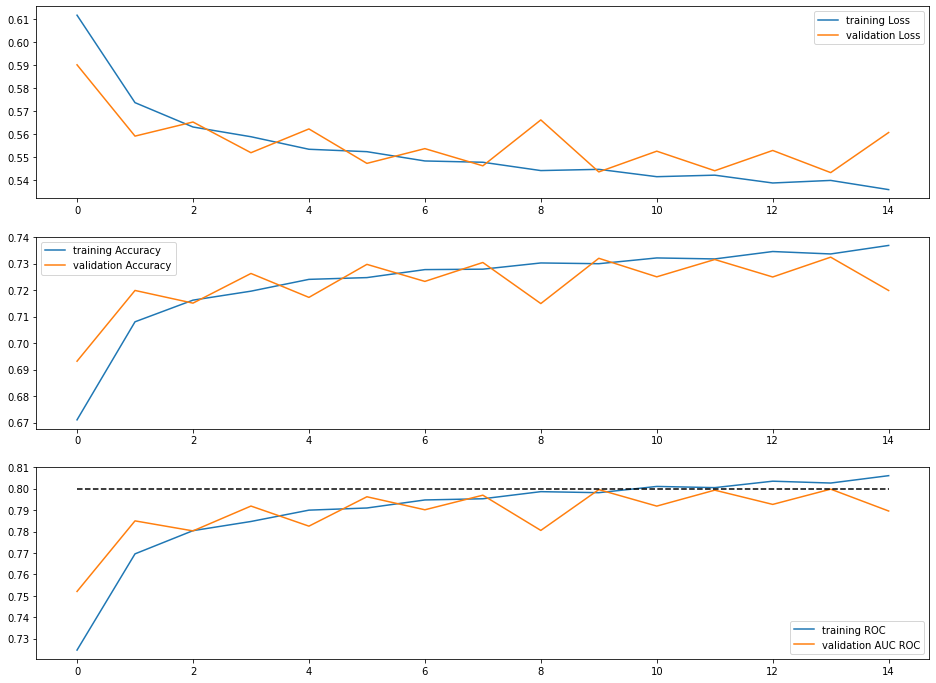

100%|██████████| 779/779 [00:03<00:00, 228.71it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

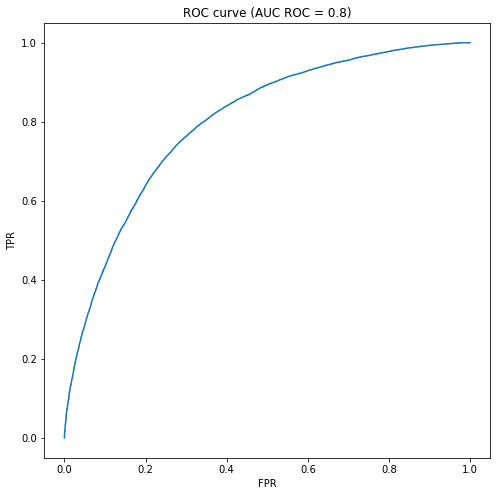

In [ ]:
resnet2 = doExperiment(ResNet(BasicBlock, [1, 1, 1, 1]), learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="Resnet_smallerInp1_AUC={}.pth")

### Experiment 3

In [ ]:
resnet3 = doExperiment(ResNet(BasicBlock, [1, 1, 1, 2]), learning_rate=1e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="Resnet_1_1_1_2_smallerInp_AUC={}.pth")

# ConvNext

## Architecture :
- paper : 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
from torchsummary import summary

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=2),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        self.head_activation = nn.Sigmoid()

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activation(x)

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

## Experiments

### Experiment 1 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             608
         LayerNorm-2           [-1, 32, 15, 15]              64
            Conv2d-3           [-1, 32, 15, 15]             320
         LayerNorm-4           [-1, 15, 15, 32]              64
            Linear-5          [-1, 15, 15, 128]           4,224
              GELU-6          [-1, 15, 15, 128]               0
            Linear-7           [-1, 15, 15, 32]           4,128
          Identity-8           [-1, 32, 15, 15]               0
             Block-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]             320
        LayerNorm-11           [-1, 15, 15, 32]              64
           Linear-12          [-1, 15, 15, 128]           4,224
             GELU-13          [-1, 15, 15, 128]               0
           Linear-14           [-1, 15,

loss = 0.619848484239408, accuracy : 0.6661852598190308, AUC ROC 0.7136244122323813: 100%|██████████| 7004/7004 [05:30<00:00, 21.22it/s]


TRAINING ; Loss: 0.6198 Acc: 0.6662 AUC ROC : 0.7136 Time taken : 330.2


100%|██████████| 779/779 [00:05<00:00, 141.72it/s]


VALIDATION : Loss: 0.5988 Acc: 0.6917 AUC ROC : 0.7485 Time taken : 5.52
Epoch 1/14
----------


loss = 0.5862981543455805, accuracy : 0.7001116275787354, AUC ROC 0.756170132100131: 100%|██████████| 7004/7004 [05:27<00:00, 21.36it/s]


TRAINING ; Loss: 0.5863 Acc: 0.7001 AUC ROC : 0.7562 Time taken : 328.87


100%|██████████| 779/779 [00:05<00:00, 137.32it/s]


VALIDATION : Loss: 0.5655 Acc: 0.7160 AUC ROC : 0.7780 Time taken : 5.7
Epoch 2/14
----------


loss = 0.5733976906921182, accuracy : 0.710031270980835, AUC ROC 0.7705525132780591: 100%|██████████| 7004/7004 [05:28<00:00, 21.34it/s]


TRAINING ; Loss: 0.5734 Acc: 0.7100 AUC ROC : 0.7705 Time taken : 329.17


100%|██████████| 779/779 [00:05<00:00, 144.83it/s]


VALIDATION : Loss: 0.5766 Acc: 0.7054 AUC ROC : 0.7733 Time taken : 5.4
Epoch 3/14
----------


loss = 0.566167330030884, accuracy : 0.7153928279876709, AUC ROC 0.7779819760748048: 100%|██████████| 7004/7004 [05:28<00:00, 21.29it/s]


TRAINING ; Loss: 0.5662 Acc: 0.7154 AUC ROC : 0.7780 Time taken : 329.95


100%|██████████| 779/779 [00:05<00:00, 143.00it/s]


VALIDATION : Loss: 0.5531 Acc: 0.7235 AUC ROC : 0.7909 Time taken : 5.47
Epoch 4/14
----------


loss = 0.5595406928913934, accuracy : 0.7195267677307129, AUC ROC 0.7844723901514868: 100%|██████████| 7004/7004 [05:29<00:00, 21.26it/s]


TRAINING ; Loss: 0.5595 Acc: 0.7195 AUC ROC : 0.7845 Time taken : 330.49


100%|██████████| 779/779 [00:05<00:00, 142.29it/s]


VALIDATION : Loss: 0.5676 Acc: 0.7147 AUC ROC : 0.7793 Time taken : 5.5
Epoch 5/14
----------


loss = 0.5568105948609965, accuracy : 0.7214798927307129, AUC ROC 0.786984429224868: 100%|██████████| 7004/7004 [05:28<00:00, 21.32it/s]


TRAINING ; Loss: 0.5568 Acc: 0.7215 AUC ROC : 0.7870 Time taken : 329.51


100%|██████████| 779/779 [00:05<00:00, 142.74it/s]


VALIDATION : Loss: 0.5482 Acc: 0.7273 AUC ROC : 0.7947 Time taken : 5.48
Epoch 6/14
----------


loss = 0.5527509131899901, accuracy : 0.7248638272285461, AUC ROC 0.7909124875190272: 100%|██████████| 7004/7004 [05:29<00:00, 21.23it/s]


TRAINING ; Loss: 0.5528 Acc: 0.7249 AUC ROC : 0.7909 Time taken : 330.92


100%|██████████| 779/779 [00:05<00:00, 142.33it/s]


VALIDATION : Loss: 0.5739 Acc: 0.7100 AUC ROC : 0.7755 Time taken : 5.5
Epoch 7/14
----------


loss = 0.5516653312104088, accuracy : 0.7255625128746033, AUC ROC 0.7919316162840346: 100%|██████████| 7004/7004 [05:29<00:00, 21.28it/s]


TRAINING ; Loss: 0.5516 Acc: 0.7256 AUC ROC : 0.7920 Time taken : 330.17


100%|██████████| 779/779 [00:05<00:00, 140.39it/s]


VALIDATION : Loss: 0.5447 Acc: 0.7316 AUC ROC : 0.7981 Time taken : 5.57
Epoch 8/14
----------


loss = 0.5482812895519393, accuracy : 0.7280625104904175, AUC ROC 0.7951300604945986: 100%|██████████| 7004/7004 [05:26<00:00, 21.47it/s]


TRAINING ; Loss: 0.5483 Acc: 0.7281 AUC ROC : 0.7951 Time taken : 327.21


100%|██████████| 779/779 [00:05<00:00, 136.26it/s]


VALIDATION : Loss: 0.5541 Acc: 0.7252 AUC ROC : 0.7905 Time taken : 5.74
Epoch 9/14
----------


loss = 0.5482431947205748, accuracy : 0.727415144443512, AUC ROC 0.7952467985228194: 100%|██████████| 7004/7004 [05:28<00:00, 21.29it/s]


TRAINING ; Loss: 0.5482 Acc: 0.7275 AUC ROC : 0.7953 Time taken : 330.0


100%|██████████| 779/779 [00:05<00:00, 146.83it/s]


VALIDATION : Loss: 0.5439 Acc: 0.7334 AUC ROC : 0.7989 Time taken : 5.33
Epoch 10/14
----------


loss = 0.5453372193064009, accuracy : 0.7299821376800537, AUC ROC 0.7978203446805501: 100%|██████████| 7004/7004 [05:30<00:00, 21.20it/s]


TRAINING ; Loss: 0.5454 Acc: 0.7300 AUC ROC : 0.7978 Time taken : 331.33


100%|██████████| 779/779 [00:05<00:00, 144.45it/s]


VALIDATION : Loss: 0.5557 Acc: 0.7254 AUC ROC : 0.7904 Time taken : 5.42
Epoch 11/14
----------


loss = 0.5452771156217371, accuracy : 0.7300602793693542, AUC ROC 0.7979810530048388: 100%|██████████| 7004/7004 [05:29<00:00, 21.27it/s]


TRAINING ; Loss: 0.5453 Acc: 0.7301 AUC ROC : 0.7980 Time taken : 330.34


100%|██████████| 779/779 [00:05<00:00, 145.61it/s]


VALIDATION : Loss: 0.5422 Acc: 0.7337 AUC ROC : 0.8005 Time taken : 5.38
Epoch 12/14
----------


loss = 0.5424991137215069, accuracy : 0.7321160435676575, AUC ROC 0.8004235107303973: 100%|██████████| 7004/7004 [05:28<00:00, 21.30it/s]


TRAINING ; Loss: 0.5425 Acc: 0.7321 AUC ROC : 0.8004 Time taken : 329.81


100%|██████████| 779/779 [00:05<00:00, 150.00it/s]


VALIDATION : Loss: 0.5514 Acc: 0.7278 AUC ROC : 0.7926 Time taken : 5.22
Epoch 13/14
----------


loss = 0.5427027288121836, accuracy : 0.7316852807998657, AUC ROC 0.800246422875498: 100%|██████████| 7004/7004 [05:29<00:00, 21.27it/s]


TRAINING ; Loss: 0.5427 Acc: 0.7317 AUC ROC : 0.8003 Time taken : 330.26


100%|██████████| 779/779 [00:05<00:00, 144.21it/s]


VALIDATION : Loss: 0.5416 Acc: 0.7335 AUC ROC : 0.8016 Time taken : 5.42
Epoch 14/14
----------


loss = 0.540338691085577, accuracy : 0.7341785430908203, AUC ROC 0.8024121193142069: 100%|██████████| 7004/7004 [05:29<00:00, 21.23it/s]


TRAINING ; Loss: 0.5403 Acc: 0.7342 AUC ROC : 0.8024 Time taken : 330.84


100%|██████████| 779/779 [00:05<00:00, 143.80it/s]


VALIDATION : Loss: 0.5526 Acc: 0.7258 AUC ROC : 0.7920 Time taken : 5.44
Training complete in 83m 51s


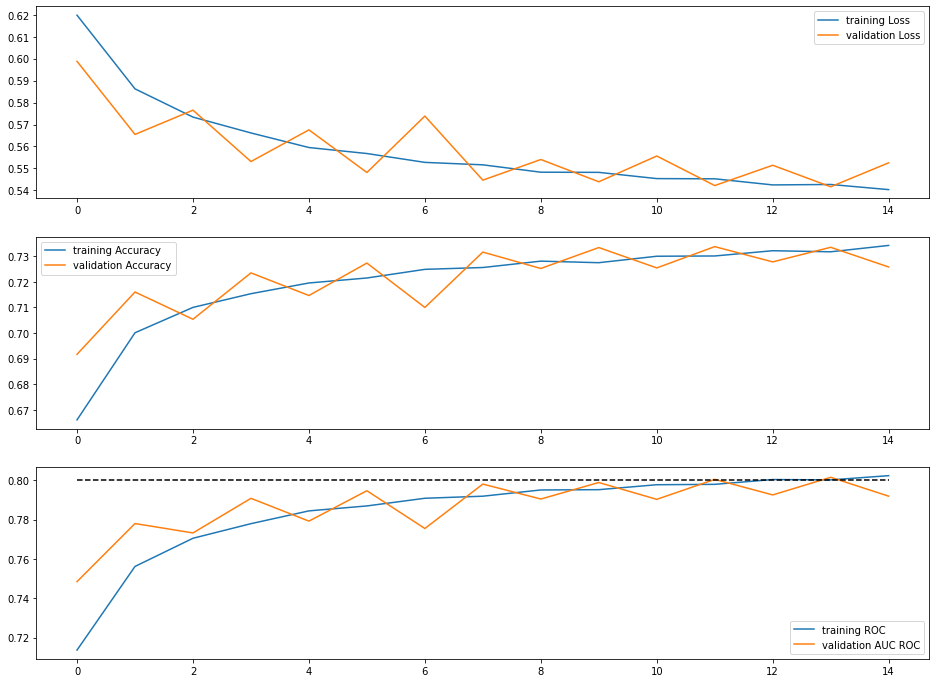

100%|██████████| 779/779 [00:05<00:00, 150.33it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

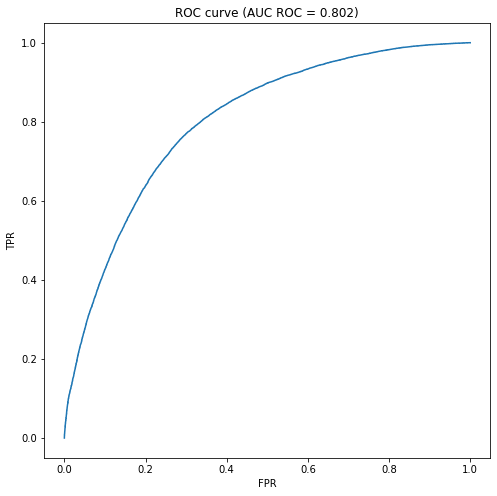

{'trainingLoss': [0.619847120994013,
  0.5862716937650266,
  0.57340351904678,
  0.5661757107442748,
  0.5595309702523422,
  0.556794462640176,
  0.5527590528198355,
  0.5516403838754073,
  0.5482846154075071,
  0.5482066919206775,
  0.5453687803088847,
  0.545267561223559,
  0.5424854384326127,
  0.5426874698070159,
  0.5403436885987579],
 'trainingAccuracy': [0.6661847389558233,
  0.7001383311021866,
  0.7100223114680946,
  0.7153681392235609,
  0.7195448460508702,
  0.7214904060687194,
  0.7248572066041946,
  0.7255756358768407,
  0.7280589022757697,
  0.7274520303435966,
  0.7299687639446676,
  0.7300736278447122,
  0.7321218206157966,
  0.7317045961624276,
  0.7341834002677377],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'trainingAUC': [0.7136302423437615,
  0.7562021463612394,
  0.7705464493404228,
  0.7779732271741535,
  0.7844821682784487,
  0.7869999014751057,
  0.7909026570260417,
  0.7919549827949808,
  0.7951276346399032,
  0.7952808541021142,
  0.79779

In [ ]:
 doExperiment(ConvNeXt(in_chans=2, num_classes=1, depths=[2,2,6,2], dims=[32, 64, 64, 96]), 
             learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="ConvNeXt_2_2_6_2_AUC={}.pth")

### Experiment 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             608
         LayerNorm-2           [-1, 32, 15, 15]              64
            Conv2d-3           [-1, 32, 15, 15]             320
         LayerNorm-4           [-1, 15, 15, 32]              64
            Linear-5          [-1, 15, 15, 128]           4,224
              GELU-6          [-1, 15, 15, 128]               0
            Linear-7           [-1, 15, 15, 32]           4,128
          Identity-8           [-1, 32, 15, 15]               0
             Block-9           [-1, 32, 15, 15]               0
        LayerNorm-10           [-1, 32, 15, 15]              64
           Conv2d-11             [-1, 64, 7, 7]           8,256
           Conv2d-12             [-1, 64, 7, 7]             640
        LayerNorm-13             [-1, 7, 7, 64]             128
           Linear-14            [-1, 7,

loss = 0.6220345239298685, accuracy : 0.6642075777053833, AUC ROC 0.7100849264656477: 100%|██████████| 7004/7004 [04:16<00:00, 27.32it/s]


TRAINING ; Loss: 0.6220 Acc: 0.6642 AUC ROC : 0.7101 Time taken : 256.49


100%|██████████| 779/779 [00:04<00:00, 184.35it/s]


VALIDATION : Loss: 0.5981 Acc: 0.6963 AUC ROC : 0.7484 Time taken : 4.25
Epoch 1/14
----------


loss = 0.5857760616328035, accuracy : 0.7008995413780212, AUC ROC 0.7566740270463376: 100%|██████████| 7004/7004 [04:20<00:00, 26.86it/s]


TRAINING ; Loss: 0.5858 Acc: 0.7009 AUC ROC : 0.7567 Time taken : 261.44


100%|██████████| 779/779 [00:04<00:00, 186.33it/s]


VALIDATION : Loss: 0.5686 Acc: 0.7151 AUC ROC : 0.7756 Time taken : 4.21
Epoch 2/14
----------


loss = 0.5742077656984329, accuracy : 0.7102165222167969, AUC ROC 0.7695703097039328: 100%|██████████| 7004/7004 [04:16<00:00, 27.33it/s]


TRAINING ; Loss: 0.5742 Acc: 0.7102 AUC ROC : 0.7696 Time taken : 257.0


100%|██████████| 779/779 [00:04<00:00, 191.83it/s]


VALIDATION : Loss: 0.5811 Acc: 0.7047 AUC ROC : 0.7710 Time taken : 4.08
Epoch 3/14
----------


loss = 0.5665203295562948, accuracy : 0.715738832950592, AUC ROC 0.7775968535472978: 100%|██████████| 7004/7004 [04:18<00:00, 27.07it/s]


TRAINING ; Loss: 0.5665 Acc: 0.7157 AUC ROC : 0.7776 Time taken : 259.42


100%|██████████| 779/779 [00:04<00:00, 185.17it/s]


VALIDATION : Loss: 0.5545 Acc: 0.7254 AUC ROC : 0.7897 Time taken : 4.23
Epoch 4/14
----------


loss = 0.5601987621401038, accuracy : 0.719872772693634, AUC ROC 0.7838500753175901: 100%|██████████| 7004/7004 [04:20<00:00, 26.91it/s]


TRAINING ; Loss: 0.5602 Acc: 0.7199 AUC ROC : 0.7838 Time taken : 261.0


100%|██████████| 779/779 [00:04<00:00, 189.84it/s]


VALIDATION : Loss: 0.5716 Acc: 0.7082 AUC ROC : 0.7821 Time taken : 4.13
Epoch 5/14
----------


loss = 0.5574788293412754, accuracy : 0.721522331237793, AUC ROC 0.7864254040041317: 100%|██████████| 7004/7004 [04:20<00:00, 26.92it/s]


TRAINING ; Loss: 0.5575 Acc: 0.7215 AUC ROC : 0.7864 Time taken : 260.9


100%|██████████| 779/779 [00:04<00:00, 191.00it/s]


VALIDATION : Loss: 0.5479 Acc: 0.7283 AUC ROC : 0.7952 Time taken : 4.1
Epoch 6/14
----------


loss = 0.5534341767685754, accuracy : 0.7240424156188965, AUC ROC 0.7903004252161355: 100%|██████████| 7004/7004 [04:19<00:00, 27.02it/s]


TRAINING ; Loss: 0.5535 Acc: 0.7240 AUC ROC : 0.7903 Time taken : 259.92


100%|██████████| 779/779 [00:04<00:00, 185.60it/s]


VALIDATION : Loss: 0.5587 Acc: 0.7206 AUC ROC : 0.7874 Time taken : 4.22
Epoch 7/14
----------


loss = 0.5523641090733664, accuracy : 0.725314736366272, AUC ROC 0.7913786774246359: 100%|██████████| 7004/7004 [04:21<00:00, 26.81it/s]


TRAINING ; Loss: 0.5523 Acc: 0.7253 AUC ROC : 0.7914 Time taken : 262.01


100%|██████████| 779/779 [00:04<00:00, 188.91it/s]


VALIDATION : Loss: 0.5484 Acc: 0.7287 AUC ROC : 0.7964 Time taken : 4.15
Epoch 8/14
----------


loss = 0.5497915486352785, accuracy : 0.7268571257591248, AUC ROC 0.7937693031504489: 100%|██████████| 7004/7004 [04:21<00:00, 26.77it/s]


TRAINING ; Loss: 0.5498 Acc: 0.7269 AUC ROC : 0.7938 Time taken : 262.34


100%|██████████| 779/779 [00:04<00:00, 193.35it/s]


VALIDATION : Loss: 0.5537 Acc: 0.7253 AUC ROC : 0.7904 Time taken : 4.05
Epoch 9/14
----------


loss = 0.5487651599006993, accuracy : 0.7274866104125977, AUC ROC 0.7946952279463512: 100%|██████████| 7004/7004 [04:20<00:00, 26.91it/s]


TRAINING ; Loss: 0.5488 Acc: 0.7275 AUC ROC : 0.7947 Time taken : 260.96


100%|██████████| 779/779 [00:04<00:00, 189.75it/s]


VALIDATION : Loss: 0.5448 Acc: 0.7315 AUC ROC : 0.7990 Time taken : 4.13
Epoch 10/14
----------


loss = 0.5461581025975091, accuracy : 0.7296450734138489, AUC ROC 0.7970589947718736: 100%|██████████| 7004/7004 [04:19<00:00, 27.01it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7296 AUC ROC : 0.7971 Time taken : 260.02


100%|██████████| 779/779 [00:04<00:00, 190.11it/s]


VALIDATION : Loss: 0.5494 Acc: 0.7290 AUC ROC : 0.7944 Time taken : 4.12
Epoch 11/14
----------


loss = 0.5461633173567908, accuracy : 0.7291339039802551, AUC ROC 0.7971098130617913: 100%|██████████| 7004/7004 [04:19<00:00, 26.97it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7291 AUC ROC : 0.7971 Time taken : 260.36


100%|██████████| 779/779 [00:04<00:00, 191.13it/s]


VALIDATION : Loss: 0.5431 Acc: 0.7325 AUC ROC : 0.8001 Time taken : 4.1
Epoch 12/14
----------


loss = 0.543430852166244, accuracy : 0.7313392758369446, AUC ROC 0.7994977773461156: 100%|██████████| 7004/7004 [04:20<00:00, 26.91it/s]


TRAINING ; Loss: 0.5434 Acc: 0.7313 AUC ROC : 0.7995 Time taken : 260.94


100%|██████████| 779/779 [00:04<00:00, 186.87it/s]


VALIDATION : Loss: 0.5687 Acc: 0.7049 AUC ROC : 0.7833 Time taken : 4.19
Epoch 13/14
----------


loss = 0.5436063613891602, accuracy : 0.7311004400253296, AUC ROC 0.7993681608656173: 100%|██████████| 7004/7004 [04:19<00:00, 26.96it/s]


TRAINING ; Loss: 0.5436 Acc: 0.7311 AUC ROC : 0.7994 Time taken : 260.47


100%|██████████| 779/779 [00:04<00:00, 189.09it/s]


VALIDATION : Loss: 0.5412 Acc: 0.7337 AUC ROC : 0.8014 Time taken : 4.14
Epoch 14/14
----------


loss = 0.541006557307073, accuracy : 0.7331517934799194, AUC ROC 0.8016831430763712: 100%|██████████| 7004/7004 [04:19<00:00, 27.03it/s]


TRAINING ; Loss: 0.5410 Acc: 0.7331 AUC ROC : 0.8017 Time taken : 259.8


100%|██████████| 779/779 [00:04<00:00, 192.33it/s]


VALIDATION : Loss: 0.5482 Acc: 0.7279 AUC ROC : 0.7947 Time taken : 4.07
Training complete in 66m 5s


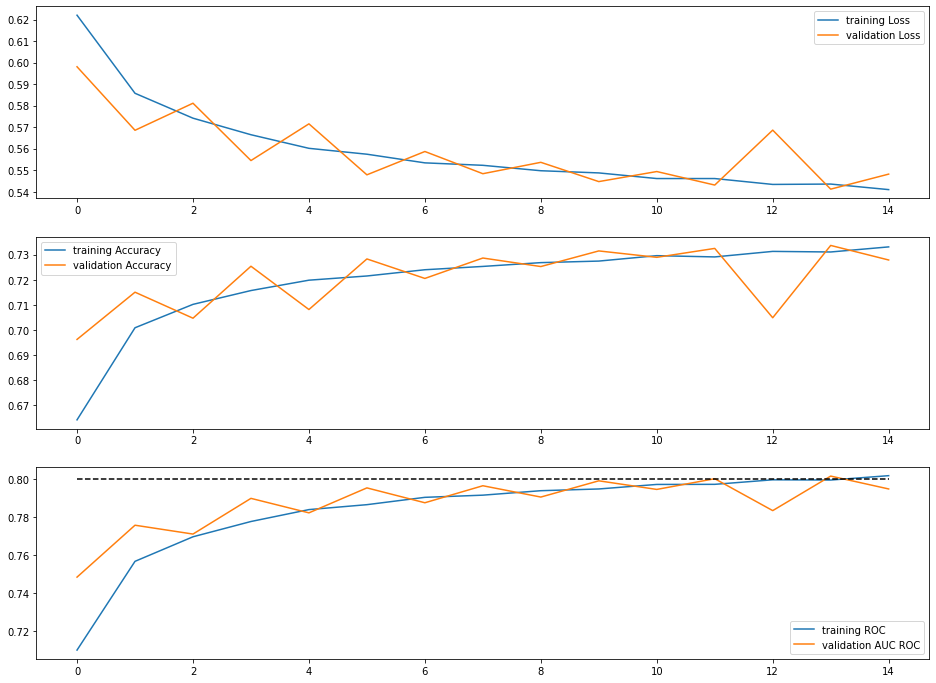

100%|██████████| 779/779 [00:04<00:00, 193.08it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

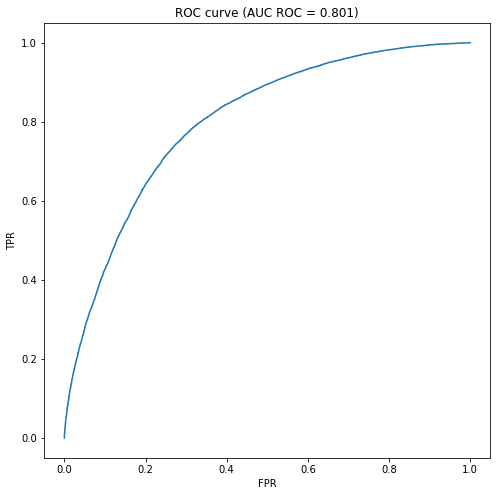

{'trainingLoss': [0.6220276379574627,
  0.5857676185725365,
  0.5742025782326831,
  0.5665191265686662,
  0.5602037598117554,
  0.5574716005374256,
  0.5534526543232119,
  0.5523160812706885,
  0.5497967289420762,
  0.5487842679076937,
  0.5461679063849766,
  0.5461686264878136,
  0.5434388892100571,
  0.5436071943476072,
  0.5410272188029189],
 'trainingAccuracy': [0.6642101740294512,
  0.7009080767514503,
  0.710227576974565,
  0.7157362784471218,
  0.7198661311914324,
  0.7215394912985275,
  0.7240272199910754,
  0.7253480589022758,
  0.7268607764390898,
  0.7274788041053102,
  0.729636323070058,
  0.729136546184739,
  0.731338688085676,
  0.7311044176706828,
  0.733132530120482],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'trainingAUC': [0.7100942315844766,
  0.7566831939289709,
  0.7695737407262049,
  0.7775942935607769,
  0.7838464064000561,
  0.7864328655790298,
  0.7902823233038255,
  0.791425809281053,
  0.7937658164812554,
  0.7946782297915944,
  0.797052

In [ ]:
 doExperiment(ConvNeXt(in_chans=2, num_classes=1, depths=[1,1,3,1], dims=[32, 64, 64, 96]), 
             learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="ConvNeXt_1_1_3_1_AUC={}.pth")

### Experiment 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           1,216
         LayerNorm-2           [-1, 64, 15, 15]             128
            Conv2d-3           [-1, 64, 15, 15]             640
         LayerNorm-4           [-1, 15, 15, 64]             128
            Linear-5          [-1, 15, 15, 256]          16,640
              GELU-6          [-1, 15, 15, 256]               0
            Linear-7           [-1, 15, 15, 64]          16,448
          Identity-8           [-1, 64, 15, 15]               0
             Block-9           [-1, 64, 15, 15]               0
        LayerNorm-10           [-1, 64, 15, 15]             128
           Conv2d-11            [-1, 128, 7, 7]          32,896
           Conv2d-12            [-1, 128, 7, 7]           1,280
        LayerNorm-13            [-1, 7, 7, 128]             256
           Linear-14            [-1, 7,

loss = 0.621135349205562, accuracy : 0.6645222902297974, AUC ROC 0.7122662314622343: 100%|██████████| 7004/7004 [04:17<00:00, 27.23it/s]


TRAINING ; Loss: 0.6211 Acc: 0.6645 AUC ROC : 0.7123 Time taken : 257.42


100%|██████████| 779/779 [00:04<00:00, 187.54it/s]


VALIDATION : Loss: 0.5950 Acc: 0.6952 AUC ROC : 0.7489 Time taken : 4.18
Epoch 1/14
----------


loss = 0.5856386029805456, accuracy : 0.7014999985694885, AUC ROC 0.7568722172935629: 100%|██████████| 7004/7004 [04:14<00:00, 27.49it/s]


TRAINING ; Loss: 0.5856 Acc: 0.7015 AUC ROC : 0.7569 Time taken : 255.46


100%|██████████| 779/779 [00:04<00:00, 182.84it/s]


VALIDATION : Loss: 0.5676 Acc: 0.7162 AUC ROC : 0.7766 Time taken : 4.28
Epoch 2/14
----------


loss = 0.5742136870282037, accuracy : 0.7101361751556396, AUC ROC 0.7695854174820302: 100%|██████████| 7004/7004 [04:19<00:00, 27.02it/s]


TRAINING ; Loss: 0.5742 Acc: 0.7101 AUC ROC : 0.7696 Time taken : 259.9


100%|██████████| 779/779 [00:04<00:00, 172.80it/s]


VALIDATION : Loss: 0.5737 Acc: 0.7087 AUC ROC : 0.7723 Time taken : 4.53
Epoch 3/14
----------


loss = 0.5676189412261758, accuracy : 0.7147901654243469, AUC ROC 0.7763755820233876: 100%|██████████| 7004/7004 [04:19<00:00, 27.01it/s]


TRAINING ; Loss: 0.5676 Acc: 0.7148 AUC ROC : 0.7764 Time taken : 260.05


100%|██████████| 779/779 [00:04<00:00, 175.37it/s]


VALIDATION : Loss: 0.5601 Acc: 0.7224 AUC ROC : 0.7859 Time taken : 4.47
Epoch 4/14
----------


loss = 0.5610650031098298, accuracy : 0.7195602655410767, AUC ROC 0.7831060271948681: 100%|██████████| 7004/7004 [04:14<00:00, 27.48it/s]


TRAINING ; Loss: 0.5611 Acc: 0.7196 AUC ROC : 0.7831 Time taken : 255.6


100%|██████████| 779/779 [00:04<00:00, 192.14it/s]


VALIDATION : Loss: 0.5638 Acc: 0.7184 AUC ROC : 0.7835 Time taken : 4.08
Epoch 5/14
----------


loss = 0.5580553740220411, accuracy : 0.7211495637893677, AUC ROC 0.785959769901454: 100%|██████████| 7004/7004 [04:13<00:00, 27.59it/s]


TRAINING ; Loss: 0.5581 Acc: 0.7212 AUC ROC : 0.7860 Time taken : 254.57


100%|██████████| 779/779 [00:04<00:00, 183.78it/s]


VALIDATION : Loss: 0.5497 Acc: 0.7267 AUC ROC : 0.7942 Time taken : 4.26
Epoch 6/14
----------


loss = 0.5534010531348842, accuracy : 0.7240111231803894, AUC ROC 0.7904964554459876: 100%|██████████| 7004/7004 [04:14<00:00, 27.47it/s]


TRAINING ; Loss: 0.5534 Acc: 0.7240 AUC ROC : 0.7905 Time taken : 255.65


100%|██████████| 779/779 [00:04<00:00, 192.01it/s]


VALIDATION : Loss: 0.5580 Acc: 0.7208 AUC ROC : 0.7860 Time taken : 4.08
Epoch 7/14
----------


loss = 0.5519970202445984, accuracy : 0.7259330153465271, AUC ROC 0.7917274500022642: 100%|██████████| 7004/7004 [04:19<00:00, 26.98it/s]


TRAINING ; Loss: 0.5520 Acc: 0.7259 AUC ROC : 0.7917 Time taken : 260.32


100%|██████████| 779/779 [00:04<00:00, 190.43it/s]


VALIDATION : Loss: 0.5461 Acc: 0.7307 AUC ROC : 0.7976 Time taken : 4.11
Epoch 8/14
----------


loss = 0.548540010528905, accuracy : 0.7280959486961365, AUC ROC 0.7949425647145635: 100%|██████████| 7004/7004 [04:14<00:00, 27.50it/s]


TRAINING ; Loss: 0.5485 Acc: 0.7281 AUC ROC : 0.7949 Time taken : 255.36


100%|██████████| 779/779 [00:04<00:00, 186.29it/s]


VALIDATION : Loss: 0.5560 Acc: 0.7248 AUC ROC : 0.7899 Time taken : 4.21
Epoch 9/14
----------


loss = 0.547777567761285, accuracy : 0.7285423874855042, AUC ROC 0.795652922187552: 100%|██████████| 7004/7004 [04:15<00:00, 27.39it/s]


TRAINING ; Loss: 0.5478 Acc: 0.7285 AUC ROC : 0.7956 Time taken : 256.39


100%|██████████| 779/779 [00:03<00:00, 198.37it/s]


VALIDATION : Loss: 0.5405 Acc: 0.7336 AUC ROC : 0.8022 Time taken : 3.96
Epoch 10/14
----------


loss = 0.54444286355802, accuracy : 0.7306205034255981, AUC ROC 0.7987487538358721: 100%|██████████| 7004/7004 [04:20<00:00, 26.84it/s]


TRAINING ; Loss: 0.5444 Acc: 0.7306 AUC ROC : 0.7987 Time taken : 261.65


100%|██████████| 779/779 [00:04<00:00, 185.54it/s]


VALIDATION : Loss: 0.5523 Acc: 0.7269 AUC ROC : 0.7911 Time taken : 4.23
Epoch 11/14
----------


loss = 0.5445772562835898, accuracy : 0.7304977774620056, AUC ROC 0.7986392566691909: 100%|██████████| 7004/7004 [04:20<00:00, 26.86it/s]


TRAINING ; Loss: 0.5446 Acc: 0.7305 AUC ROC : 0.7986 Time taken : 261.47


100%|██████████| 779/779 [00:04<00:00, 169.16it/s]


VALIDATION : Loss: 0.5392 Acc: 0.7346 AUC ROC : 0.8032 Time taken : 4.63
Epoch 12/14
----------


loss = 0.5413554285679545, accuracy : 0.7329352498054504, AUC ROC 0.8015106090901237: 100%|██████████| 7004/7004 [04:14<00:00, 27.48it/s]


TRAINING ; Loss: 0.5414 Acc: 0.7329 AUC ROC : 0.8015 Time taken : 255.52


100%|██████████| 779/779 [00:04<00:00, 192.93it/s]


VALIDATION : Loss: 0.5503 Acc: 0.7285 AUC ROC : 0.7945 Time taken : 4.06
Epoch 13/14
----------


loss = 0.5416497501007148, accuracy : 0.732421875, AUC ROC 0.8013347252198953: 100%|██████████| 7004/7004 [04:15<00:00, 27.40it/s]


TRAINING ; Loss: 0.5416 Acc: 0.7324 AUC ROC : 0.8013 Time taken : 256.31


100%|██████████| 779/779 [00:04<00:00, 191.33it/s]


VALIDATION : Loss: 0.5391 Acc: 0.7348 AUC ROC : 0.8043 Time taken : 4.09
Epoch 14/14
----------


loss = 0.5383847424217633, accuracy : 0.7347522377967834, AUC ROC 0.8041749949620676: 100%|██████████| 7004/7004 [04:18<00:00, 27.05it/s]


TRAINING ; Loss: 0.5384 Acc: 0.7348 AUC ROC : 0.8042 Time taken : 259.63


100%|██████████| 779/779 [00:04<00:00, 183.75it/s]


VALIDATION : Loss: 0.5478 Acc: 0.7283 AUC ROC : 0.7972 Time taken : 4.26
Training complete in 65m 29s


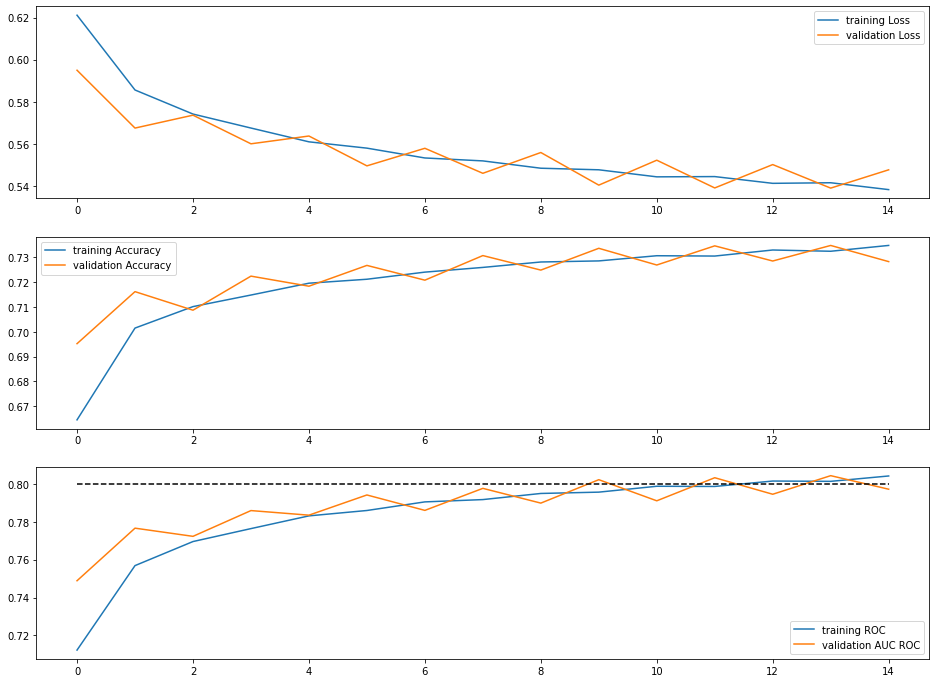

100%|██████████| 779/779 [00:03<00:00, 195.29it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

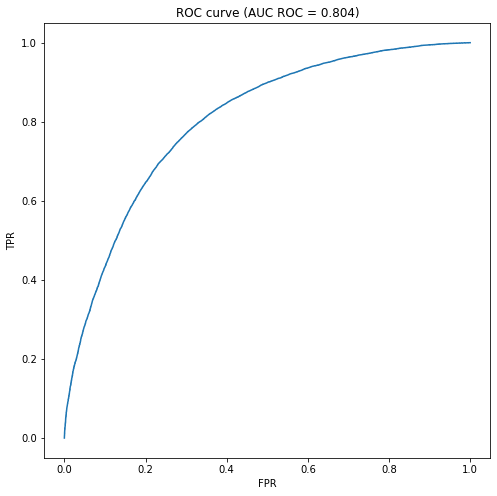

{'trainingLoss': [0.6211143802830493,
  0.585640344938919,
  0.5742301016607119,
  0.567594551019826,
  0.5610568327522873,
  0.5580609305476248,
  0.5533981174446014,
  0.5520087481651493,
  0.548535447527074,
  0.5477898752226568,
  0.544446798689075,
  0.544570054713236,
  0.5413677301687728,
  0.5416475897077895,
  0.5383876816995545],
 'trainingAccuracy': [0.6645493083444891,
  0.7014970995091477,
  0.7101360999553771,
  0.7147991967871486,
  0.7195604640785364,
  0.7211557340473004,
  0.7240205265506471,
  0.7259170013386881,
  0.7281012940651496,
  0.7285341365461847,
  0.7306224899598394,
  0.7304908522980812,
  0.7329272646140116,
  0.7324230254350736,
  0.7347679607318162],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'trainingAUC': [0.7122920672326869,
  0.7568706513096861,
  0.7695667457772982,
  0.7763992891791272,
  0.7831141040636344,
  0.7859553889114892,
  0.7904968521316164,
  0.7917145058094444,
  0.7949463103840817,
  0.7956413481682194,
  0.79874

In [ ]:
 doExperiment(ConvNeXt(in_chans=2, num_classes=1, depths=[1,1,3,1], dims=[64, 128, 128, 256]), 
             learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="ConvNeXt_1_1_3_1_morechannels_AUC={}.pth")

# Ensembles

## Ensemble Model

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models,policy="mean", from_state_dict=True, Model=None):
        super(EnsembleModel, self).__init__()

        if from_state_dict:
            self.models = []
            for m in models:
              self.models.append(Model().to(device))
              self.models[-1].load_state_dict(m)
        else:
          self.models = models
        #self.activtion = nn.Sigmoid()
        self.policy = policy

    def set_averaging_policy(self, policy):
      self.policy = policy
    
    def forward(self, x):
        predictions = []

        for i in range(0, len(self.models)):
          predictions.append(self.models[i](x))

        predictions = torch.cat(predictions, dim=1)

        if self.policy == "mean":
          predictions = torch.mean(predictions, dim=1)
        if self.policy == "harmonic_mean":
          predictions = predictions.shape[1] / ( torch.sum(1 / predictions, dim=1))

        return predictions.reshape(-1, 1)

In [ ]:
class smallModelForEnsemble(nn.Module):
    def __init__(self):
        super(smallModelForEnsemble, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv3 = self.pool1(conv3)
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.pool2(conv5)

        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)


## Dataset for Ensemble (sampling with replacement)

In [ ]:
training_dataset_ensemble    = PhotonElectronDatasetWithReplacement(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset_ensemble  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_ensemble_size = len(training_dataset_ensemble)
validation_ensemble_ds_size = len(validation_dataset_ensemble)

print(f"training size : {training_ds_ensemble_size}")
print(f"validation size : {validation_ensemble_ds_size}")

train_dataloader_ensemble      = DataLoader(training_dataset_ensemble, batch_size=batch_size, shuffle=False)
validation_dataloader_ensemble = DataLoader(validation_dataset_ensemble, batch_size=batch_size, shuffle=False)

training size : 448200
validation size : 49800


## Train Ensemble and evaluation final

ENSEMBLE MODEL 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6028073549568653, accuracy : 0.6801205277442932, AUC ROC 0.7365525363866501: 100%|██████████| 7004/7004 [03:21<00:00, 34.78it/s]


TRAINING ; Loss: 0.6028 Acc: 0.6801 AUC ROC : 0.7365 Time taken : 201.54


100%|██████████| 779/779 [00:02<00:00, 277.12it/s]


VALIDATION : Loss: 0.5932 Acc: 0.6918 AUC ROC : 0.7592 Time taken : 2.84
Epoch 1/6
----------


loss = 0.5605770746767521, accuracy : 0.71875, AUC ROC 0.7831027746588629: 100%|██████████| 7004/7004 [03:14<00:00, 35.97it/s]


TRAINING ; Loss: 0.5606 Acc: 0.7188 AUC ROC : 0.7831 Time taken : 194.99


100%|██████████| 779/779 [00:02<00:00, 273.73it/s]


VALIDATION : Loss: 0.5476 Acc: 0.7260 AUC ROC : 0.7959 Time taken : 2.88
Epoch 2/6
----------


loss = 0.5513510194080217, accuracy : 0.7260423898696899, AUC ROC 0.7922590980548468: 100%|██████████| 7004/7004 [03:14<00:00, 36.07it/s]


TRAINING ; Loss: 0.5514 Acc: 0.7260 AUC ROC : 0.7922 Time taken : 194.46


100%|██████████| 779/779 [00:02<00:00, 261.63it/s]


VALIDATION : Loss: 0.5550 Acc: 0.7252 AUC ROC : 0.7911 Time taken : 3.0
Epoch 3/6
----------


loss = 0.5466540056509631, accuracy : 0.729209840297699, AUC ROC 0.7965029123235021: 100%|██████████| 7004/7004 [03:12<00:00, 36.31it/s]


TRAINING ; Loss: 0.5467 Acc: 0.7292 AUC ROC : 0.7965 Time taken : 193.18


100%|██████████| 779/779 [00:02<00:00, 276.16it/s]


VALIDATION : Loss: 0.5469 Acc: 0.7277 AUC ROC : 0.8017 Time taken : 2.84
Epoch 4/6
----------


loss = 0.5422668928376266, accuracy : 0.732171893119812, AUC ROC 0.8006229613146145: 100%|██████████| 7004/7004 [03:13<00:00, 36.20it/s]


TRAINING ; Loss: 0.5422 Acc: 0.7322 AUC ROC : 0.8006 Time taken : 193.73


100%|██████████| 779/779 [00:02<00:00, 279.39it/s]


VALIDATION : Loss: 0.5578 Acc: 0.7230 AUC ROC : 0.7954 Time taken : 2.81
Epoch 5/6
----------


loss = 0.5408473355259215, accuracy : 0.733479917049408, AUC ROC 0.8019687175685133: 100%|██████████| 7004/7004 [03:11<00:00, 36.50it/s]


TRAINING ; Loss: 0.5408 Acc: 0.7335 AUC ROC : 0.8020 Time taken : 192.15


100%|██████████| 779/779 [00:02<00:00, 287.03it/s]


VALIDATION : Loss: 0.5372 Acc: 0.7371 AUC ROC : 0.8058 Time taken : 2.74
Epoch 6/6
----------


loss = 0.5371913187886987, accuracy : 0.735785722732544, AUC ROC 0.8051640622412389: 100%|██████████| 7004/7004 [03:14<00:00, 36.09it/s]


TRAINING ; Loss: 0.5372 Acc: 0.7358 AUC ROC : 0.8052 Time taken : 194.35


100%|██████████| 779/779 [00:02<00:00, 263.89it/s]


VALIDATION : Loss: 0.5814 Acc: 0.6942 AUC ROC : 0.7857 Time taken : 2.98
Training complete in 23m 5s


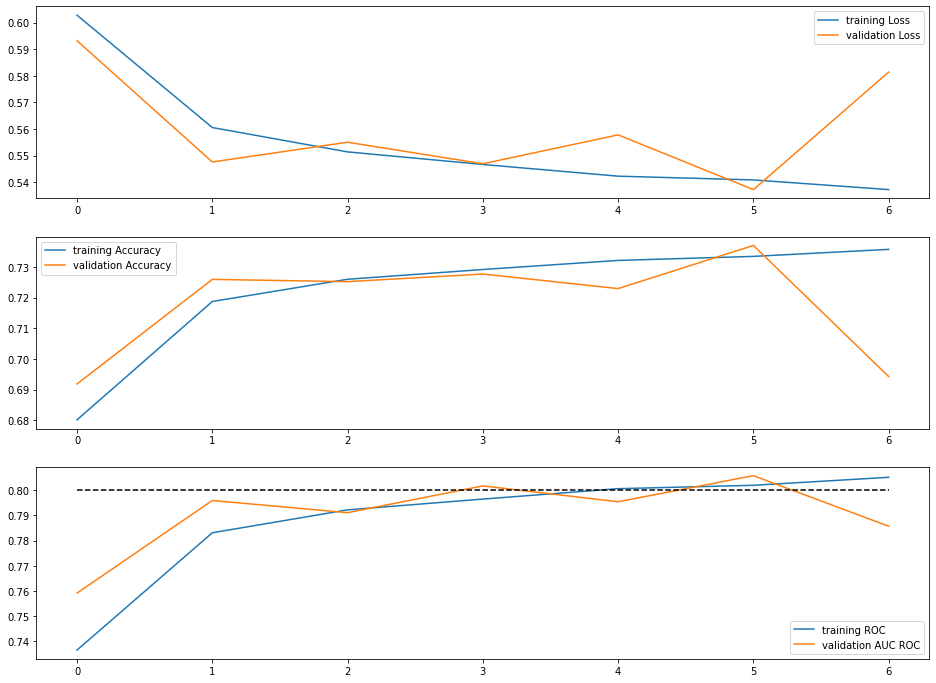

100%|██████████| 779/779 [00:02<00:00, 304.30it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

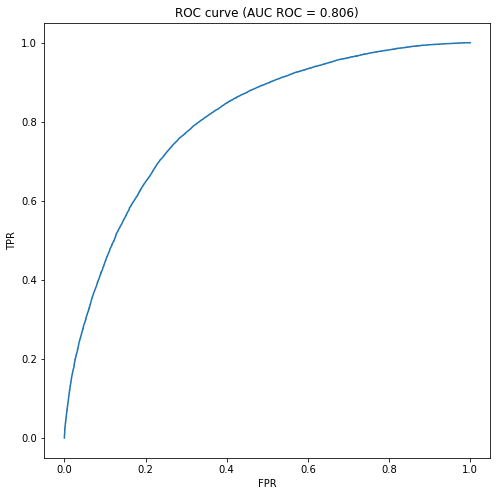

ENSEMBLE MODEL 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6043412465793746, accuracy : 0.6782388091087341, AUC ROC 0.7345473883019409: 100%|██████████| 7004/7004 [03:13<00:00, 36.21it/s]


TRAINING ; Loss: 0.6043 Acc: 0.6783 AUC ROC : 0.7346 Time taken : 193.58


100%|██████████| 779/779 [00:02<00:00, 287.08it/s]


VALIDATION : Loss: 0.6376 Acc: 0.6256 AUC ROC : 0.7437 Time taken : 2.74
Epoch 1/6
----------


loss = 0.5603375151327679, accuracy : 0.7189352512359619, AUC ROC 0.7834714096307772: 100%|██████████| 7004/7004 [03:10<00:00, 36.69it/s]


TRAINING ; Loss: 0.5603 Acc: 0.7189 AUC ROC : 0.7835 Time taken : 191.18


100%|██████████| 779/779 [00:02<00:00, 270.77it/s]


VALIDATION : Loss: 0.5478 Acc: 0.7253 AUC ROC : 0.7966 Time taken : 2.9
Epoch 2/6
----------


loss = 0.5508365182025092, accuracy : 0.7258281111717224, AUC ROC 0.7927447166416679: 100%|██████████| 7004/7004 [03:09<00:00, 36.96it/s]


TRAINING ; Loss: 0.5508 Acc: 0.7259 AUC ROC : 0.7928 Time taken : 189.77


100%|██████████| 779/779 [00:02<00:00, 300.18it/s]


VALIDATION : Loss: 0.6853 Acc: 0.5461 AUC ROC : 0.7374 Time taken : 2.62
Epoch 3/6
----------


loss = 0.5462152293281896, accuracy : 0.7298147082328796, AUC ROC 0.7968590212751117: 100%|██████████| 7004/7004 [03:09<00:00, 36.95it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7298 AUC ROC : 0.7969 Time taken : 189.85


100%|██████████| 779/779 [00:02<00:00, 301.99it/s]


VALIDATION : Loss: 0.5411 Acc: 0.7317 AUC ROC : 0.8037 Time taken : 2.6
Epoch 4/6
----------


loss = 0.5416680307899202, accuracy : 0.7324910759925842, AUC ROC 0.8011040968550921: 100%|██████████| 7004/7004 [03:12<00:00, 36.46it/s]


TRAINING ; Loss: 0.5417 Acc: 0.7325 AUC ROC : 0.8011 Time taken : 192.35


100%|██████████| 779/779 [00:02<00:00, 291.66it/s]


VALIDATION : Loss: 0.7506 Acc: 0.4979 AUC ROC : 0.5187 Time taken : 2.69
Epoch 5/6
----------


loss = 0.5395834765647138, accuracy : 0.7342901825904846, AUC ROC 0.8029840331478565: 100%|██████████| 7004/7004 [03:12<00:00, 36.36it/s]


TRAINING ; Loss: 0.5396 Acc: 0.7343 AUC ROC : 0.8030 Time taken : 192.89


100%|██████████| 779/779 [00:02<00:00, 281.85it/s]


VALIDATION : Loss: 0.5732 Acc: 0.7185 AUC ROC : 0.8002 Time taken : 2.79
Epoch 6/6
----------


loss = 0.5357658123927457, accuracy : 0.7368325591087341, AUC ROC 0.8064121513035397: 100%|██████████| 7004/7004 [03:09<00:00, 36.90it/s]


TRAINING ; Loss: 0.5357 Acc: 0.7369 AUC ROC : 0.8064 Time taken : 190.1


100%|██████████| 779/779 [00:02<00:00, 296.09it/s]


VALIDATION : Loss: 0.6291 Acc: 0.6144 AUC ROC : 0.7424 Time taken : 2.65
Training complete in 22m 39s


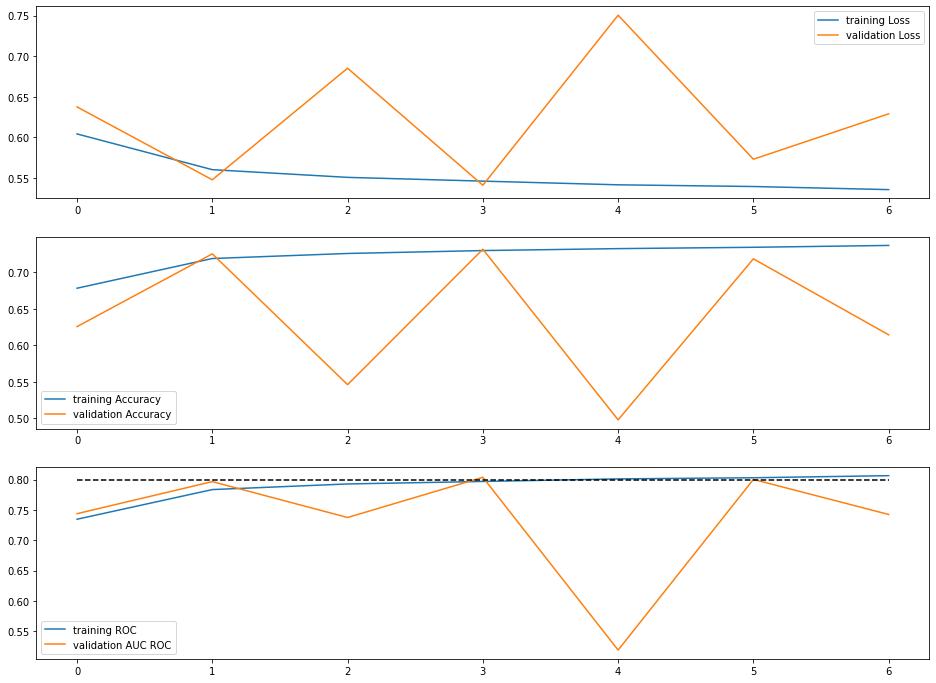

100%|██████████| 779/779 [00:02<00:00, 312.47it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

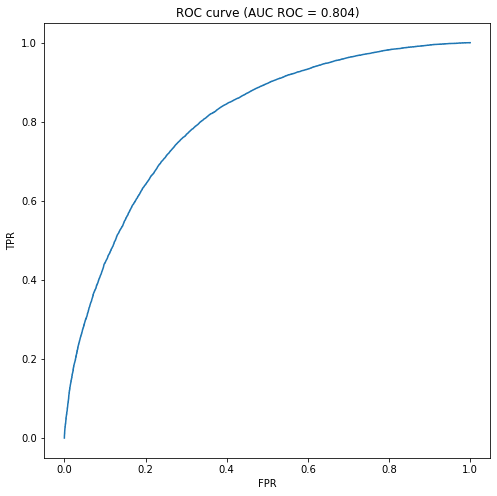

ENSEMBLE MODEL 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6025629079171589, accuracy : 0.6805156469345093, AUC ROC 0.7367893105757167: 100%|██████████| 7004/7004 [03:15<00:00, 35.91it/s]


TRAINING ; Loss: 0.6026 Acc: 0.6805 AUC ROC : 0.7368 Time taken : 195.2


100%|██████████| 779/779 [00:02<00:00, 276.88it/s]


VALIDATION : Loss: 0.5776 Acc: 0.7039 AUC ROC : 0.7762 Time taken : 2.84
Epoch 1/6
----------


loss = 0.5596734020709991, accuracy : 0.719633936882019, AUC ROC 0.7840485727149391: 100%|██████████| 7004/7004 [03:16<00:00, 35.61it/s]


TRAINING ; Loss: 0.5597 Acc: 0.7196 AUC ROC : 0.7841 Time taken : 196.97


100%|██████████| 779/779 [00:02<00:00, 274.36it/s]


VALIDATION : Loss: 0.5519 Acc: 0.7241 AUC ROC : 0.7931 Time taken : 2.86
Epoch 2/6
----------


loss = 0.550804988358702, accuracy : 0.7261361479759216, AUC ROC 0.7926186832114052: 100%|██████████| 7004/7004 [03:07<00:00, 37.30it/s]


TRAINING ; Loss: 0.5508 Acc: 0.7262 AUC ROC : 0.7926 Time taken : 188.07


100%|██████████| 779/779 [00:02<00:00, 296.68it/s]


VALIDATION : Loss: 0.5663 Acc: 0.7151 AUC ROC : 0.7908 Time taken : 2.65
Epoch 3/6
----------


loss = 0.5460639881449086, accuracy : 0.7296428680419922, AUC ROC 0.7971546526430545: 100%|██████████| 7004/7004 [03:06<00:00, 37.61it/s]


TRAINING ; Loss: 0.5461 Acc: 0.7296 AUC ROC : 0.7972 Time taken : 186.49


100%|██████████| 779/779 [00:02<00:00, 305.19it/s]


VALIDATION : Loss: 0.5394 Acc: 0.7336 AUC ROC : 0.8033 Time taken : 2.57
Epoch 4/6
----------


loss = 0.5415289529689721, accuracy : 0.7330178618431091, AUC ROC 0.8012485420163273: 100%|██████████| 7004/7004 [03:13<00:00, 36.11it/s]


TRAINING ; Loss: 0.5415 Acc: 0.7330 AUC ROC : 0.8012 Time taken : 194.23


100%|██████████| 779/779 [00:02<00:00, 282.75it/s]


VALIDATION : Loss: 0.5478 Acc: 0.7285 AUC ROC : 0.7959 Time taken : 2.78
Epoch 5/6
----------


loss = 0.5395693203253406, accuracy : 0.734499990940094, AUC ROC 0.8031059187542214: 100%|██████████| 7004/7004 [03:13<00:00, 36.18it/s]


TRAINING ; Loss: 0.5395 Acc: 0.7345 AUC ROC : 0.8031 Time taken : 193.9


100%|██████████| 779/779 [00:02<00:00, 289.03it/s]


VALIDATION : Loss: 0.5366 Acc: 0.7356 AUC ROC : 0.8063 Time taken : 2.72
Epoch 6/6
----------


loss = 0.5362189741688115, accuracy : 0.7365156412124634, AUC ROC 0.8060741933573259: 100%|██████████| 7004/7004 [03:05<00:00, 37.74it/s]


TRAINING ; Loss: 0.5362 Acc: 0.7365 AUC ROC : 0.8061 Time taken : 185.85


100%|██████████| 779/779 [00:02<00:00, 308.02it/s]


VALIDATION : Loss: 0.5790 Acc: 0.7078 AUC ROC : 0.7760 Time taken : 2.55
Training complete in 22m 40s


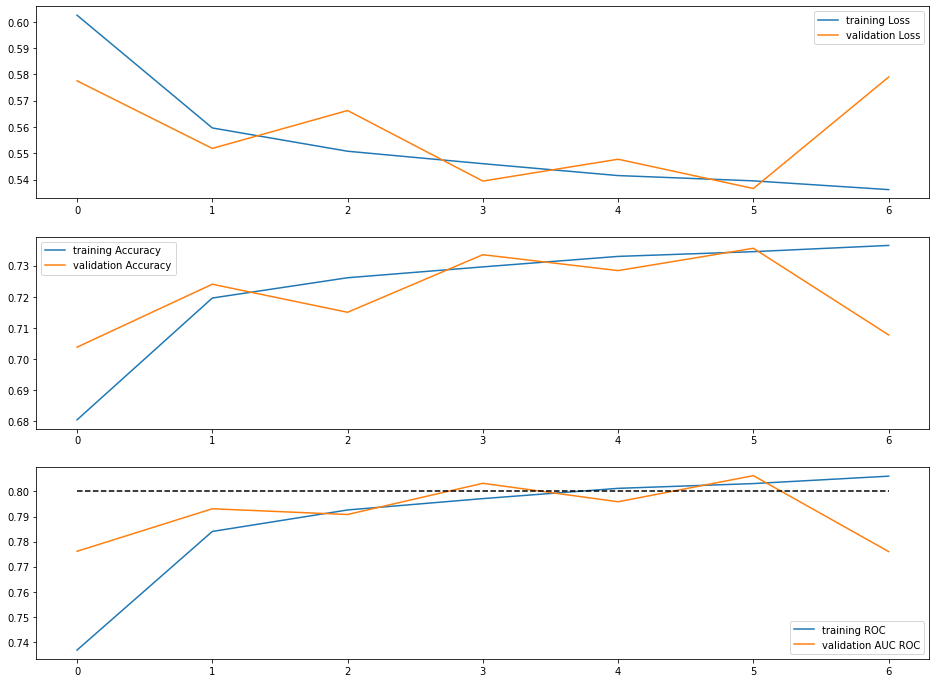

100%|██████████| 779/779 [00:02<00:00, 314.12it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

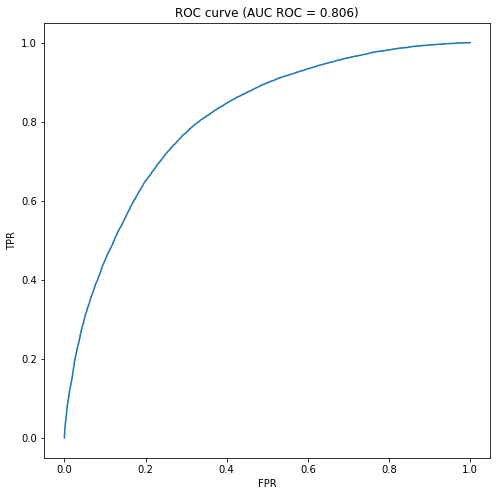

ENSEMBLE MODEL 3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6039170978622778, accuracy : 0.678781270980835, AUC ROC 0.7346307702375343: 100%|██████████| 7004/7004 [03:10<00:00, 36.71it/s]


TRAINING ; Loss: 0.6039 Acc: 0.6788 AUC ROC : 0.7347 Time taken : 190.94


100%|██████████| 779/779 [00:02<00:00, 277.82it/s]


VALIDATION : Loss: 0.5798 Acc: 0.7026 AUC ROC : 0.7796 Time taken : 2.83
Epoch 1/6
----------


loss = 0.5602456497890609, accuracy : 0.7193191647529602, AUC ROC 0.7833835898803881: 100%|██████████| 7004/7004 [03:12<00:00, 36.30it/s]


TRAINING ; Loss: 0.5602 Acc: 0.7193 AUC ROC : 0.7834 Time taken : 193.21


100%|██████████| 779/779 [00:02<00:00, 285.01it/s]


VALIDATION : Loss: 0.5448 Acc: 0.7300 AUC ROC : 0.7980 Time taken : 2.76
Epoch 2/6
----------


loss = 0.5506087697318622, accuracy : 0.7265133857727051, AUC ROC 0.7927670492275114: 100%|██████████| 7004/7004 [03:08<00:00, 37.24it/s]


TRAINING ; Loss: 0.5507 Acc: 0.7265 AUC ROC : 0.7927 Time taken : 188.32


100%|██████████| 779/779 [00:02<00:00, 277.08it/s]


VALIDATION : Loss: 0.5794 Acc: 0.7030 AUC ROC : 0.7879 Time taken : 2.83
Epoch 3/6
----------


loss = 0.5456765430697373, accuracy : 0.7297879457473755, AUC ROC 0.7974054615272211: 100%|██████████| 7004/7004 [03:06<00:00, 37.47it/s]


TRAINING ; Loss: 0.5457 Acc: 0.7298 AUC ROC : 0.7974 Time taken : 187.21


100%|██████████| 779/779 [00:02<00:00, 284.43it/s]


VALIDATION : Loss: 0.5381 Acc: 0.7351 AUC ROC : 0.8043 Time taken : 2.76
Epoch 4/6
----------


loss = 0.5410282000175545, accuracy : 0.7331674098968506, AUC ROC 0.801633475377488: 100%|██████████| 7004/7004 [03:12<00:00, 36.30it/s]


TRAINING ; Loss: 0.5410 Acc: 0.7332 AUC ROC : 0.8016 Time taken : 193.23


100%|██████████| 779/779 [00:02<00:00, 279.52it/s]


VALIDATION : Loss: 0.5549 Acc: 0.7250 AUC ROC : 0.7923 Time taken : 2.81
Epoch 5/6
----------


loss = 0.5397957395570618, accuracy : 0.7339017987251282, AUC ROC 0.802888220177963: 100%|██████████| 7004/7004 [03:13<00:00, 36.12it/s]


TRAINING ; Loss: 0.5398 Acc: 0.7339 AUC ROC : 0.8029 Time taken : 194.19


100%|██████████| 779/779 [00:02<00:00, 277.50it/s]


VALIDATION : Loss: 0.5366 Acc: 0.7353 AUC ROC : 0.8062 Time taken : 2.83
Epoch 6/6
----------


loss = 0.5357220406276839, accuracy : 0.737120509147644, AUC ROC 0.8064381518959618: 100%|██████████| 7004/7004 [03:08<00:00, 37.19it/s]


TRAINING ; Loss: 0.5357 Acc: 0.7371 AUC ROC : 0.8064 Time taken : 188.57


100%|██████████| 779/779 [00:02<00:00, 289.20it/s]


VALIDATION : Loss: 0.5475 Acc: 0.7282 AUC ROC : 0.7983 Time taken : 2.72
Training complete in 22m 35s


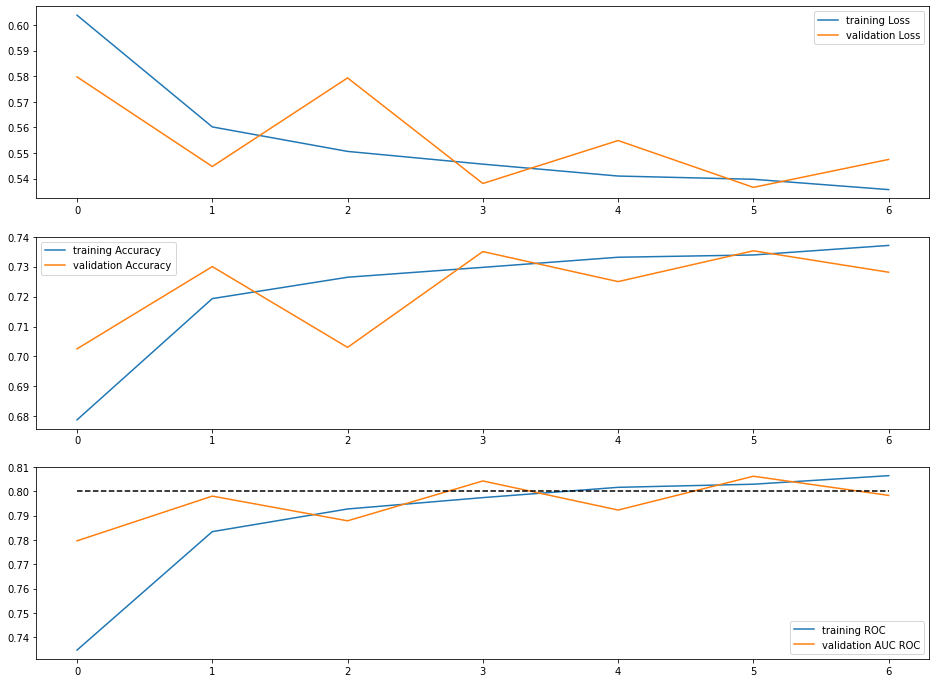

100%|██████████| 779/779 [00:02<00:00, 299.76it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

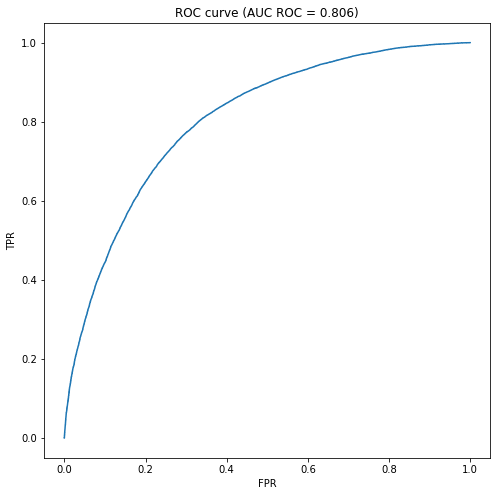

ENSEMBLE MODEL 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6040739321027483, accuracy : 0.6783192157745361, AUC ROC 0.7350009535059591: 100%|██████████| 7004/7004 [03:08<00:00, 37.19it/s]


TRAINING ; Loss: 0.6040 Acc: 0.6784 AUC ROC : 0.7350 Time taken : 188.49


100%|██████████| 779/779 [00:02<00:00, 291.38it/s]


VALIDATION : Loss: 0.5898 Acc: 0.6931 AUC ROC : 0.7617 Time taken : 2.69
Epoch 1/6
----------


loss = 0.5588237287317004, accuracy : 0.7196741104125977, AUC ROC 0.7847254416764111: 100%|██████████| 7004/7004 [03:12<00:00, 36.32it/s]


TRAINING ; Loss: 0.5588 Acc: 0.7197 AUC ROC : 0.7848 Time taken : 193.1


100%|██████████| 779/779 [00:02<00:00, 277.20it/s]


VALIDATION : Loss: 0.5486 Acc: 0.7271 AUC ROC : 0.7947 Time taken : 2.83
Epoch 2/6
----------


loss = 0.5507986530193261, accuracy : 0.7267611622810364, AUC ROC 0.792700797964828: 100%|██████████| 7004/7004 [03:06<00:00, 37.48it/s]


TRAINING ; Loss: 0.5508 Acc: 0.7268 AUC ROC : 0.7927 Time taken : 187.12


100%|██████████| 779/779 [00:02<00:00, 289.48it/s]


VALIDATION : Loss: 0.5814 Acc: 0.7053 AUC ROC : 0.7906 Time taken : 2.71
Epoch 3/6
----------


loss = 0.5462121359407902, accuracy : 0.7302500009536743, AUC ROC 0.796936441390297: 100%|██████████| 7004/7004 [03:07<00:00, 37.27it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7303 AUC ROC : 0.7970 Time taken : 188.19


100%|██████████| 779/779 [00:02<00:00, 264.08it/s]


VALIDATION : Loss: 0.5403 Acc: 0.7354 AUC ROC : 0.8036 Time taken : 2.97
Epoch 4/6
----------


loss = 0.5418716326057911, accuracy : 0.7328615784645081, AUC ROC 0.8010290974569515: 100%|██████████| 7004/7004 [03:13<00:00, 36.29it/s]


TRAINING ; Loss: 0.5419 Acc: 0.7329 AUC ROC : 0.8010 Time taken : 193.29


100%|██████████| 779/779 [00:02<00:00, 287.05it/s]


VALIDATION : Loss: 0.5557 Acc: 0.7233 AUC ROC : 0.7960 Time taken : 2.74
Epoch 5/6
----------


loss = 0.5401839574021953, accuracy : 0.7338035702705383, AUC ROC 0.8024947295108946: 100%|██████████| 7004/7004 [03:13<00:00, 36.26it/s]


TRAINING ; Loss: 0.5402 Acc: 0.7338 AUC ROC : 0.8025 Time taken : 193.44


100%|██████████| 779/779 [00:02<00:00, 284.00it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7351 AUC ROC : 0.8061 Time taken : 2.77
Epoch 6/6
----------


loss = 0.5367441398075649, accuracy : 0.7367566823959351, AUC ROC 0.8055773170938454: 100%|██████████| 7004/7004 [03:06<00:00, 37.56it/s]


TRAINING ; Loss: 0.5368 Acc: 0.7367 AUC ROC : 0.8055 Time taken : 186.76


100%|██████████| 779/779 [00:02<00:00, 308.24it/s]


VALIDATION : Loss: 0.5496 Acc: 0.7309 AUC ROC : 0.7997 Time taken : 2.55
Training complete in 22m 30s


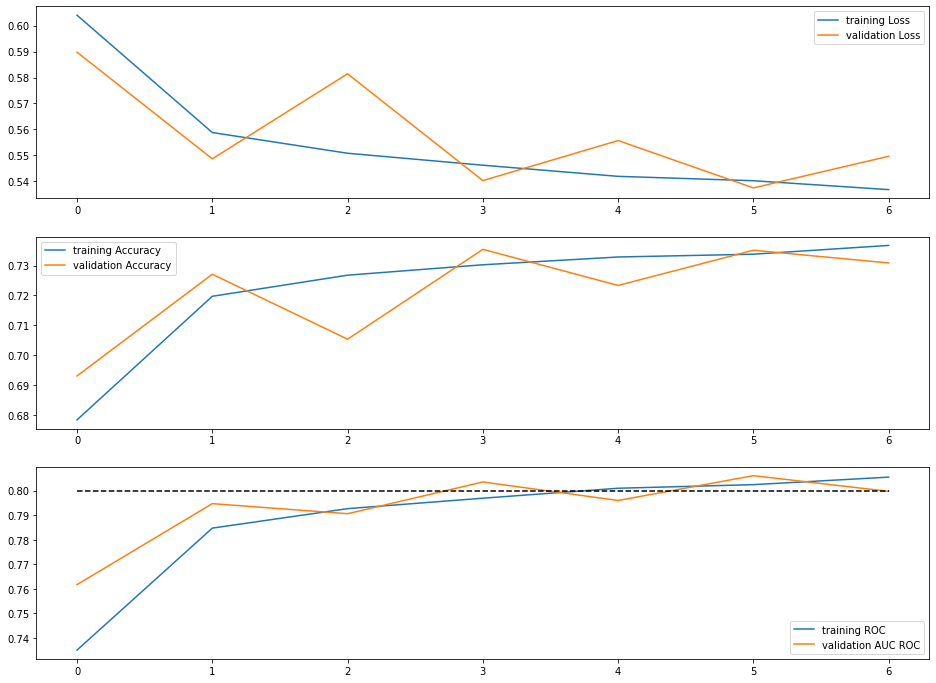

100%|██████████| 779/779 [00:02<00:00, 308.78it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

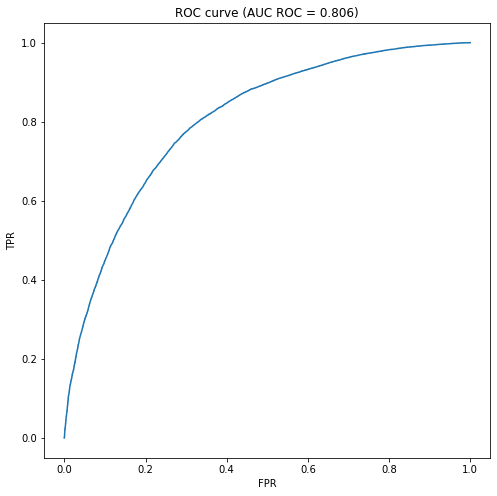

ENSEMBLE MODEL 5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6017944528673377, accuracy : 0.6806160807609558, AUC ROC 0.7373787270567215: 100%|██████████| 7004/7004 [03:12<00:00, 36.36it/s]


TRAINING ; Loss: 0.6018 Acc: 0.6806 AUC ROC : 0.7374 Time taken : 192.79


100%|██████████| 779/779 [00:02<00:00, 268.14it/s]


VALIDATION : Loss: 0.5865 Acc: 0.7079 AUC ROC : 0.7726 Time taken : 2.93
Epoch 1/6
----------


loss = 0.5601502694061824, accuracy : 0.7190803289413452, AUC ROC 0.7836647048259668: 100%|██████████| 7004/7004 [03:13<00:00, 36.17it/s]


TRAINING ; Loss: 0.5602 Acc: 0.7191 AUC ROC : 0.7837 Time taken : 193.95


100%|██████████| 779/779 [00:02<00:00, 271.38it/s]


VALIDATION : Loss: 0.5495 Acc: 0.7266 AUC ROC : 0.7959 Time taken : 2.89
Epoch 2/6
----------


loss = 0.5505025044211319, accuracy : 0.7263683080673218, AUC ROC 0.7929752749380776: 100%|██████████| 7004/7004 [03:08<00:00, 37.14it/s]


TRAINING ; Loss: 0.5505 Acc: 0.7264 AUC ROC : 0.7930 Time taken : 188.86


100%|██████████| 779/779 [00:02<00:00, 292.18it/s]


VALIDATION : Loss: 0.5587 Acc: 0.7187 AUC ROC : 0.7871 Time taken : 2.69
Epoch 3/6
----------


loss = 0.545907158515283, accuracy : 0.729785680770874, AUC ROC 0.7972227824317846: 100%|██████████| 7004/7004 [03:08<00:00, 37.24it/s]


TRAINING ; Loss: 0.5459 Acc: 0.7298 AUC ROC : 0.7972 Time taken : 188.35


100%|██████████| 779/779 [00:02<00:00, 290.73it/s]


VALIDATION : Loss: 0.5405 Acc: 0.7335 AUC ROC : 0.8038 Time taken : 2.7
Epoch 4/6
----------


loss = 0.5418501882851123, accuracy : 0.7325624823570251, AUC ROC 0.8009169268674268: 100%|██████████| 7004/7004 [03:14<00:00, 36.04it/s]


TRAINING ; Loss: 0.5418 Acc: 0.7326 AUC ROC : 0.8009 Time taken : 194.59


100%|██████████| 779/779 [00:02<00:00, 278.16it/s]


VALIDATION : Loss: 0.5712 Acc: 0.7118 AUC ROC : 0.7884 Time taken : 2.82
Epoch 5/6
----------


loss = 0.5397129667869636, accuracy : 0.7342053651809692, AUC ROC 0.802848636334331: 100%|██████████| 7004/7004 [03:13<00:00, 36.19it/s]


TRAINING ; Loss: 0.5397 Acc: 0.7342 AUC ROC : 0.8029 Time taken : 193.79


100%|██████████| 779/779 [00:02<00:00, 263.04it/s]


VALIDATION : Loss: 0.5366 Acc: 0.7361 AUC ROC : 0.8058 Time taken : 2.99
Epoch 6/6
----------


loss = 0.5363547651725156, accuracy : 0.7369576096534729, AUC ROC 0.8059475426161102: 100%|██████████| 7004/7004 [03:07<00:00, 37.31it/s]


TRAINING ; Loss: 0.5364 Acc: 0.7369 AUC ROC : 0.8059 Time taken : 188.0


100%|██████████| 779/779 [00:02<00:00, 301.55it/s]


VALIDATION : Loss: 0.5511 Acc: 0.7278 AUC ROC : 0.7976 Time taken : 2.61
Training complete in 22m 40s


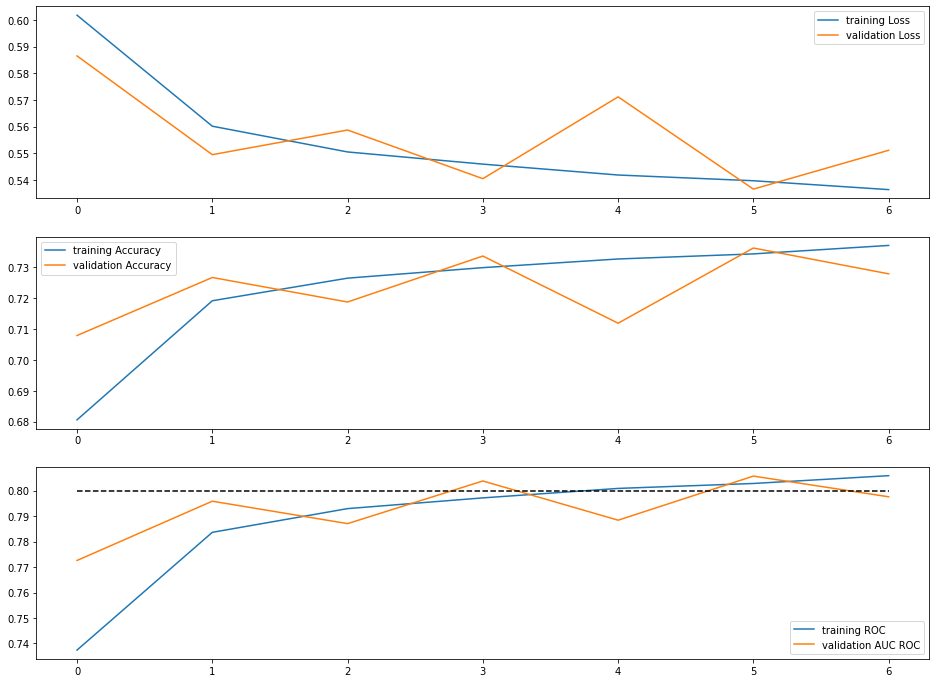

100%|██████████| 779/779 [00:02<00:00, 299.03it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

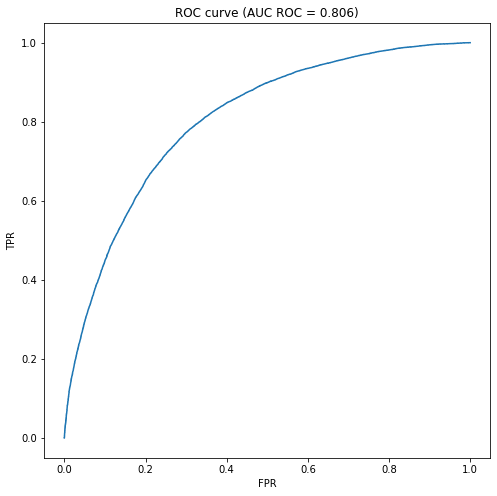

ENSEMBLE MODEL 6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6032451900201184, accuracy : 0.678700864315033, AUC ROC 0.7357674223023571: 100%|██████████| 7004/7004 [03:10<00:00, 36.84it/s]


TRAINING ; Loss: 0.6033 Acc: 0.6787 AUC ROC : 0.7358 Time taken : 190.27


100%|██████████| 779/779 [00:02<00:00, 283.50it/s]


VALIDATION : Loss: 0.6142 Acc: 0.6572 AUC ROC : 0.7735 Time taken : 2.77
Epoch 1/6
----------


loss = 0.5591306799948216, accuracy : 0.7203481793403625, AUC ROC 0.7845320911847206: 100%|██████████| 7004/7004 [03:14<00:00, 36.01it/s]


TRAINING ; Loss: 0.5591 Acc: 0.7204 AUC ROC : 0.7845 Time taken : 194.77


100%|██████████| 779/779 [00:02<00:00, 281.29it/s]


VALIDATION : Loss: 0.5490 Acc: 0.7255 AUC ROC : 0.7959 Time taken : 2.79
Epoch 2/6
----------


loss = 0.550554108530283, accuracy : 0.7263013124465942, AUC ROC 0.7930287424500182: 100%|██████████| 7004/7004 [03:11<00:00, 36.61it/s]


TRAINING ; Loss: 0.5506 Acc: 0.7263 AUC ROC : 0.7930 Time taken : 191.62


100%|██████████| 779/779 [00:02<00:00, 286.92it/s]


VALIDATION : Loss: 0.5581 Acc: 0.7233 AUC ROC : 0.7918 Time taken : 2.74
Epoch 3/6
----------


loss = 0.5462356123626232, accuracy : 0.7295334935188293, AUC ROC 0.7968553640494642: 100%|██████████| 7004/7004 [03:09<00:00, 37.00it/s]


TRAINING ; Loss: 0.5462 Acc: 0.7295 AUC ROC : 0.7968 Time taken : 189.55


100%|██████████| 779/779 [00:02<00:00, 298.90it/s]


VALIDATION : Loss: 0.5515 Acc: 0.7281 AUC ROC : 0.7985 Time taken : 2.63
Epoch 4/6
----------


loss = 0.5414749642823423, accuracy : 0.7335602641105652, AUC ROC 0.801399742389588: 100%|██████████| 7004/7004 [03:13<00:00, 36.12it/s]


TRAINING ; Loss: 0.5415 Acc: 0.7336 AUC ROC : 0.8014 Time taken : 194.19


100%|██████████| 779/779 [00:02<00:00, 274.42it/s]


VALIDATION : Loss: 0.5569 Acc: 0.7210 AUC ROC : 0.7928 Time taken : 2.87
Epoch 5/6
----------


loss = 0.540003782838583, accuracy : 0.7342187166213989, AUC ROC 0.8026946255654587: 100%|██████████| 7004/7004 [03:13<00:00, 36.13it/s]


TRAINING ; Loss: 0.5400 Acc: 0.7342 AUC ROC : 0.8027 Time taken : 194.11


100%|██████████| 779/779 [00:02<00:00, 280.74it/s]


VALIDATION : Loss: 0.5416 Acc: 0.7336 AUC ROC : 0.8050 Time taken : 2.8
Epoch 6/6
----------


loss = 0.536230140549796, accuracy : 0.7363973259925842, AUC ROC 0.8060886925965473: 100%|██████████| 7004/7004 [03:07<00:00, 37.41it/s]


TRAINING ; Loss: 0.5362 Acc: 0.7364 AUC ROC : 0.8061 Time taken : 187.5


100%|██████████| 779/779 [00:02<00:00, 282.98it/s]


VALIDATION : Loss: 0.5640 Acc: 0.7187 AUC ROC : 0.7952 Time taken : 2.78
Training complete in 22m 41s


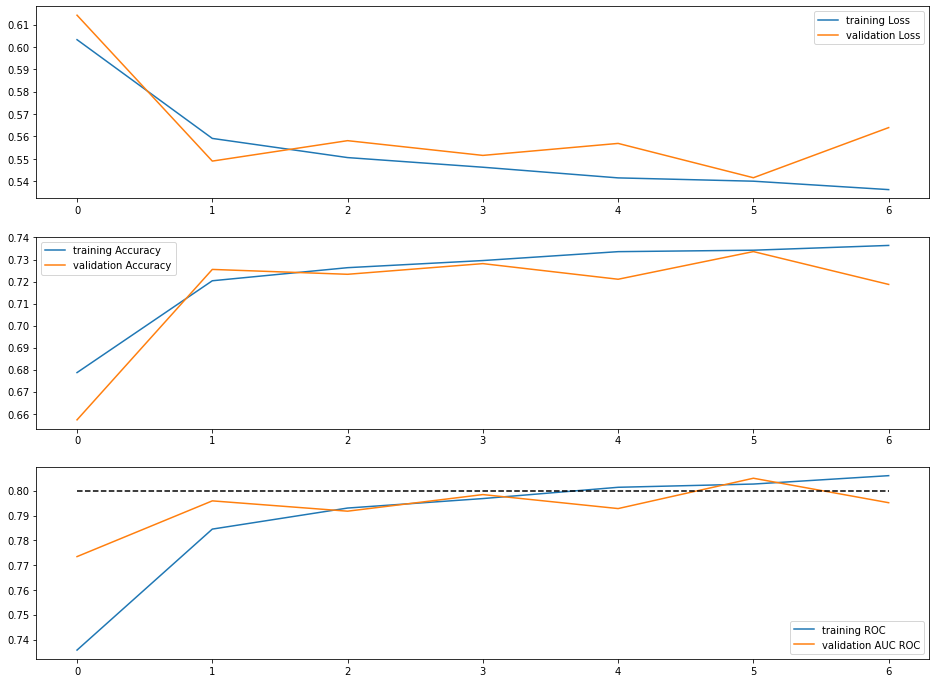

100%|██████████| 779/779 [00:02<00:00, 309.31it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

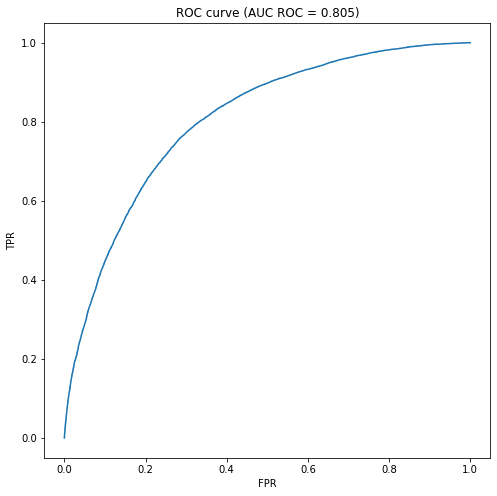

ENSEMBLE MODEL 7
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.603047822292362, accuracy : 0.6795892715454102, AUC ROC 0.7359392559502755: 100%|██████████| 7004/7004 [03:08<00:00, 37.07it/s]


TRAINING ; Loss: 0.6031 Acc: 0.6796 AUC ROC : 0.7359 Time taken : 189.08


100%|██████████| 779/779 [00:02<00:00, 295.01it/s]


VALIDATION : Loss: 0.5802 Acc: 0.7007 AUC ROC : 0.7705 Time taken : 2.66
Epoch 1/6
----------


loss = 0.5602098004392215, accuracy : 0.7191540002822876, AUC ROC 0.7835032586621893: 100%|██████████| 7004/7004 [03:14<00:00, 35.98it/s]


TRAINING ; Loss: 0.5602 Acc: 0.7192 AUC ROC : 0.7835 Time taken : 194.95


100%|██████████| 779/779 [00:02<00:00, 261.98it/s]


VALIDATION : Loss: 0.5464 Acc: 0.7284 AUC ROC : 0.7980 Time taken : 3.0
Epoch 2/6
----------


loss = 0.5505215761108058, accuracy : 0.7262834906578064, AUC ROC 0.7929892377092419: 100%|██████████| 7004/7004 [03:10<00:00, 36.86it/s]


TRAINING ; Loss: 0.5505 Acc: 0.7263 AUC ROC : 0.7930 Time taken : 190.31


100%|██████████| 779/779 [00:02<00:00, 295.79it/s]


VALIDATION : Loss: 0.5607 Acc: 0.7242 AUC ROC : 0.7925 Time taken : 2.66
Epoch 3/6
----------


loss = 0.546019144654274, accuracy : 0.7294241189956665, AUC ROC 0.7970821141594319: 100%|██████████| 7004/7004 [03:10<00:00, 36.68it/s]


TRAINING ; Loss: 0.5460 Acc: 0.7294 AUC ROC : 0.7971 Time taken : 191.19


100%|██████████| 779/779 [00:02<00:00, 295.41it/s]


VALIDATION : Loss: 0.5428 Acc: 0.7328 AUC ROC : 0.8033 Time taken : 2.66
Epoch 4/6
----------


loss = 0.5414173727588995, accuracy : 0.7332701086997986, AUC ROC 0.8013985956593072: 100%|██████████| 7004/7004 [03:15<00:00, 35.82it/s]


TRAINING ; Loss: 0.5414 Acc: 0.7333 AUC ROC : 0.8014 Time taken : 195.84


100%|██████████| 779/779 [00:02<00:00, 272.60it/s]


VALIDATION : Loss: 0.5722 Acc: 0.7168 AUC ROC : 0.7931 Time taken : 2.88
Epoch 5/6
----------


loss = 0.5401376773416996, accuracy : 0.733908474445343, AUC ROC 0.8025374121759525: 100%|██████████| 7004/7004 [03:14<00:00, 36.09it/s]


TRAINING ; Loss: 0.5402 Acc: 0.7339 AUC ROC : 0.8025 Time taken : 194.36


100%|██████████| 779/779 [00:02<00:00, 272.10it/s]


VALIDATION : Loss: 0.5373 Acc: 0.7348 AUC ROC : 0.8048 Time taken : 2.88
Epoch 6/6
----------


loss = 0.5361249607673713, accuracy : 0.7366562485694885, AUC ROC 0.8061823162399266: 100%|██████████| 7004/7004 [03:08<00:00, 37.08it/s]


TRAINING ; Loss: 0.5361 Acc: 0.7367 AUC ROC : 0.8062 Time taken : 189.14


100%|██████████| 779/779 [00:02<00:00, 293.85it/s]


VALIDATION : Loss: 0.5478 Acc: 0.7294 AUC ROC : 0.7981 Time taken : 2.68
Training complete in 22m 44s


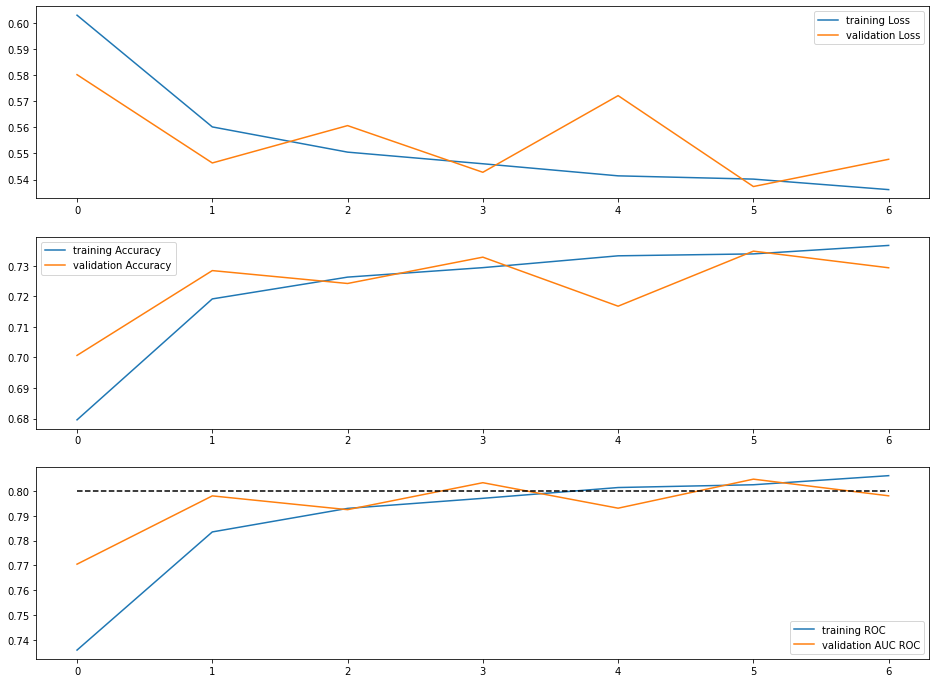

100%|██████████| 779/779 [00:02<00:00, 310.31it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

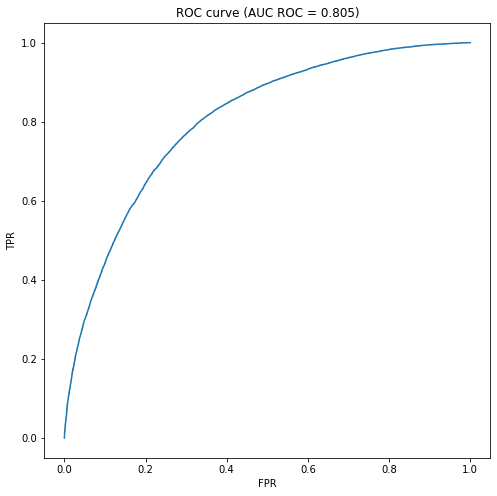

ENSEMBLE MODEL 8
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14  

loss = 0.6039342937043735, accuracy : 0.6791517734527588, AUC ROC 0.73470700819913: 100%|██████████| 7004/7004 [03:10<00:00, 36.68it/s]


TRAINING ; Loss: 0.6039 Acc: 0.6792 AUC ROC : 0.7347 Time taken : 191.11


100%|██████████| 779/779 [00:02<00:00, 287.39it/s]


VALIDATION : Loss: 0.5921 Acc: 0.6904 AUC ROC : 0.7721 Time taken : 2.74
Epoch 1/6
----------


loss = 0.559109598823956, accuracy : 0.7202544808387756, AUC ROC 0.784652764113094: 100%|██████████| 7004/7004 [03:15<00:00, 35.85it/s]


TRAINING ; Loss: 0.5591 Acc: 0.7202 AUC ROC : 0.7846 Time taken : 195.67


100%|██████████| 779/779 [00:02<00:00, 280.92it/s]


VALIDATION : Loss: 0.5449 Acc: 0.7297 AUC ROC : 0.7988 Time taken : 2.8
Epoch 2/6
----------


loss = 0.549672963815076, accuracy : 0.727165162563324, AUC ROC 0.7937034380050738: 100%|██████████| 7004/7004 [03:15<00:00, 35.91it/s]


TRAINING ; Loss: 0.5497 Acc: 0.7272 AUC ROC : 0.7937 Time taken : 195.29


100%|██████████| 779/779 [00:02<00:00, 281.19it/s]


VALIDATION : Loss: 0.5629 Acc: 0.7166 AUC ROC : 0.7861 Time taken : 2.79
Epoch 3/6
----------


loss = 0.5456361874341965, accuracy : 0.7296473383903503, AUC ROC 0.7975607505316894: 100%|██████████| 7004/7004 [03:14<00:00, 35.95it/s]


TRAINING ; Loss: 0.5456 Acc: 0.7296 AUC ROC : 0.7976 Time taken : 195.11


100%|██████████| 779/779 [00:02<00:00, 276.16it/s]


VALIDATION : Loss: 0.5410 Acc: 0.7335 AUC ROC : 0.8024 Time taken : 2.84
Epoch 4/6
----------


loss = 0.5415220430110183, accuracy : 0.7328771948814392, AUC ROC 0.8013196004364636: 100%|██████████| 7004/7004 [03:14<00:00, 36.07it/s]


TRAINING ; Loss: 0.5415 Acc: 0.7329 AUC ROC : 0.8013 Time taken : 194.43


100%|██████████| 779/779 [00:02<00:00, 275.92it/s]


VALIDATION : Loss: 0.5486 Acc: 0.7282 AUC ROC : 0.7970 Time taken : 2.85
Epoch 5/6
----------


loss = 0.5399156778241907, accuracy : 0.7340892553329468, AUC ROC 0.8026680642307615: 100%|██████████| 7004/7004 [03:13<00:00, 36.16it/s]


TRAINING ; Loss: 0.5399 Acc: 0.7341 AUC ROC : 0.8027 Time taken : 193.95


100%|██████████| 779/779 [00:02<00:00, 285.78it/s]


VALIDATION : Loss: 0.5370 Acc: 0.7373 AUC ROC : 0.8063 Time taken : 2.75
Epoch 6/6
----------


loss = 0.5359677867080485, accuracy : 0.7369441986083984, AUC ROC 0.8062110066968989: 100%|██████████| 7004/7004 [03:07<00:00, 37.36it/s]


TRAINING ; Loss: 0.5360 Acc: 0.7369 AUC ROC : 0.8062 Time taken : 187.75


100%|██████████| 779/779 [00:02<00:00, 304.56it/s]


VALIDATION : Loss: 0.5461 Acc: 0.7284 AUC ROC : 0.7979 Time taken : 2.58
Training complete in 22m 53s


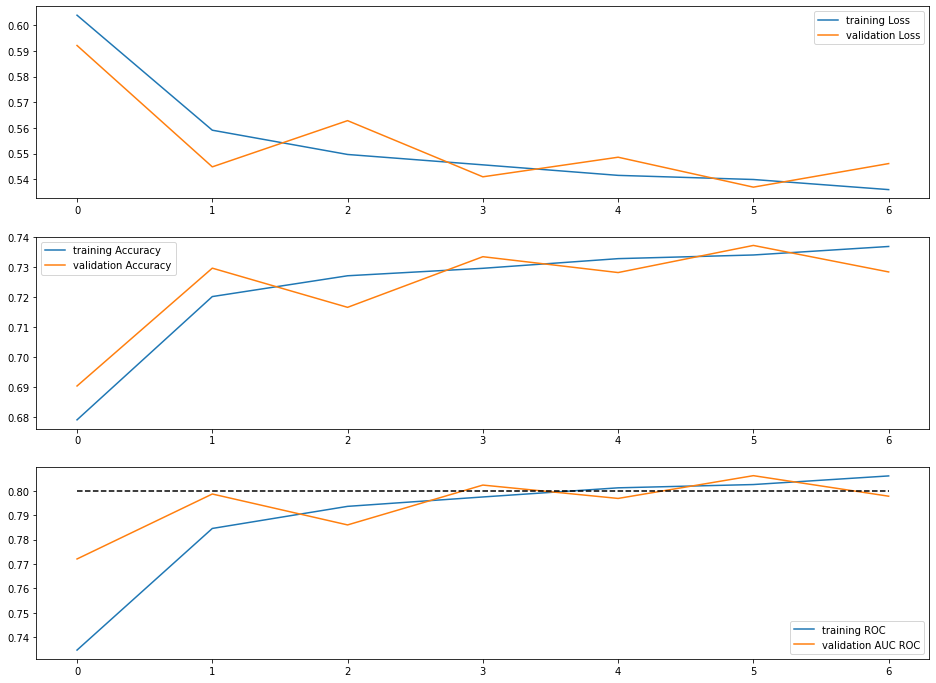

100%|██████████| 779/779 [00:02<00:00, 306.88it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

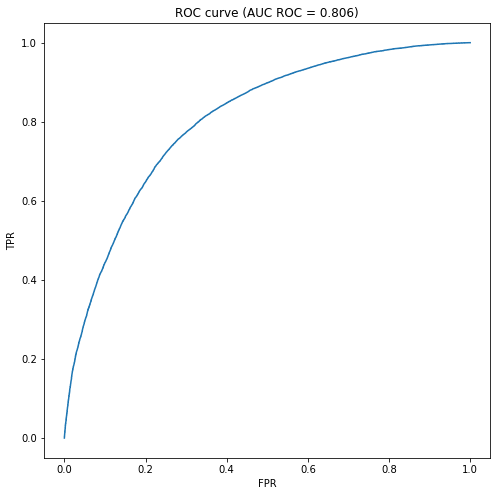

In [ ]:
n_models = 9
epochs_per_model = 7
models = []

for i in range(n_models):
  print("="*64)
  print(f"ENSEMBLE MODEL {i}")
  print("="*64)
  data = doExperiment(smallModelForEnsemble(), 
             learning_rate=5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=epochs_per_model,
             nameOfModel="smallCNN_ensemble" + str(i) + "={}.pth")
  models.append(data["best_model"])

In [ ]:
ensemble = EnsembleModel(models=models, policy="mean", from_state_dict=False).to(device) 
print(f"number of models : {len(ensemble.models)}")
eval_result = evaluate_model(ensemble, val_dl, len(val_ds))

number of models : 9


100%|██████████| 779/779 [00:11<00:00, 67.52it/s]

VALIDATION : Loss: 0.5331 Acc: 0.7383 AUC ROC : 0.8091 Time taken : 11.57


# Vision Transformers

## Mobile ViT

### Architecture

In [ ]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Reduce

# helpers

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer block described in ViT.
    Paper: https://arxiv.org/abs/2010.11929
    Based on: https://github.com/lucidrains/vit-pytorch
    """

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    """MV2 block described in MobileNetV2.
    Paper: https://arxiv.org/pdf/1801.04381
    Based on: https://github.com/tonylins/pytorch-mobilenet-v2
    """

    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d',
                      ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)',
                      h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT2(nn.Module):
    """MobileViT.
    Paper: https://arxiv.org/abs/2110.02178
    Based on: https://github.com/chinhsuanwu/mobilevit-pytorch
    """

    def __init__(
        self,
        image_size,
        dims,
        channels,
        num_classes,
        expansion=4,
        kernel_size=3,
        patch_size=(2, 2),
        depths=(2, 4, 3)
    ):
        super().__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = conv_nxn_bn(2, init_dim, stride=2)

        self.stem = nn.ModuleList([])
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))


        self.trunk = nn.ModuleList([])
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[2], channels[3], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[len(channels)-1],
                           kernel_size, patch_size, int(dims[0] * 2))
        ]))

        self.head = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)

        for conv in self.stem:
            x = conv(x)

        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)

        return self.head(x)


### Experiment 1 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             288
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              SiLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           1,024
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]             576
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              SiLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
         MV2Block-12           [-1, 32, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           4,096
      BatchNorm2d-14          [-1, 128,

loss = 0.6014894131294318, accuracy : 0.6799330115318298, AUC ROC 0.737566099600454: 100%|██████████| 7004/7004 [04:09<00:00, 28.07it/s]


TRAINING ; Loss: 0.6015 Acc: 0.6799 AUC ROC : 0.7376 Time taken : 249.7


100%|██████████| 779/779 [00:04<00:00, 170.18it/s]


VALIDATION : Loss: 0.5893 Acc: 0.6905 AUC ROC : 0.7685 Time taken : 4.6
Epoch 1/14
----------


loss = 0.5634974891160216, accuracy : 0.715874969959259, AUC ROC 0.7803817183812979: 100%|██████████| 7004/7004 [04:11<00:00, 27.80it/s]


TRAINING ; Loss: 0.5635 Acc: 0.7159 AUC ROC : 0.7804 Time taken : 252.7


100%|██████████| 779/779 [00:05<00:00, 154.22it/s]


VALIDATION : Loss: 0.5494 Acc: 0.7283 AUC ROC : 0.7955 Time taken : 5.07
Epoch 2/14
----------


loss = 0.5545357167337622, accuracy : 0.7226004600524902, AUC ROC 0.7890760029354488: 100%|██████████| 7004/7004 [04:10<00:00, 28.00it/s]


TRAINING ; Loss: 0.5545 Acc: 0.7226 AUC ROC : 0.7891 Time taken : 250.88


100%|██████████| 779/779 [00:04<00:00, 161.36it/s]


VALIDATION : Loss: 0.5928 Acc: 0.7037 AUC ROC : 0.7739 Time taken : 4.85
Epoch 3/14
----------


loss = 0.5508794010366712, accuracy : 0.725575864315033, AUC ROC 0.7927277014492995: 100%|██████████| 7004/7004 [04:10<00:00, 27.90it/s]


TRAINING ; Loss: 0.5509 Acc: 0.7256 AUC ROC : 0.7927 Time taken : 251.72


100%|██████████| 779/779 [00:05<00:00, 145.25it/s]


VALIDATION : Loss: 0.5395 Acc: 0.7334 AUC ROC : 0.8032 Time taken : 5.38
Epoch 4/14
----------


loss = 0.5468475819272655, accuracy : 0.7285981774330139, AUC ROC 0.7964982185788516: 100%|██████████| 7004/7004 [04:10<00:00, 27.96it/s]


TRAINING ; Loss: 0.5469 Acc: 0.7286 AUC ROC : 0.7965 Time taken : 251.22


100%|██████████| 779/779 [00:05<00:00, 154.96it/s]


VALIDATION : Loss: 0.5490 Acc: 0.7275 AUC ROC : 0.7957 Time taken : 5.05
Epoch 5/14
----------


loss = 0.5454854867032596, accuracy : 0.7292923927307129, AUC ROC 0.7978142886505624: 100%|██████████| 7004/7004 [04:10<00:00, 27.92it/s]


TRAINING ; Loss: 0.5455 Acc: 0.7293 AUC ROC : 0.7978 Time taken : 251.58


100%|██████████| 779/779 [00:05<00:00, 149.07it/s]


VALIDATION : Loss: 0.5408 Acc: 0.7315 AUC ROC : 0.8023 Time taken : 5.25
Epoch 6/14
----------


loss = 0.5419580814710685, accuracy : 0.7323482036590576, AUC ROC 0.8010327862491468: 100%|██████████| 7004/7004 [04:11<00:00, 27.81it/s]


TRAINING ; Loss: 0.5420 Acc: 0.7324 AUC ROC : 0.8010 Time taken : 252.62


100%|██████████| 779/779 [00:04<00:00, 167.94it/s]


VALIDATION : Loss: 0.5462 Acc: 0.7275 AUC ROC : 0.7977 Time taken : 4.66
Epoch 7/14
----------


loss = 0.5416273383072444, accuracy : 0.7322834730148315, AUC ROC 0.8013714540499659: 100%|██████████| 7004/7004 [04:11<00:00, 27.87it/s]


TRAINING ; Loss: 0.5416 Acc: 0.7323 AUC ROC : 0.8014 Time taken : 251.97


100%|██████████| 779/779 [00:04<00:00, 163.98it/s]


VALIDATION : Loss: 0.5370 Acc: 0.7345 AUC ROC : 0.8057 Time taken : 4.77
Epoch 8/14
----------


loss = 0.5390095688402653, accuracy : 0.7334218621253967, AUC ROC 0.8037169620906304: 100%|██████████| 7004/7004 [04:11<00:00, 27.83it/s]


TRAINING ; Loss: 0.5390 Acc: 0.7334 AUC ROC : 0.8037 Time taken : 252.41


100%|██████████| 779/779 [00:04<00:00, 169.29it/s]


VALIDATION : Loss: 0.5419 Acc: 0.7317 AUC ROC : 0.8011 Time taken : 4.62
Epoch 9/14
----------


loss = 0.5389759082453591, accuracy : 0.7341562509536743, AUC ROC 0.8037151841080139: 100%|██████████| 7004/7004 [04:11<00:00, 27.80it/s]


TRAINING ; Loss: 0.5390 Acc: 0.7342 AUC ROC : 0.8037 Time taken : 252.67


100%|██████████| 779/779 [00:04<00:00, 165.36it/s]


VALIDATION : Loss: 0.5341 Acc: 0.7374 AUC ROC : 0.8080 Time taken : 4.73
Epoch 10/14
----------


loss = 0.5362506437471934, accuracy : 0.7365446090698242, AUC ROC 0.8060885858976073: 100%|██████████| 7004/7004 [04:16<00:00, 27.34it/s]


TRAINING ; Loss: 0.5362 Acc: 0.7365 AUC ROC : 0.8061 Time taken : 256.84


100%|██████████| 779/779 [00:04<00:00, 160.89it/s]


VALIDATION : Loss: 0.5461 Acc: 0.7288 AUC ROC : 0.8015 Time taken : 4.86
Epoch 11/14
----------


loss = 0.5363558517055852, accuracy : 0.7358459830284119, AUC ROC 0.80589298537303: 100%|██████████| 7004/7004 [04:12<00:00, 27.72it/s]


TRAINING ; Loss: 0.5363 Acc: 0.7359 AUC ROC : 0.8059 Time taken : 253.39


100%|██████████| 779/779 [00:04<00:00, 163.47it/s]


VALIDATION : Loss: 0.5338 Acc: 0.7387 AUC ROC : 0.8082 Time taken : 4.79
Epoch 12/14
----------


loss = 0.5341844751834869, accuracy : 0.7374419569969177, AUC ROC 0.8079540798650342: 100%|██████████| 7004/7004 [04:11<00:00, 27.90it/s]


TRAINING ; Loss: 0.5342 Acc: 0.7374 AUC ROC : 0.8079 Time taken : 251.79


100%|██████████| 779/779 [00:04<00:00, 167.14it/s]


VALIDATION : Loss: 0.5422 Acc: 0.7318 AUC ROC : 0.8022 Time taken : 4.68
Epoch 13/14
----------


loss = 0.5341818266723837, accuracy : 0.7373504638671875, AUC ROC 0.8079045673397294: 100%|██████████| 7004/7004 [04:12<00:00, 27.75it/s]


TRAINING ; Loss: 0.5342 Acc: 0.7374 AUC ROC : 0.8079 Time taken : 253.13


100%|██████████| 779/779 [00:05<00:00, 152.49it/s]


VALIDATION : Loss: 0.5333 Acc: 0.7381 AUC ROC : 0.8091 Time taken : 5.13
Epoch 14/14
----------


loss = 0.5319536630809307, accuracy : 0.7386830449104309, AUC ROC 0.8098376529264858: 100%|██████████| 7004/7004 [04:12<00:00, 27.77it/s]


TRAINING ; Loss: 0.5320 Acc: 0.7386 AUC ROC : 0.8098 Time taken : 252.91


100%|██████████| 779/779 [00:04<00:00, 168.84it/s]


VALIDATION : Loss: 0.5428 Acc: 0.7306 AUC ROC : 0.8003 Time taken : 4.64
Training complete in 64m 19s


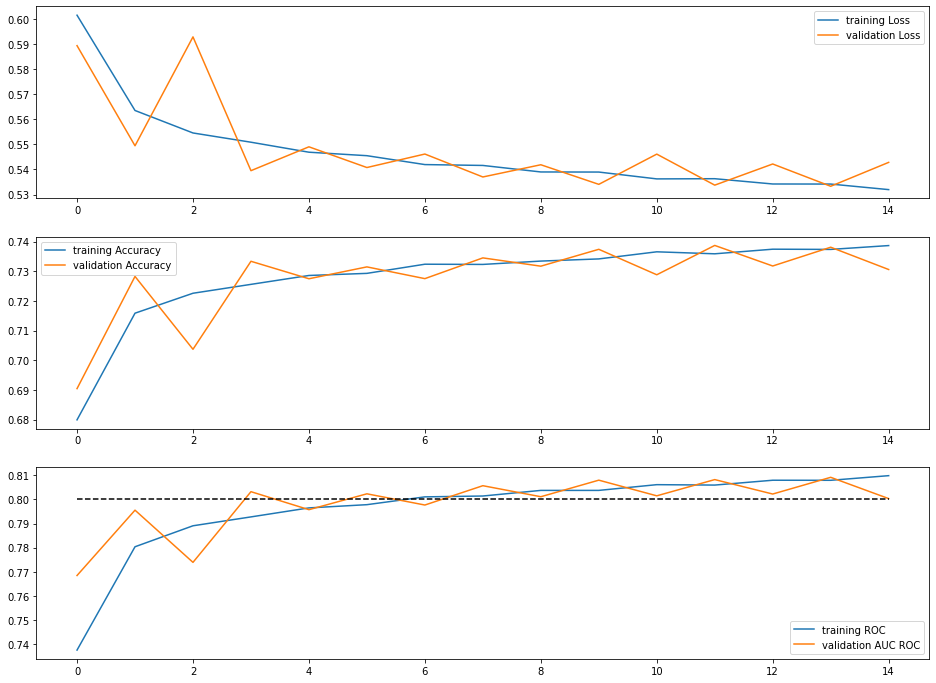

100%|██████████| 779/779 [00:04<00:00, 165.32it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

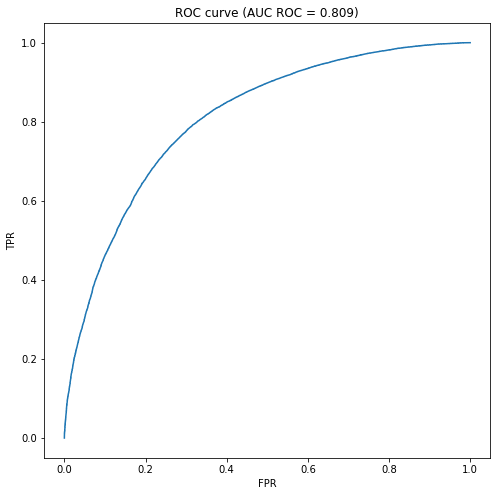

{'trainingLoss': [0.6014746814016677,
  0.5635068586020532,
  0.5545496919951978,
  0.5508652347456605,
  0.5468823422815373,
  0.5454952113610301,
  0.541951249961819,
  0.5416077507175222,
  0.5390113349324728,
  0.5389734589909932,
  0.5362478761724041,
  0.536324041220611,
  0.5342184932856409,
  0.5341897905473995,
  0.531975191608703],
 'trainingAccuracy': [0.6799442213297635,
  0.715872378402499,
  0.7225881302989737,
  0.7255800981704597,
  0.728574297188755,
  0.7292838018741633,
  0.7323672467648371,
  0.7322980812137438,
  0.7334225792057117,
  0.7341521642124051,
  0.7365461847389558,
  0.7358746095493084,
  0.7374274877286926,
  0.7373538598839804,
  0.7386479250334672],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'trainingAUC': [0.7375821830034204,
  0.7803736422013107,
  0.789062223966519,
  0.7927390369549994,
  0.7964668440134678,
  0.79780456411396,
  0.8010375486177941,
  0.8013911032199599,
  0.8037167078348597,
  0.803716540832376,
  0.806090337

In [ ]:
doExperiment(MobileViT2(image_size = (32, 32),
                        dims = [32, 48, 64],
                        channels = [16, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(2, 2, 2)), 
             learning_rate=0.8e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="MobileViT_AUC={}.pth")

### Experiment 2 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             576
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]           4,096
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              SiLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]           1,152
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              SiLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           8,192
      BatchNorm2d-11           [-1, 64, 16, 16]             128
         MV2Block-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

loss = 0.6009355325911726, accuracy : 0.6805558204650879, AUC ROC 0.737737587113361: 100%|██████████| 7004/7004 [03:59<00:00, 29.24it/s]


TRAINING ; Loss: 0.6009 Acc: 0.6806 AUC ROC : 0.7378 Time taken : 239.7


100%|██████████| 779/779 [00:04<00:00, 178.32it/s]


VALIDATION : Loss: 0.6124 Acc: 0.6614 AUC ROC : 0.7629 Time taken : 4.39
Epoch 1/14
----------


loss = 0.56449949243239, accuracy : 0.7152142524719238, AUC ROC 0.7793844111453709: 100%|██████████| 7004/7004 [04:00<00:00, 29.10it/s]


TRAINING ; Loss: 0.5645 Acc: 0.7152 AUC ROC : 0.7794 Time taken : 241.3


100%|██████████| 779/779 [00:04<00:00, 182.75it/s]


VALIDATION : Loss: 0.5526 Acc: 0.7244 AUC ROC : 0.7938 Time taken : 4.28
Epoch 2/14
----------


loss = 0.5558293692980494, accuracy : 0.7222522497177124, AUC ROC 0.7879614015024706: 100%|██████████| 7004/7004 [04:00<00:00, 29.13it/s]


TRAINING ; Loss: 0.5558 Acc: 0.7223 AUC ROC : 0.7880 Time taken : 240.99


100%|██████████| 779/779 [00:04<00:00, 186.81it/s]


VALIDATION : Loss: 0.5581 Acc: 0.7223 AUC ROC : 0.7872 Time taken : 4.19
Epoch 3/14
----------


loss = 0.55173530877488, accuracy : 0.7249040007591248, AUC ROC 0.7918623319176749: 100%|██████████| 7004/7004 [04:01<00:00, 29.00it/s]


TRAINING ; Loss: 0.5517 Acc: 0.7249 AUC ROC : 0.7919 Time taken : 242.07


100%|██████████| 779/779 [00:04<00:00, 177.25it/s]


VALIDATION : Loss: 0.5425 Acc: 0.7321 AUC ROC : 0.8006 Time taken : 4.42
Epoch 4/14
----------


loss = 0.5467081323521478, accuracy : 0.728424072265625, AUC ROC 0.7966160037405624: 100%|██████████| 7004/7004 [03:59<00:00, 29.26it/s]


TRAINING ; Loss: 0.5467 Acc: 0.7284 AUC ROC : 0.7966 Time taken : 239.96


100%|██████████| 779/779 [00:04<00:00, 187.87it/s]


VALIDATION : Loss: 0.5513 Acc: 0.7260 AUC ROC : 0.7932 Time taken : 4.17
Epoch 5/14
----------


loss = 0.5449565227414881, accuracy : 0.7292477488517761, AUC ROC 0.7981132681116433: 100%|██████████| 7004/7004 [03:58<00:00, 29.36it/s]


TRAINING ; Loss: 0.5450 Acc: 0.7292 AUC ROC : 0.7981 Time taken : 239.12


100%|██████████| 779/779 [00:04<00:00, 188.10it/s]


VALIDATION : Loss: 0.5396 Acc: 0.7343 AUC ROC : 0.8029 Time taken : 4.16
Epoch 6/14
----------


loss = 0.5416011342661722, accuracy : 0.7321272492408752, AUC ROC 0.8012902736278877: 100%|██████████| 7004/7004 [03:57<00:00, 29.52it/s]


TRAINING ; Loss: 0.5416 Acc: 0.7321 AUC ROC : 0.8013 Time taken : 237.82


100%|██████████| 779/779 [00:04<00:00, 181.71it/s]


VALIDATION : Loss: 0.5471 Acc: 0.7279 AUC ROC : 0.7968 Time taken : 4.31
Epoch 7/14
----------


loss = 0.5408337690574783, accuracy : 0.7329508662223816, AUC ROC 0.8018375966770199: 100%|██████████| 7004/7004 [03:58<00:00, 29.34it/s]


TRAINING ; Loss: 0.5408 Acc: 0.7329 AUC ROC : 0.8018 Time taken : 239.28


100%|██████████| 779/779 [00:04<00:00, 178.25it/s]


VALIDATION : Loss: 0.5371 Acc: 0.7356 AUC ROC : 0.8051 Time taken : 4.4
Epoch 8/14
----------


loss = 0.5379101314800127, accuracy : 0.7348347902297974, AUC ROC 0.804555093270153: 100%|██████████| 7004/7004 [03:55<00:00, 29.78it/s]


TRAINING ; Loss: 0.5379 Acc: 0.7348 AUC ROC : 0.8046 Time taken : 235.74


100%|██████████| 779/779 [00:03<00:00, 195.59it/s]


VALIDATION : Loss: 0.5534 Acc: 0.7211 AUC ROC : 0.7912 Time taken : 4.01
Epoch 9/14
----------


loss = 0.5378416007331439, accuracy : 0.735145092010498, AUC ROC 0.8046143588739306: 100%|██████████| 7004/7004 [03:55<00:00, 29.76it/s]


TRAINING ; Loss: 0.5379 Acc: 0.7351 AUC ROC : 0.8046 Time taken : 235.88


100%|██████████| 779/779 [00:03<00:00, 197.34it/s]


VALIDATION : Loss: 0.5358 Acc: 0.7363 AUC ROC : 0.8060 Time taken : 3.97
Epoch 10/14
----------


loss = 0.5348917410799435, accuracy : 0.7370424270629883, AUC ROC 0.8070747788294537: 100%|██████████| 7004/7004 [03:58<00:00, 29.32it/s]


TRAINING ; Loss: 0.5349 Acc: 0.7371 AUC ROC : 0.8071 Time taken : 239.43


100%|██████████| 779/779 [00:04<00:00, 178.28it/s]


VALIDATION : Loss: 0.5473 Acc: 0.7291 AUC ROC : 0.7972 Time taken : 4.4
Epoch 11/14
----------


loss = 0.5349490551905972, accuracy : 0.7370156049728394, AUC ROC 0.8070707252752936: 100%|██████████| 7004/7004 [03:57<00:00, 29.50it/s]


TRAINING ; Loss: 0.5350 Acc: 0.7370 AUC ROC : 0.8070 Time taken : 238.04


100%|██████████| 779/779 [00:04<00:00, 179.53it/s]


VALIDATION : Loss: 0.5349 Acc: 0.7363 AUC ROC : 0.8078 Time taken : 4.37
Epoch 12/14
----------


loss = 0.5321666298423494, accuracy : 0.7386071085929871, AUC ROC 0.8095344093206506: 100%|██████████| 7004/7004 [03:58<00:00, 29.38it/s]


TRAINING ; Loss: 0.5322 Acc: 0.7386 AUC ROC : 0.8095 Time taken : 238.97


100%|██████████| 779/779 [00:04<00:00, 187.62it/s]


VALIDATION : Loss: 0.5430 Acc: 0.7302 AUC ROC : 0.7999 Time taken : 4.17
Epoch 13/14
----------


loss = 0.5330569245943001, accuracy : 0.7385647296905518, AUC ROC 0.8087965373694976: 100%|██████████| 7004/7004 [04:01<00:00, 29.01it/s]


TRAINING ; Loss: 0.5331 Acc: 0.7385 AUC ROC : 0.8088 Time taken : 241.97


100%|██████████| 779/779 [00:04<00:00, 185.62it/s]


VALIDATION : Loss: 0.5334 Acc: 0.7383 AUC ROC : 0.8089 Time taken : 4.22
Epoch 14/14
----------


loss = 0.5298250509074756, accuracy : 0.7404106855392456, AUC ROC 0.8115718267352324: 100%|██████████| 7004/7004 [04:00<00:00, 29.17it/s]


TRAINING ; Loss: 0.5298 Acc: 0.7404 AUC ROC : 0.8116 Time taken : 240.68


100%|██████████| 779/779 [00:04<00:00, 181.15it/s]


VALIDATION : Loss: 0.5482 Acc: 0.7278 AUC ROC : 0.7987 Time taken : 4.33
Training complete in 60m 55s


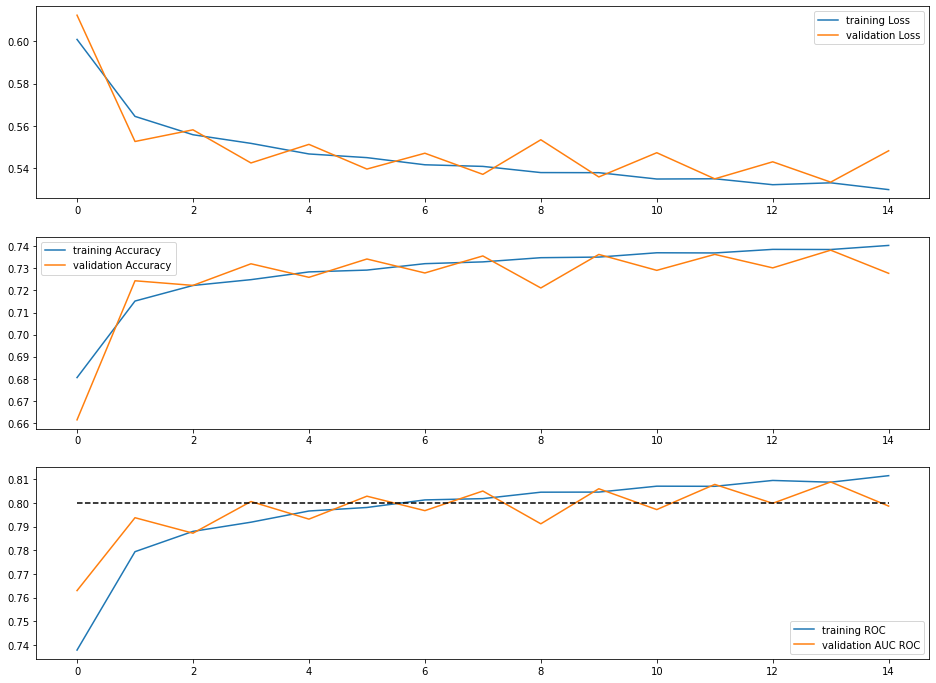

100%|██████████| 779/779 [00:04<00:00, 186.34it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

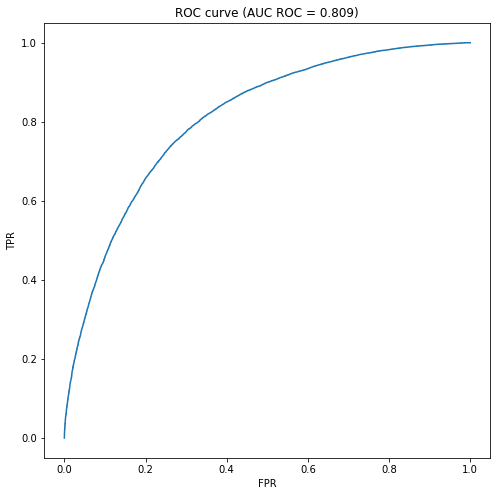

{'trainingLoss': [0.6009131727586735,
  0.5644912280146962,
  0.55580983042451,
  0.5517281039438839,
  0.5467152492939389,
  0.544977985035889,
  0.5415956202749161,
  0.5408323441733743,
  0.5379051873099852,
  0.5378544131308355,
  0.5348604743271095,
  0.5349765998803309,
  0.5321670342555593,
  0.5330605300012203,
  0.5298430986268241],
 'trainingAccuracy': [0.6805734047300313,
  0.7152253458277555,
  0.7222757697456493,
  0.7249085229808122,
  0.728413654618474,
  0.7292347166443552,
  0.7321441320838912,
  0.7329495760821062,
  0.7348482820169567,
  0.7351249442213298,
  0.7370749665327979,
  0.7369968763944668,
  0.7386122266845159,
  0.738549754573851,
  0.7403993752788933],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'trainingAUC': [0.7377646720054893,
  0.7793954796029772,
  0.787983233942264,
  0.7918662168830013,
  0.7966072083664122,
  0.7980945150725367,
  0.8012949627753914,
  0.8018389163476256,
  0.8045630740025898,
  0.8046046557393239,
  0.807103

In [ ]:
doExperiment(MobileViT2(image_size = (32, 32),
                        dims = [64, 64, 96],
                        channels = [32, 64, 64, 128, 128],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(1, 2, 1)), 
             learning_rate=0.6e-3,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="MobileViT_2_AUC={}.pth")

### Experiment 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,152
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              SiLU-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 256, 16, 16]          16,384
       BatchNorm2d-5          [-1, 256, 16, 16]             512
              SiLU-6          [-1, 256, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]           2,304
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              SiLU-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          32,768
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         MV2Block-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]          65,536
      BatchNorm2d-14          [-1, 512,

loss = 0.6053654903854643, accuracy : 0.6752343773841858, AUC ROC 0.7322110706285794: 100%|██████████| 7004/7004 [04:26<00:00, 26.26it/s]


TRAINING ; Loss: 0.6054 Acc: 0.6752 AUC ROC : 0.7322 Time taken : 266.93


100%|██████████| 779/779 [00:04<00:00, 156.09it/s]


VALIDATION : Loss: 0.5823 Acc: 0.6968 AUC ROC : 0.7630 Time taken : 5.02
Epoch 1/14
----------


loss = 0.5674380048555987, accuracy : 0.7116093635559082, AUC ROC 0.7761311966598478: 100%|██████████| 7004/7004 [04:22<00:00, 26.71it/s]


TRAINING ; Loss: 0.5674 Acc: 0.7116 AUC ROC : 0.7761 Time taken : 262.79


100%|██████████| 779/779 [00:05<00:00, 153.60it/s]


VALIDATION : Loss: 0.5539 Acc: 0.7236 AUC ROC : 0.7916 Time taken : 5.1
Epoch 2/14
----------


loss = 0.5580036938658782, accuracy : 0.7200535535812378, AUC ROC 0.7858444158379393: 100%|██████████| 7004/7004 [04:22<00:00, 26.72it/s]


TRAINING ; Loss: 0.5580 Acc: 0.7201 AUC ROC : 0.7858 Time taken : 262.67


100%|██████████| 779/779 [00:05<00:00, 149.93it/s]


VALIDATION : Loss: 0.5629 Acc: 0.7110 AUC ROC : 0.7858 Time taken : 5.22
Epoch 3/14
----------


loss = 0.552852265626192, accuracy : 0.7240267992019653, AUC ROC 0.7906959428344784: 100%|██████████| 7004/7004 [04:21<00:00, 26.82it/s]


TRAINING ; Loss: 0.5528 Acc: 0.7240 AUC ROC : 0.7907 Time taken : 261.74


100%|██████████| 779/779 [00:05<00:00, 153.38it/s]


VALIDATION : Loss: 0.5448 Acc: 0.7302 AUC ROC : 0.7984 Time taken : 5.1
Epoch 4/14
----------


loss = 0.5473384518282755, accuracy : 0.7280647158622742, AUC ROC 0.7959760685168088: 100%|██████████| 7004/7004 [04:19<00:00, 27.02it/s]


TRAINING ; Loss: 0.5473 Acc: 0.7281 AUC ROC : 0.7960 Time taken : 259.83


100%|██████████| 779/779 [00:05<00:00, 153.51it/s]


VALIDATION : Loss: 0.5778 Acc: 0.7123 AUC ROC : 0.7818 Time taken : 5.1
Epoch 5/14
----------


loss = 0.5454912657354559, accuracy : 0.7293794751167297, AUC ROC 0.7976267644045367: 100%|██████████| 7004/7004 [04:18<00:00, 27.12it/s]


TRAINING ; Loss: 0.5455 Acc: 0.7294 AUC ROC : 0.7976 Time taken : 258.91


100%|██████████| 779/779 [00:04<00:00, 156.36it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7359 AUC ROC : 0.8051 Time taken : 5.0
Epoch 6/14
----------


loss = 0.54091295966506, accuracy : 0.732888400554657, AUC ROC 0.8018982649165689: 100%|██████████| 7004/7004 [04:20<00:00, 26.91it/s]


TRAINING ; Loss: 0.5409 Acc: 0.7329 AUC ROC : 0.8019 Time taken : 260.88


100%|██████████| 779/779 [00:05<00:00, 151.53it/s]


VALIDATION : Loss: 0.5539 Acc: 0.7220 AUC ROC : 0.7903 Time taken : 5.16
Epoch 7/14
----------


loss = 0.5403912451480116, accuracy : 0.7332075834274292, AUC ROC 0.8023025812201511: 100%|██████████| 7004/7004 [04:21<00:00, 26.81it/s]


TRAINING ; Loss: 0.5404 Acc: 0.7332 AUC ROC : 0.8023 Time taken : 261.85


100%|██████████| 779/779 [00:05<00:00, 152.76it/s]


VALIDATION : Loss: 0.5358 Acc: 0.7360 AUC ROC : 0.8064 Time taken : 5.12
Epoch 8/14
----------


loss = 0.5357317201154572, accuracy : 0.7357879281044006, AUC ROC 0.8064377693579885: 100%|██████████| 7004/7004 [04:20<00:00, 26.85it/s]


TRAINING ; Loss: 0.5357 Acc: 0.7358 AUC ROC : 0.8064 Time taken : 261.46


100%|██████████| 779/779 [00:05<00:00, 152.80it/s]


VALIDATION : Loss: 0.5490 Acc: 0.7254 AUC ROC : 0.7963 Time taken : 5.13
Epoch 9/14
----------


loss = 0.5358778641649655, accuracy : 0.7360557913780212, AUC ROC 0.8063999015311225: 100%|██████████| 7004/7004 [04:21<00:00, 26.80it/s]


TRAINING ; Loss: 0.5358 Acc: 0.7361 AUC ROC : 0.8064 Time taken : 261.99


100%|██████████| 779/779 [00:05<00:00, 147.36it/s]


VALIDATION : Loss: 0.5358 Acc: 0.7383 AUC ROC : 0.8068 Time taken : 5.31
Epoch 10/14
----------


loss = 0.5315912585854531, accuracy : 0.7391673922538757, AUC ROC 0.8101134337563045: 100%|██████████| 7004/7004 [04:20<00:00, 26.88it/s]


TRAINING ; Loss: 0.5316 Acc: 0.7392 AUC ROC : 0.8101 Time taken : 261.18


100%|██████████| 779/779 [00:05<00:00, 153.11it/s]


VALIDATION : Loss: 0.5486 Acc: 0.7272 AUC ROC : 0.7955 Time taken : 5.11
Epoch 11/14
----------


loss = 0.5320920825430325, accuracy : 0.7389419674873352, AUC ROC 0.8096939269063915: 100%|██████████| 7004/7004 [04:19<00:00, 26.96it/s]


TRAINING ; Loss: 0.5321 Acc: 0.7389 AUC ROC : 0.8097 Time taken : 260.36


100%|██████████| 779/779 [00:05<00:00, 152.51it/s]


VALIDATION : Loss: 0.5350 Acc: 0.7369 AUC ROC : 0.8074 Time taken : 5.13
Epoch 12/14
----------


loss = 0.5273244360983371, accuracy : 0.7423191666603088, AUC ROC 0.8137567750393431: 100%|██████████| 7004/7004 [04:19<00:00, 26.99it/s]


TRAINING ; Loss: 0.5274 Acc: 0.7423 AUC ROC : 0.8137 Time taken : 260.12


100%|██████████| 779/779 [00:05<00:00, 151.89it/s]


VALIDATION : Loss: 0.5430 Acc: 0.7318 AUC ROC : 0.8006 Time taken : 5.16
Epoch 13/14
----------


loss = 0.5279504566448076, accuracy : 0.741303563117981, AUC ROC 0.8132906226538279: 100%|██████████| 7004/7004 [04:22<00:00, 26.67it/s]


TRAINING ; Loss: 0.5279 Acc: 0.7413 AUC ROC : 0.8133 Time taken : 263.23


100%|██████████| 779/779 [00:05<00:00, 152.44it/s]


VALIDATION : Loss: 0.5355 Acc: 0.7365 AUC ROC : 0.8069 Time taken : 5.14
Epoch 14/14
----------


loss = 0.5229986126550606, accuracy : 0.7450557947158813, AUC ROC 0.8174841047100092: 100%|██████████| 7004/7004 [04:20<00:00, 26.94it/s]


TRAINING ; Loss: 0.5230 Acc: 0.7451 AUC ROC : 0.8175 Time taken : 260.61


100%|██████████| 779/779 [00:05<00:00, 154.14it/s]


VALIDATION : Loss: 0.5422 Acc: 0.7335 AUC ROC : 0.8009 Time taken : 5.08
Training complete in 66m 42s


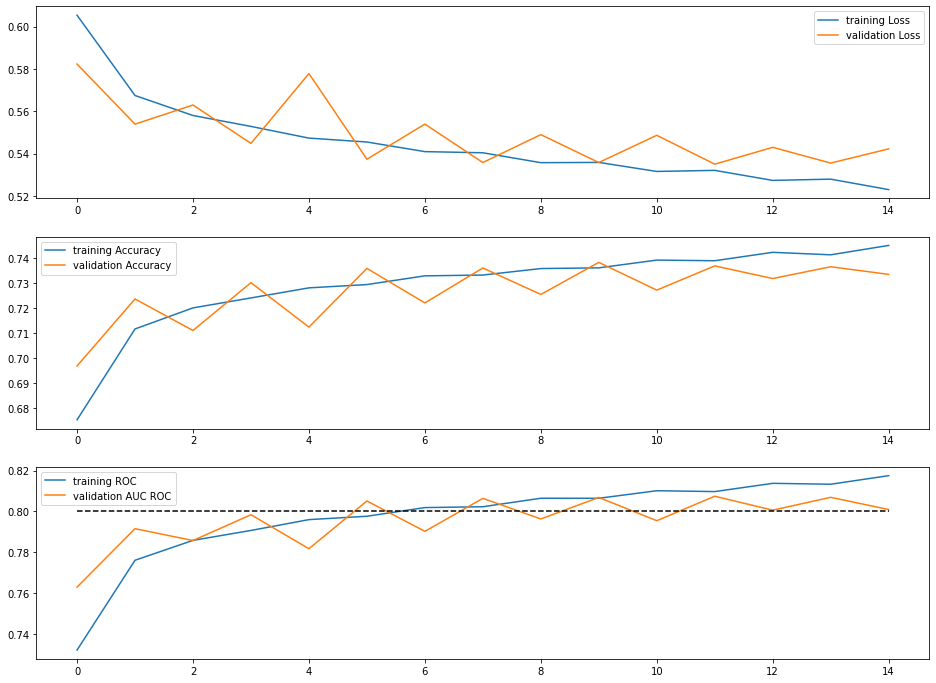

100%|██████████| 779/779 [00:05<00:00, 155.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

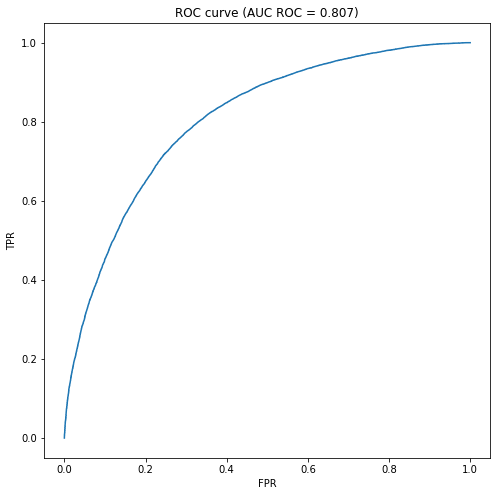

In [ ]:
mvit3 = doExperiment(MobileViT2(image_size = (32, 32),
                        dims = [64, 64, 96],
                        channels = [64, 128, 128, 192, 192],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(1, 2, 1),
                        expansion=4), 
             learning_rate=2.5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=15,
             nameOfModel="MobileViT_3_AUC={}.pth")

### Experiment 4

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           2,304
       BatchNorm2d-2          [-1, 128, 16, 16]             256
              SiLU-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 512, 16, 16]          65,536
       BatchNorm2d-5          [-1, 512, 16, 16]           1,024
              SiLU-6          [-1, 512, 16, 16]               0
            Conv2d-7          [-1, 512, 16, 16]           4,608
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
              SiLU-9          [-1, 512, 16, 16]               0
           Conv2d-10          [-1, 192, 16, 16]          98,304
      BatchNorm2d-11          [-1, 192, 16, 16]             384
         MV2Block-12          [-1, 192, 16, 16]               0
           Conv2d-13          [-1, 768, 16, 16]         147,456
      BatchNorm2d-14          [-1, 768,

loss = 0.6034655419332641, accuracy : 0.6778147220611572, AUC ROC 0.7347237898599456: 100%|██████████| 7004/7004 [05:51<00:00, 19.91it/s]


TRAINING ; Loss: 0.6035 Acc: 0.6778 AUC ROC : 0.7347 Time taken : 352.0


100%|██████████| 779/779 [00:07<00:00, 98.81it/s]


VALIDATION : Loss: 0.5816 Acc: 0.7003 AUC ROC : 0.7648 Time taken : 7.91
Epoch 1/24
----------


loss = 0.5665770580726011, accuracy : 0.7123459577560425, AUC ROC 0.7771166134905133: 100%|██████████| 7004/7004 [05:56<00:00, 19.65it/s]


TRAINING ; Loss: 0.5666 Acc: 0.7123 AUC ROC : 0.7771 Time taken : 357.14


100%|██████████| 779/779 [00:07<00:00, 98.77it/s]


VALIDATION : Loss: 0.5512 Acc: 0.7261 AUC ROC : 0.7931 Time taken : 7.91
Epoch 2/24
----------


loss = 0.5568551230643477, accuracy : 0.7207120656967163, AUC ROC 0.7868617375001612: 100%|██████████| 7004/7004 [05:57<00:00, 19.59it/s]


TRAINING ; Loss: 0.5569 Acc: 0.7207 AUC ROC : 0.7868 Time taken : 358.09


100%|██████████| 779/779 [00:08<00:00, 97.22it/s]


VALIDATION : Loss: 0.5725 Acc: 0.7063 AUC ROC : 0.7759 Time taken : 8.04
Epoch 3/24
----------


loss = 0.5529397745175021, accuracy : 0.7232655882835388, AUC ROC 0.7906704737034499: 100%|██████████| 7004/7004 [05:58<00:00, 19.56it/s]


TRAINING ; Loss: 0.5530 Acc: 0.7233 AUC ROC : 0.7907 Time taken : 358.66


100%|██████████| 779/779 [00:07<00:00, 98.58it/s]


VALIDATION : Loss: 0.5412 Acc: 0.7340 AUC ROC : 0.8017 Time taken : 7.92
Epoch 4/24
----------


loss = 0.5466685021391937, accuracy : 0.727810263633728, AUC ROC 0.7966036270253909: 100%|██████████| 7004/7004 [05:56<00:00, 19.62it/s]


TRAINING ; Loss: 0.5467 Acc: 0.7278 AUC ROC : 0.7966 Time taken : 357.53


100%|██████████| 779/779 [00:07<00:00, 98.69it/s]


VALIDATION : Loss: 0.5659 Acc: 0.7156 AUC ROC : 0.7823 Time taken : 7.92
Epoch 5/24
----------


loss = 0.5453340734200818, accuracy : 0.7293437719345093, AUC ROC 0.7978509318352521: 100%|██████████| 7004/7004 [05:58<00:00, 19.54it/s]


TRAINING ; Loss: 0.5453 Acc: 0.7294 AUC ROC : 0.7979 Time taken : 359.0


100%|██████████| 779/779 [00:07<00:00, 98.42it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7369 AUC ROC : 0.8047 Time taken : 7.94
Epoch 6/24
----------


loss = 0.540620297389371, accuracy : 0.7334084510803223, AUC ROC 0.8021575305599823: 100%|██████████| 7004/7004 [05:59<00:00, 19.51it/s]


TRAINING ; Loss: 0.5406 Acc: 0.7334 AUC ROC : 0.8022 Time taken : 359.6


100%|██████████| 779/779 [00:07<00:00, 98.78it/s]


VALIDATION : Loss: 0.5500 Acc: 0.7264 AUC ROC : 0.7979 Time taken : 7.91
Epoch 7/24
----------


loss = 0.5397742405108044, accuracy : 0.7330691814422607, AUC ROC 0.8029945542451171: 100%|██████████| 7004/7004 [05:57<00:00, 19.62it/s]


TRAINING ; Loss: 0.5398 Acc: 0.7330 AUC ROC : 0.8030 Time taken : 357.62


100%|██████████| 779/779 [00:07<00:00, 98.53it/s]


VALIDATION : Loss: 0.5368 Acc: 0.7368 AUC ROC : 0.8063 Time taken : 7.93
Epoch 8/24
----------


loss = 0.534668664932251, accuracy : 0.7367790341377258, AUC ROC 0.807464747078377: 100%|██████████| 7004/7004 [05:57<00:00, 19.57it/s]


TRAINING ; Loss: 0.5347 Acc: 0.7368 AUC ROC : 0.8074 Time taken : 358.54


100%|██████████| 779/779 [00:07<00:00, 98.49it/s]


VALIDATION : Loss: 0.5495 Acc: 0.7272 AUC ROC : 0.7945 Time taken : 7.94
Epoch 9/24
----------


loss = 0.535209368701492, accuracy : 0.7365111708641052, AUC ROC 0.806997084434615: 100%|██████████| 7004/7004 [05:59<00:00, 19.48it/s]


TRAINING ; Loss: 0.5352 Acc: 0.7365 AUC ROC : 0.8070 Time taken : 360.07


100%|██████████| 779/779 [00:07<00:00, 98.18it/s]


VALIDATION : Loss: 0.5356 Acc: 0.7358 AUC ROC : 0.8076 Time taken : 7.96
Epoch 10/24
----------


loss = 0.529987602766071, accuracy : 0.7404196262359619, AUC ROC 0.8115510376604776: 100%|██████████| 7004/7004 [05:58<00:00, 19.52it/s]


TRAINING ; Loss: 0.5300 Acc: 0.7404 AUC ROC : 0.8115 Time taken : 359.43


100%|██████████| 779/779 [00:07<00:00, 98.65it/s]


VALIDATION : Loss: 0.5416 Acc: 0.7332 AUC ROC : 0.8016 Time taken : 7.92
Epoch 11/24
----------


loss = 0.5308914117727961, accuracy : 0.7393794655799866, AUC ROC 0.8107182097630704: 100%|██████████| 7004/7004 [05:58<00:00, 19.53it/s]


TRAINING ; Loss: 0.5309 Acc: 0.7394 AUC ROC : 0.8107 Time taken : 359.24


100%|██████████| 779/779 [00:07<00:00, 98.43it/s]


VALIDATION : Loss: 0.5365 Acc: 0.7371 AUC ROC : 0.8066 Time taken : 7.94
Epoch 12/24
----------


loss = 0.5251642257996968, accuracy : 0.7429553270339966, AUC ROC 0.8156388747003809: 100%|██████████| 7004/7004 [05:57<00:00, 19.60it/s]


TRAINING ; Loss: 0.5251 Acc: 0.7430 AUC ROC : 0.8157 Time taken : 357.84


100%|██████████| 779/779 [00:07<00:00, 98.63it/s]


VALIDATION : Loss: 0.5421 Acc: 0.7340 AUC ROC : 0.8017 Time taken : 7.92
Epoch 13/24
----------


loss = 0.5261370604804584, accuracy : 0.7423146963119507, AUC ROC 0.8148836850217744: 100%|██████████| 7004/7004 [05:59<00:00, 19.51it/s]


TRAINING ; Loss: 0.5261 Acc: 0.7423 AUC ROC : 0.8149 Time taken : 359.6


100%|██████████| 779/779 [00:07<00:00, 97.83it/s]


VALIDATION : Loss: 0.5374 Acc: 0.7363 AUC ROC : 0.8057 Time taken : 7.99
Epoch 14/24
----------


loss = 0.519711966655084, accuracy : 0.7470245361328125, AUC ROC 0.8202391440218306: 100%|██████████| 7004/7004 [06:01<00:00, 19.36it/s]


TRAINING ; Loss: 0.5197 Acc: 0.7470 AUC ROC : 0.8202 Time taken : 362.4


100%|██████████| 779/779 [00:07<00:00, 98.44it/s]


VALIDATION : Loss: 0.5489 Acc: 0.7260 AUC ROC : 0.7968 Time taken : 7.94
Epoch 15/24
----------


loss = 0.5211936865832124, accuracy : 0.7460602521896362, AUC ROC 0.8190820584328138: 100%|██████████| 7004/7004 [06:07<00:00, 19.04it/s]


TRAINING ; Loss: 0.5212 Acc: 0.7461 AUC ROC : 0.8191 Time taken : 368.38


100%|██████████| 779/779 [00:07<00:00, 98.59it/s]


VALIDATION : Loss: 0.5388 Acc: 0.7363 AUC ROC : 0.8047 Time taken : 7.93
Epoch 16/24
----------


loss = 0.5133956368522985, accuracy : 0.7508236765861511, AUC ROC 0.8253518241654446: 100%|██████████| 7004/7004 [05:58<00:00, 19.52it/s]


TRAINING ; Loss: 0.5134 Acc: 0.7508 AUC ROC : 0.8253 Time taken : 359.35


100%|██████████| 779/779 [00:07<00:00, 98.32it/s]


VALIDATION : Loss: 0.5455 Acc: 0.7306 AUC ROC : 0.7984 Time taken : 7.95
Epoch 17/24
----------


loss = 0.5156000949442386, accuracy : 0.7501718401908875, AUC ROC 0.8235897867747681: 100%|██████████| 7004/7004 [05:57<00:00, 19.57it/s]


TRAINING ; Loss: 0.5156 Acc: 0.7502 AUC ROC : 0.8236 Time taken : 358.51


100%|██████████| 779/779 [00:07<00:00, 98.63it/s]


VALIDATION : Loss: 0.5415 Acc: 0.7358 AUC ROC : 0.8034 Time taken : 7.92
Epoch 18/24
----------


loss = 0.5065276593267918, accuracy : 0.7558325529098511, AUC ROC 0.8308396841484145: 100%|██████████| 7004/7004 [05:58<00:00, 19.56it/s]


TRAINING ; Loss: 0.5065 Acc: 0.7558 AUC ROC : 0.8308 Time taken : 358.67


100%|██████████| 779/779 [00:07<00:00, 97.95it/s]


VALIDATION : Loss: 0.5538 Acc: 0.7254 AUC ROC : 0.7933 Time taken : 7.98
Epoch 19/24
----------


loss = 0.5098257461828845, accuracy : 0.7535870671272278, AUC ROC 0.8282626957228412: 100%|██████████| 7004/7004 [05:58<00:00, 19.56it/s]


TRAINING ; Loss: 0.5098 Acc: 0.7536 AUC ROC : 0.8283 Time taken : 358.61


100%|██████████| 779/779 [00:07<00:00, 98.45it/s]


VALIDATION : Loss: 0.5470 Acc: 0.7338 AUC ROC : 0.8009 Time taken : 7.94
Epoch 20/24
----------


loss = 0.4989348456348692, accuracy : 0.7606629133224487, AUC ROC 0.8366712227966948: 100%|██████████| 7004/7004 [05:57<00:00, 19.58it/s]


TRAINING ; Loss: 0.4990 Acc: 0.7606 AUC ROC : 0.8367 Time taken : 358.34


100%|██████████| 779/779 [00:07<00:00, 98.09it/s]


VALIDATION : Loss: 0.5544 Acc: 0.7247 AUC ROC : 0.7924 Time taken : 7.97
Epoch 21/24
----------


loss = 0.5027434959326471, accuracy : 0.7582030892372131, AUC ROC 0.8338267570518836: 100%|██████████| 7004/7004 [05:56<00:00, 19.63it/s]


TRAINING ; Loss: 0.5027 Acc: 0.7582 AUC ROC : 0.8338 Time taken : 357.37


100%|██████████| 779/779 [00:07<00:00, 98.55it/s]


VALIDATION : Loss: 0.5556 Acc: 0.7272 AUC ROC : 0.7956 Time taken : 7.93
Epoch 22/24
----------


loss = 0.49019357536094527, accuracy : 0.7663995623588562, AUC ROC 0.8431987246995982: 100%|██████████| 7004/7004 [05:57<00:00, 19.57it/s]


TRAINING ; Loss: 0.4902 Acc: 0.7664 AUC ROC : 0.8432 Time taken : 358.42


100%|██████████| 779/779 [00:07<00:00, 98.72it/s]


VALIDATION : Loss: 0.5519 Acc: 0.7279 AUC ROC : 0.7962 Time taken : 7.92
Epoch 23/24
----------


loss = 0.4949566947945527, accuracy : 0.7634642720222473, AUC ROC 0.839683791503276: 100%|██████████| 7004/7004 [05:56<00:00, 19.62it/s]


TRAINING ; Loss: 0.4949 Acc: 0.7635 AUC ROC : 0.8397 Time taken : 357.54


100%|██████████| 779/779 [00:08<00:00, 96.90it/s]


VALIDATION : Loss: 0.5636 Acc: 0.7259 AUC ROC : 0.7944 Time taken : 8.06
Epoch 24/24
----------


loss = 0.48091954062666215, accuracy : 0.7717901468276978, AUC ROC 0.8497646248880927: 100%|██████████| 7004/7004 [05:57<00:00, 19.57it/s]


TRAINING ; Loss: 0.4809 Acc: 0.7718 AUC ROC : 0.8498 Time taken : 358.48


100%|██████████| 779/779 [00:07<00:00, 98.29it/s]


VALIDATION : Loss: 0.5613 Acc: 0.7251 AUC ROC : 0.7900 Time taken : 7.95
Training complete in 152m 49s


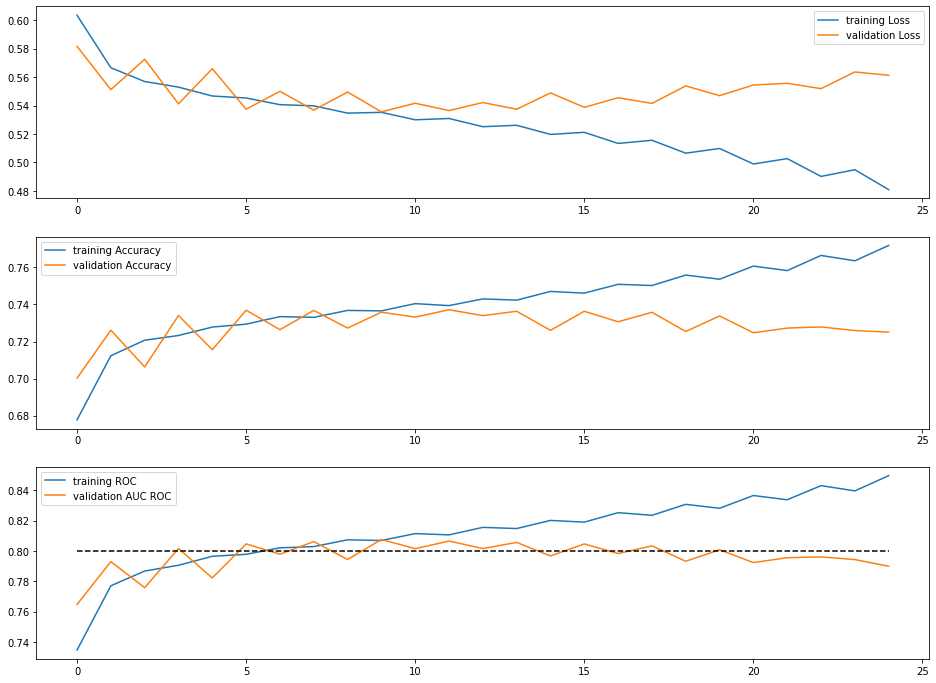

100%|██████████| 779/779 [00:07<00:00, 97.55it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array

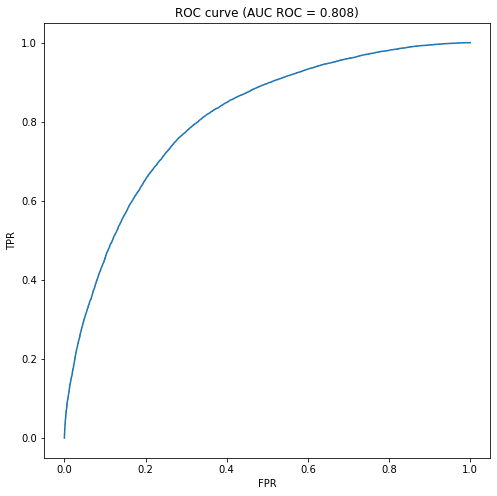

In [ ]:
mvit4 = doExperiment(MobileViT2(image_size = (32, 32),
                        dims = [64, 64, 96],
                        channels = [128, 192, 192, 256, 256],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(1, 2, 1),
                        expansion=4), 
             learning_rate=2.5e-4,
             input_size=(2,32,32),
             clean_every=500,
             epochs=25,
             nameOfModel="MobileViT_4_AUC={}.pth")

## Simple ViT

### Architecture

In [ ]:
import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :] 
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

### Experiments

#### Experiment 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 8, 8, 32]               0
         LayerNorm-2             [-1, 8, 8, 32]              64
            Linear-3            [-1, 8, 8, 256]           8,448
         LayerNorm-4            [-1, 8, 8, 256]             512
         LayerNorm-5              [-1, 64, 256]             512
            Linear-6              [-1, 64, 768]         196,608
           Softmax-7            [-1, 4, 64, 64]               0
            Linear-8              [-1, 64, 256]          65,536
         Attention-9              [-1, 64, 256]               0
        LayerNorm-10              [-1, 64, 256]             512
           Linear-11              [-1, 64, 128]          32,896
             GELU-12              [-1, 64, 128]               0
           Linear-13              [-1, 64, 256]          33,024
      FeedForward-14              [-1, 

loss = 0.6574861404725484, accuracy : 0.6151294708251953, AUC ROC 0.6525948502147113: 100%|██████████| 7004/7004 [03:15<00:00, 35.91it/s]


TRAINING ; Loss: 0.6575 Acc: 0.6151 AUC ROC : 0.6526 Time taken : 195.25


100%|██████████| 779/779 [00:03<00:00, 246.08it/s]


VALIDATION : Loss: 0.6416 Acc: 0.6396 AUC ROC : 0.6845 Time taken : 3.19
Epoch 1/14
----------


loss = 0.6275989713966846, accuracy : 0.6568370461463928, AUC ROC 0.7036540837717544: 100%|██████████| 7004/7004 [03:08<00:00, 37.20it/s]


TRAINING ; Loss: 0.6276 Acc: 0.6568 AUC ROC : 0.7037 Time taken : 188.69


100%|██████████| 779/779 [00:03<00:00, 242.66it/s]


VALIDATION : Loss: 0.6199 Acc: 0.6673 AUC ROC : 0.7152 Time taken : 3.23
Epoch 2/14
----------


loss = 0.6196962572974818, accuracy : 0.666243314743042, AUC ROC 0.7148519863355249: 100%|██████████| 7004/7004 [03:04<00:00, 37.99it/s]


TRAINING ; Loss: 0.6197 Acc: 0.6662 AUC ROC : 0.7149 Time taken : 184.76


100%|██████████| 779/779 [00:03<00:00, 256.91it/s]


VALIDATION : Loss: 0.6248 Acc: 0.6634 AUC ROC : 0.7105 Time taken : 3.05
Epoch 3/14
----------


loss = 0.6143084309356553, accuracy : 0.6721473336219788, AUC ROC 0.7221701180942988: 100%|██████████| 7004/7004 [03:05<00:00, 37.85it/s]


TRAINING ; Loss: 0.6143 Acc: 0.6722 AUC ROC : 0.7222 Time taken : 185.46


100%|██████████| 779/779 [00:03<00:00, 249.31it/s]


VALIDATION : Loss: 0.6083 Acc: 0.6794 AUC ROC : 0.7314 Time taken : 3.15
Epoch 4/14
----------


loss = 0.6091918244447027, accuracy : 0.6781071424484253, AUC ROC 0.7290483285335618: 100%|██████████| 7004/7004 [03:03<00:00, 38.12it/s]


TRAINING ; Loss: 0.6092 Acc: 0.6781 AUC ROC : 0.7290 Time taken : 184.11


100%|██████████| 779/779 [00:03<00:00, 247.99it/s]


VALIDATION : Loss: 0.6128 Acc: 0.6749 AUC ROC : 0.7253 Time taken : 3.17
Epoch 5/14
----------


loss = 0.6062237282650811, accuracy : 0.6807098388671875, AUC ROC 0.732981298872628: 100%|██████████| 7004/7004 [03:05<00:00, 37.83it/s]


TRAINING ; Loss: 0.6062 Acc: 0.6807 AUC ROC : 0.7330 Time taken : 185.55


100%|██████████| 779/779 [00:03<00:00, 245.34it/s]


VALIDATION : Loss: 0.6001 Acc: 0.6880 AUC ROC : 0.7413 Time taken : 3.2
Epoch 6/14
----------


loss = 0.6025986563691071, accuracy : 0.6845781207084656, AUC ROC 0.7372974532472831: 100%|██████████| 7004/7004 [03:03<00:00, 38.26it/s]


TRAINING ; Loss: 0.6026 Acc: 0.6846 AUC ROC : 0.7373 Time taken : 183.46


100%|██████████| 779/779 [00:03<00:00, 250.71it/s]


VALIDATION : Loss: 0.6149 Acc: 0.6721 AUC ROC : 0.7248 Time taken : 3.13
Epoch 7/14
----------


loss = 0.6016795669496059, accuracy : 0.6858415007591248, AUC ROC 0.7384389540833027: 100%|██████████| 7004/7004 [03:03<00:00, 38.23it/s]


TRAINING ; Loss: 0.6017 Acc: 0.6858 AUC ROC : 0.7384 Time taken : 183.6


100%|██████████| 779/779 [00:03<00:00, 254.99it/s]


VALIDATION : Loss: 0.5979 Acc: 0.6902 AUC ROC : 0.7442 Time taken : 3.08
Epoch 8/14
----------


loss = 0.599287539001022, accuracy : 0.6884084939956665, AUC ROC 0.7414013763260331: 100%|██████████| 7004/7004 [03:05<00:00, 37.75it/s]


TRAINING ; Loss: 0.5993 Acc: 0.6884 AUC ROC : 0.7414 Time taken : 185.91


100%|██████████| 779/779 [00:03<00:00, 250.04it/s]


VALIDATION : Loss: 0.6147 Acc: 0.6681 AUC ROC : 0.7343 Time taken : 3.14
Epoch 9/14
----------


loss = 0.5989973368857588, accuracy : 0.6880468726158142, AUC ROC 0.7418112099219802: 100%|██████████| 7004/7004 [03:04<00:00, 37.95it/s]


TRAINING ; Loss: 0.5990 Acc: 0.6880 AUC ROC : 0.7418 Time taken : 184.93


100%|██████████| 779/779 [00:03<00:00, 258.13it/s]


VALIDATION : Loss: 0.5978 Acc: 0.6888 AUC ROC : 0.7441 Time taken : 3.04
Epoch 10/14
----------


loss = 0.5974375562497548, accuracy : 0.689453125, AUC ROC 0.7437611539162183: 100%|██████████| 7004/7004 [03:04<00:00, 38.02it/s]


TRAINING ; Loss: 0.5975 Acc: 0.6894 AUC ROC : 0.7437 Time taken : 184.63


100%|██████████| 779/779 [00:03<00:00, 258.69it/s]


VALIDATION : Loss: 0.6198 Acc: 0.6744 AUC ROC : 0.7261 Time taken : 3.03
Epoch 11/14
----------


loss = 0.5964714530791555, accuracy : 0.6906182765960693, AUC ROC 0.744888279236678: 100%|██████████| 7004/7004 [03:04<00:00, 38.06it/s]


TRAINING ; Loss: 0.5965 Acc: 0.6906 AUC ROC : 0.7449 Time taken : 184.4


100%|██████████| 779/779 [00:03<00:00, 241.84it/s]


VALIDATION : Loss: 0.5933 Acc: 0.6931 AUC ROC : 0.7493 Time taken : 3.24
Epoch 12/14
----------


loss = 0.5943522304722241, accuracy : 0.6924977898597717, AUC ROC 0.7475729320873052: 100%|██████████| 7004/7004 [03:03<00:00, 38.26it/s]


TRAINING ; Loss: 0.5943 Acc: 0.6925 AUC ROC : 0.7476 Time taken : 183.5


100%|██████████| 779/779 [00:03<00:00, 252.89it/s]


VALIDATION : Loss: 0.6077 Acc: 0.6801 AUC ROC : 0.7340 Time taken : 3.1
Epoch 13/14
----------


loss = 0.594218623808452, accuracy : 0.692642867565155, AUC ROC 0.7477854862083695: 100%|██████████| 7004/7004 [03:02<00:00, 38.40it/s]


TRAINING ; Loss: 0.5942 Acc: 0.6926 AUC ROC : 0.7478 Time taken : 182.8


100%|██████████| 779/779 [00:03<00:00, 235.28it/s]


VALIDATION : Loss: 0.5945 Acc: 0.6908 AUC ROC : 0.7486 Time taken : 3.34
Epoch 14/14
----------


loss = 0.592310273958104, accuracy : 0.694368302822113, AUC ROC 0.750029880734814: 100%|██████████| 7004/7004 [03:02<00:00, 38.44it/s]


TRAINING ; Loss: 0.5923 Acc: 0.6944 AUC ROC : 0.7500 Time taken : 182.61


100%|██████████| 779/779 [00:02<00:00, 263.33it/s]


VALIDATION : Loss: 0.6028 Acc: 0.6857 AUC ROC : 0.7383 Time taken : 2.98
Training complete in 47m 7s


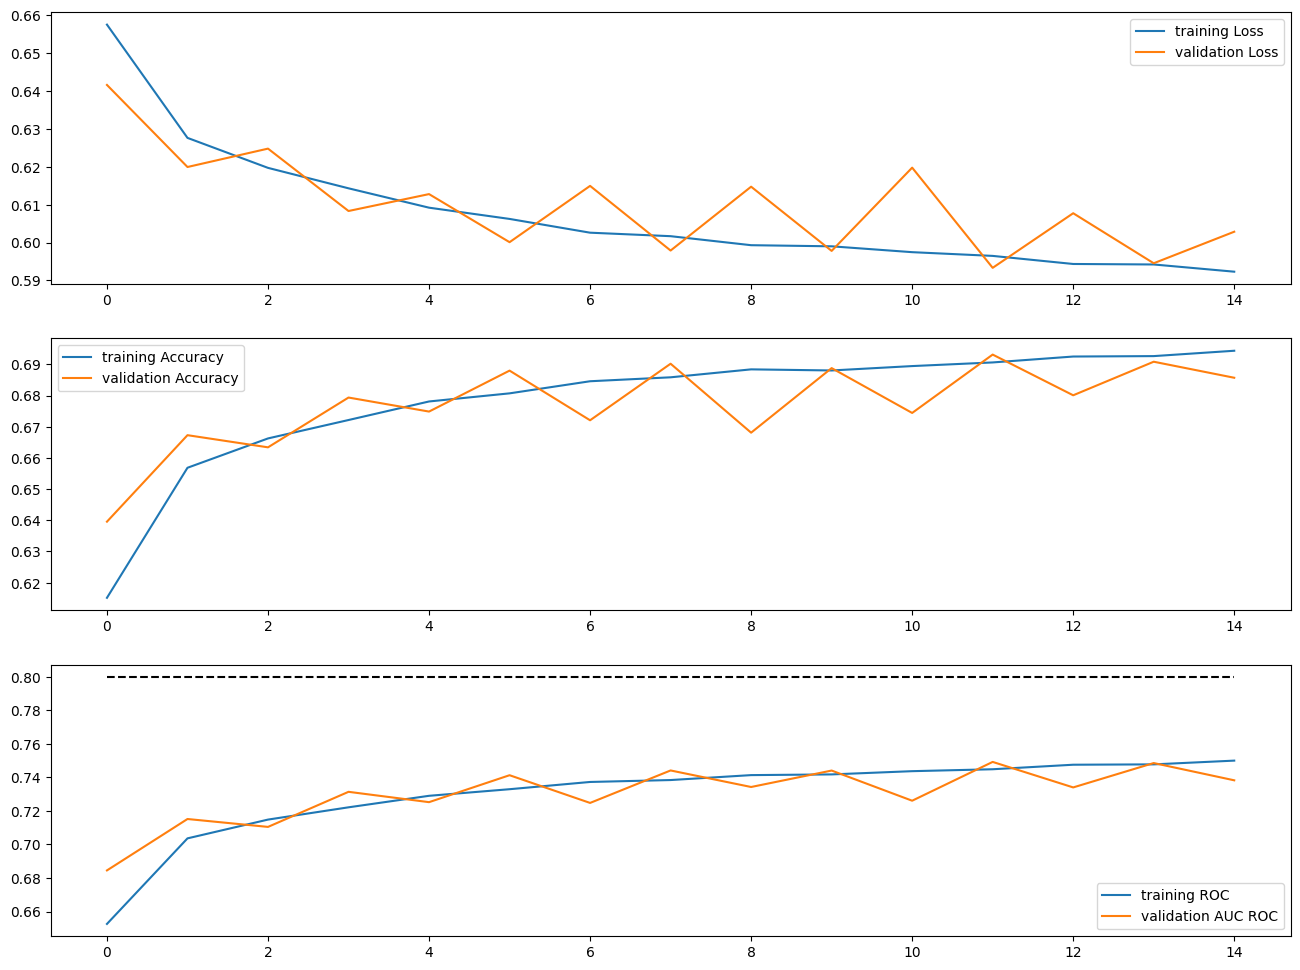

100%|██████████| 779/779 [00:02<00:00, 269.96it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

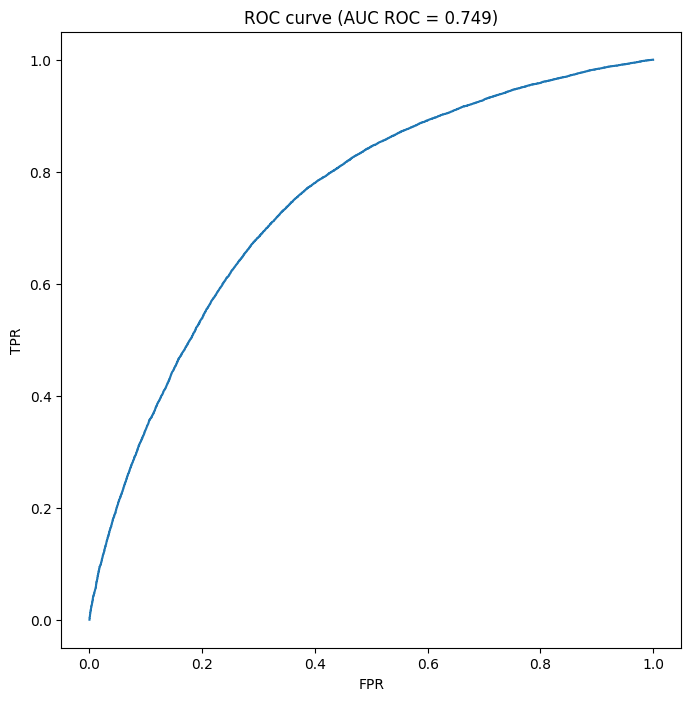

In [ ]:
simpleVit = doExperiment(SimpleViT(image_size = 32,
                                   patch_size = 4,
                                   num_classes = 1,
                                   dim = 256,
                                   depth = 1,
                                   heads = 4,
                                   mlp_dim = 128,
                                   channels = 2), 
                         learning_rate=2.5e-4,
                         input_size=(2,32,32),
                         clean_every=500,
                         epochs=15,
                         nameOfModel="SimpleViT_1_AUC={}.pth")

#### Experiment 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 8, 8, 32]               0
         LayerNorm-2             [-1, 8, 8, 32]              64
            Linear-3            [-1, 8, 8, 256]           8,448
         LayerNorm-4            [-1, 8, 8, 256]             512
         LayerNorm-5              [-1, 64, 256]             512
            Linear-6              [-1, 64, 768]         196,608
           Softmax-7            [-1, 4, 64, 64]               0
            Linear-8              [-1, 64, 256]          65,536
         Attention-9              [-1, 64, 256]               0
        LayerNorm-10              [-1, 64, 256]             512
           Linear-11              [-1, 64, 128]          32,896
             GELU-12              [-1, 64, 128]               0
           Linear-13              [-1, 64, 256]          33,024
      FeedForward-14              [-1, 

loss = 0.6609807381119047, accuracy : 0.6096383929252625, AUC ROC 0.6455361055532386: 100%|██████████| 7004/7004 [03:27<00:00, 33.74it/s]


TRAINING ; Loss: 0.6610 Acc: 0.6096 AUC ROC : 0.6455 Time taken : 207.73


100%|██████████| 779/779 [00:03<00:00, 198.15it/s]


VALIDATION : Loss: 0.6522 Acc: 0.6247 AUC ROC : 0.6662 Time taken : 3.95
Epoch 1/14
----------


loss = 0.6439510002732277, accuracy : 0.637571394443512, AUC ROC 0.6775194357596763: 100%|██████████| 7004/7004 [03:28<00:00, 33.67it/s]


TRAINING ; Loss: 0.6439 Acc: 0.6376 AUC ROC : 0.6775 Time taken : 208.56


100%|██████████| 779/779 [00:04<00:00, 193.85it/s]


VALIDATION : Loss: 0.6328 Acc: 0.6501 AUC ROC : 0.6967 Time taken : 4.05
Epoch 2/14
----------


loss = 0.6377107481275286, accuracy : 0.6453147530555725, AUC ROC 0.688114249346064: 100%|██████████| 7004/7004 [03:24<00:00, 34.18it/s]


TRAINING ; Loss: 0.6377 Acc: 0.6453 AUC ROC : 0.6881 Time taken : 205.44


100%|██████████| 779/779 [00:03<00:00, 203.17it/s]


VALIDATION : Loss: 0.6387 Acc: 0.6497 AUC ROC : 0.6925 Time taken : 3.85
Epoch 3/14
----------


loss = 0.6370327731796673, accuracy : 0.6437209844589233, AUC ROC 0.6894014674153065: 100%|██████████| 7004/7004 [03:25<00:00, 34.10it/s]


TRAINING ; Loss: 0.6370 Acc: 0.6438 AUC ROC : 0.6894 Time taken : 205.94


100%|██████████| 779/779 [00:03<00:00, 206.46it/s]


VALIDATION : Loss: 0.6275 Acc: 0.6563 AUC ROC : 0.7038 Time taken : 3.79
Epoch 4/14
----------


loss = 0.6337990461204733, accuracy : 0.6487611532211304, AUC ROC 0.6945149212561574: 100%|██████████| 7004/7004 [03:27<00:00, 33.70it/s]


TRAINING ; Loss: 0.6338 Acc: 0.6487 AUC ROC : 0.6945 Time taken : 208.37


100%|██████████| 779/779 [00:03<00:00, 198.86it/s]


VALIDATION : Loss: 0.6346 Acc: 0.6506 AUC ROC : 0.6951 Time taken : 3.94
Epoch 5/14
----------


loss = 0.6360234051900251, accuracy : 0.6466339230537415, AUC ROC 0.6913268557633763: 100%|██████████| 7004/7004 [03:27<00:00, 33.76it/s]


TRAINING ; Loss: 0.6360 Acc: 0.6466 AUC ROC : 0.6913 Time taken : 207.98


100%|██████████| 779/779 [00:04<00:00, 193.55it/s]


VALIDATION : Loss: 0.6265 Acc: 0.6592 AUC ROC : 0.7060 Time taken : 4.05
Epoch 6/14
----------


loss = 0.6304505625580038, accuracy : 0.6530446410179138, AUC ROC 0.6998062959442608: 100%|██████████| 7004/7004 [03:28<00:00, 33.57it/s]


TRAINING ; Loss: 0.6305 Acc: 0.6530 AUC ROC : 0.6998 Time taken : 209.13


100%|██████████| 779/779 [00:03<00:00, 197.68it/s]


VALIDATION : Loss: 0.6396 Acc: 0.6471 AUC ROC : 0.6879 Time taken : 3.96
Epoch 7/14
----------


loss = 0.6294283602833748, accuracy : 0.6545111536979675, AUC ROC 0.7012708567989826: 100%|██████████| 7004/7004 [03:29<00:00, 33.51it/s]


TRAINING ; Loss: 0.6294 Acc: 0.6545 AUC ROC : 0.7013 Time taken : 209.52


100%|██████████| 779/779 [00:03<00:00, 200.64it/s]


VALIDATION : Loss: 0.6223 Acc: 0.6624 AUC ROC : 0.7121 Time taken : 3.9
Epoch 8/14
----------


loss = 0.6289724365047046, accuracy : 0.6542611718177795, AUC ROC 0.7019454039820223: 100%|██████████| 7004/7004 [03:21<00:00, 34.82it/s]


TRAINING ; Loss: 0.6290 Acc: 0.6542 AUC ROC : 0.7019 Time taken : 201.66


100%|██████████| 779/779 [00:03<00:00, 208.99it/s]


VALIDATION : Loss: 0.6334 Acc: 0.6472 AUC ROC : 0.6987 Time taken : 3.75
Epoch 9/14
----------


loss = 0.6320308240652084, accuracy : 0.6503124833106995, AUC ROC 0.6975074313666045: 100%|██████████| 7004/7004 [03:24<00:00, 34.18it/s]


TRAINING ; Loss: 0.6320 Acc: 0.6503 AUC ROC : 0.6975 Time taken : 205.43


100%|██████████| 779/779 [00:03<00:00, 200.41it/s]


VALIDATION : Loss: 0.6283 Acc: 0.6533 AUC ROC : 0.7092 Time taken : 3.91
Epoch 10/14
----------


loss = 0.6263203195929528, accuracy : 0.6578481793403625, AUC ROC 0.7059572862588452: 100%|██████████| 7004/7004 [03:23<00:00, 34.41it/s]


TRAINING ; Loss: 0.6263 Acc: 0.6578 AUC ROC : 0.7059 Time taken : 204.06


100%|██████████| 779/779 [00:03<00:00, 205.88it/s]


VALIDATION : Loss: 0.6258 Acc: 0.6573 AUC ROC : 0.7089 Time taken : 3.8
Epoch 11/14
----------


loss = 0.6286629142931529, accuracy : 0.6549932956695557, AUC ROC 0.7026064061960665: 100%|██████████| 7004/7004 [03:22<00:00, 34.60it/s]


TRAINING ; Loss: 0.6287 Acc: 0.6550 AUC ROC : 0.7026 Time taken : 202.94


100%|██████████| 779/779 [00:03<00:00, 209.01it/s]


VALIDATION : Loss: 0.6233 Acc: 0.6601 AUC ROC : 0.7108 Time taken : 3.75
Epoch 12/14
----------


loss = 0.6306544984238488, accuracy : 0.6522455215454102, AUC ROC 0.6995093254796834: 100%|██████████| 7004/7004 [03:23<00:00, 34.40it/s]


TRAINING ; Loss: 0.6307 Acc: 0.6522 AUC ROC : 0.6995 Time taken : 204.13


100%|██████████| 779/779 [00:03<00:00, 208.15it/s]


VALIDATION : Loss: 0.6355 Acc: 0.6445 AUC ROC : 0.6927 Time taken : 3.76
Epoch 13/14
----------


loss = 0.6251326330559595, accuracy : 0.6582901477813721, AUC ROC 0.7077577113426412: 100%|██████████| 7004/7004 [03:22<00:00, 34.51it/s]


TRAINING ; Loss: 0.6251 Acc: 0.6583 AUC ROC : 0.7078 Time taken : 203.5


100%|██████████| 779/779 [00:03<00:00, 198.84it/s]


VALIDATION : Loss: 0.6187 Acc: 0.6660 AUC ROC : 0.7173 Time taken : 3.94
Epoch 14/14
----------


loss = 0.6214695738255978, accuracy : 0.6621160507202148, AUC ROC 0.7128912776850495: 100%|██████████| 7004/7004 [03:26<00:00, 33.85it/s]


TRAINING ; Loss: 0.6215 Acc: 0.6621 AUC ROC : 0.7129 Time taken : 207.44


100%|██████████| 779/779 [00:03<00:00, 198.46it/s]


VALIDATION : Loss: 0.6192 Acc: 0.6670 AUC ROC : 0.7177 Time taken : 3.95
Training complete in 52m 30s


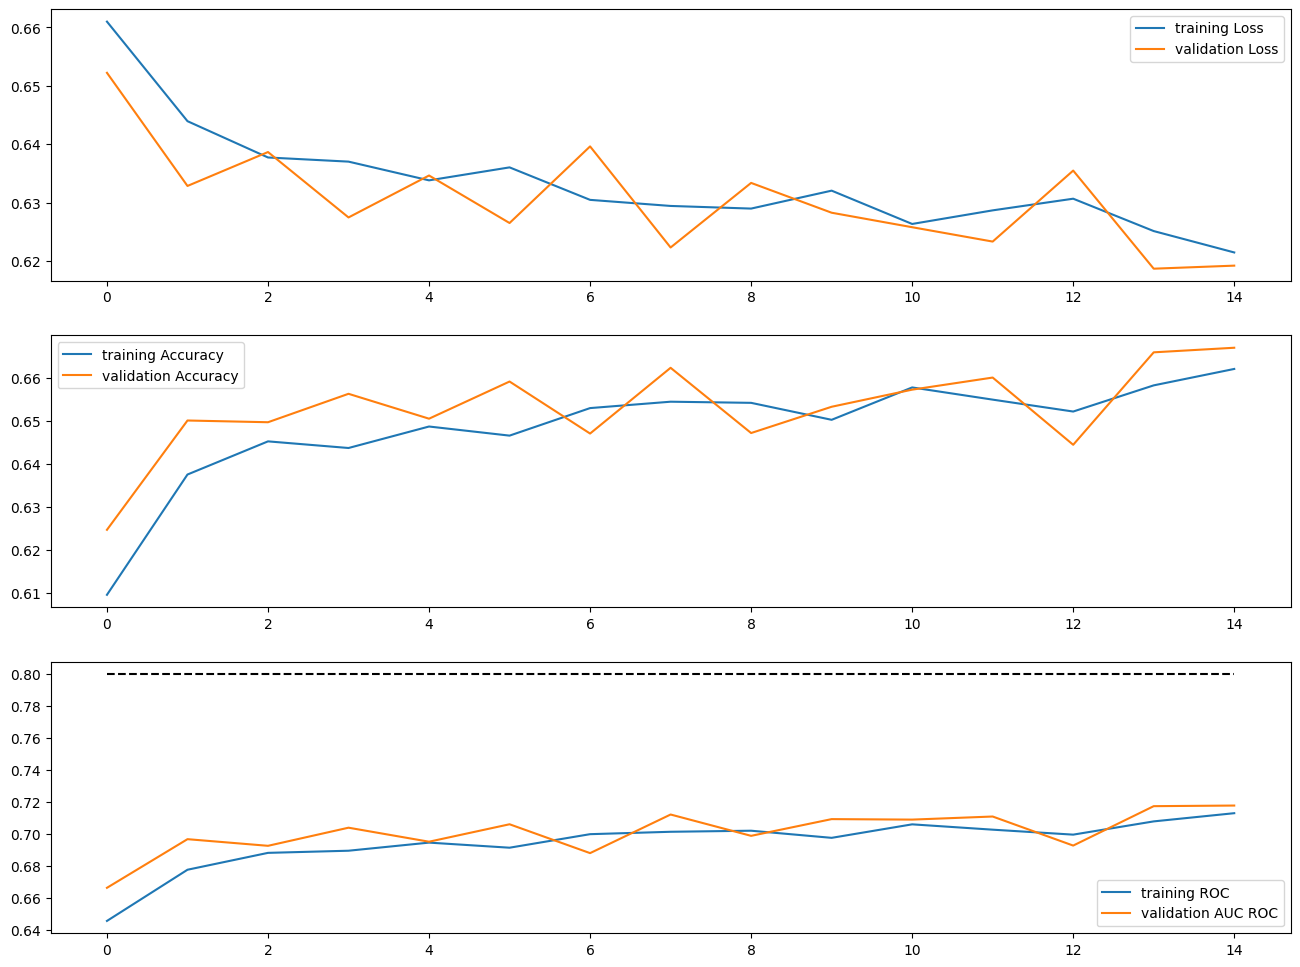

100%|██████████| 779/779 [00:03<00:00, 206.63it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

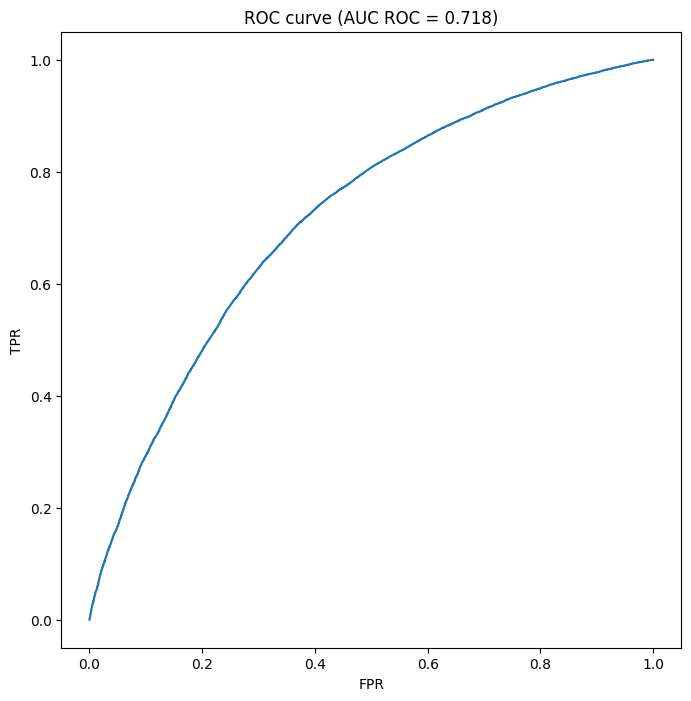

In [ ]:
simpleVit = doExperiment(SimpleViT(image_size = 32,
                                   patch_size = 4,
                                   num_classes = 1,
                                   dim = 256,
                                   depth = 2,
                                   heads = 4,
                                   mlp_dim = 128,
                                   channels = 2), 
                         learning_rate=2.5e-4,
                         input_size=(2,32,32),
                         clean_every=500,
                         epochs=15,
                         nameOfModel="SimpleViT_1_AUC={}.pth")

#### Experiment 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 8, 8, 32]               0
         LayerNorm-2             [-1, 8, 8, 32]              64
            Linear-3            [-1, 8, 8, 256]           8,448
         LayerNorm-4            [-1, 8, 8, 256]             512
         LayerNorm-5              [-1, 64, 256]             512
            Linear-6              [-1, 64, 768]         196,608
           Softmax-7            [-1, 4, 64, 64]               0
            Linear-8              [-1, 64, 256]          65,536
         Attention-9              [-1, 64, 256]               0
        LayerNorm-10              [-1, 64, 256]             512
           Linear-11              [-1, 64, 128]          32,896
             GELU-12              [-1, 64, 128]               0
           Linear-13              [-1, 64, 256]          33,024
      FeedForward-14              [-1, 

loss = 0.662901964187622, accuracy : 0.6062098145484924, AUC ROC 0.6410718115239716: 100%|██████████| 7004/7004 [04:18<00:00, 27.06it/s]


TRAINING ; Loss: 0.6629 Acc: 0.6062 AUC ROC : 0.6411 Time taken : 259.05


100%|██████████| 779/779 [00:05<00:00, 130.84it/s]


VALIDATION : Loss: 0.6528 Acc: 0.6295 AUC ROC : 0.6650 Time taken : 5.98
Epoch 1/14
----------


loss = 0.6630147526945387, accuracy : 0.6055111289024353, AUC ROC 0.6406908131925831: 100%|██████████| 7004/7004 [04:10<00:00, 27.97it/s]


TRAINING ; Loss: 0.6630 Acc: 0.6055 AUC ROC : 0.6407 Time taken : 251.24


100%|██████████| 779/779 [00:05<00:00, 132.49it/s]


VALIDATION : Loss: 0.6601 Acc: 0.6109 AUC ROC : 0.6472 Time taken : 5.9
Epoch 2/14
----------


loss = 0.6681212226748466, accuracy : 0.5958593487739563, AUC ROC 0.6281011781967978: 100%|██████████| 7004/7004 [04:07<00:00, 28.35it/s]


TRAINING ; Loss: 0.6681 Acc: 0.5959 AUC ROC : 0.6281 Time taken : 247.88


100%|██████████| 779/779 [00:05<00:00, 134.29it/s]


VALIDATION : Loss: 0.6718 Acc: 0.5893 AUC ROC : 0.6222 Time taken : 5.82
Epoch 3/14
----------


loss = 0.6724355035764831, accuracy : 0.5863192081451416, AUC ROC 0.6166074859006192: 100%|██████████| 7004/7004 [04:08<00:00, 28.16it/s]


TRAINING ; Loss: 0.6724 Acc: 0.5863 AUC ROC : 0.6166 Time taken : 249.54


100%|██████████| 779/779 [00:05<00:00, 134.45it/s]


VALIDATION : Loss: 0.6694 Acc: 0.5943 AUC ROC : 0.6256 Time taken : 5.82
Epoch 4/14
----------


loss = 0.6679894095148359, accuracy : 0.5961718559265137, AUC ROC 0.6284098517841749: 100%|██████████| 7004/7004 [04:08<00:00, 28.14it/s]


TRAINING ; Loss: 0.6680 Acc: 0.5961 AUC ROC : 0.6284 Time taken : 249.76


100%|██████████| 779/779 [00:05<00:00, 135.58it/s]


VALIDATION : Loss: 0.6672 Acc: 0.6010 AUC ROC : 0.6331 Time taken : 5.77
Epoch 5/14
----------


loss = 0.6755069530180522, accuracy : 0.5806049108505249, AUC ROC 0.607901287948579: 100%|██████████| 7004/7004 [04:07<00:00, 28.34it/s]


TRAINING ; Loss: 0.6755 Acc: 0.5806 AUC ROC : 0.6079 Time taken : 247.99


100%|██████████| 779/779 [00:05<00:00, 135.65it/s]


VALIDATION : Loss: 0.6738 Acc: 0.5830 AUC ROC : 0.6129 Time taken : 5.76
Epoch 6/14
----------


loss = 0.6736128222942352, accuracy : 0.5844799280166626, AUC ROC 0.6131433307262095: 100%|██████████| 7004/7004 [04:07<00:00, 28.25it/s]


TRAINING ; Loss: 0.6736 Acc: 0.5845 AUC ROC : 0.6131 Time taken : 248.84


100%|██████████| 779/779 [00:05<00:00, 131.63it/s]


VALIDATION : Loss: 0.6848 Acc: 0.5534 AUC ROC : 0.5785 Time taken : 5.95
Epoch 7/14
----------


loss = 0.6847356554610389, accuracy : 0.5553147196769714, AUC ROC 0.574893336252383: 100%|██████████| 7004/7004 [04:06<00:00, 28.42it/s]


TRAINING ; Loss: 0.6847 Acc: 0.5553 AUC ROC : 0.5749 Time taken : 247.24


100%|██████████| 779/779 [00:05<00:00, 131.43it/s]


VALIDATION : Loss: 0.6856 Acc: 0.5549 AUC ROC : 0.5718 Time taken : 5.95
Epoch 8/14
----------


loss = 0.6859443510770797, accuracy : 0.5514352321624756, AUC ROC 0.5692874060362951: 100%|██████████| 7004/7004 [04:06<00:00, 28.39it/s]


TRAINING ; Loss: 0.6859 Acc: 0.5514 AUC ROC : 0.5693 Time taken : 247.57


100%|██████████| 779/779 [00:05<00:00, 133.46it/s]


VALIDATION : Loss: 0.6878 Acc: 0.5441 AUC ROC : 0.5690 Time taken : 5.86
Epoch 9/14
----------


loss = 0.6840919806531497, accuracy : 0.5569888353347778, AUC ROC 0.5773738315562275: 100%|██████████| 7004/7004 [04:04<00:00, 28.59it/s]


TRAINING ; Loss: 0.6841 Acc: 0.5570 AUC ROC : 0.5774 Time taken : 245.83


100%|██████████| 779/779 [00:05<00:00, 134.44it/s]


VALIDATION : Loss: 0.6824 Acc: 0.5611 AUC ROC : 0.5844 Time taken : 5.82
Epoch 10/14
----------


loss = 0.6817731346828597, accuracy : 0.5647075772285461, AUC ROC 0.5866829479166991: 100%|██████████| 7004/7004 [04:07<00:00, 28.34it/s]


TRAINING ; Loss: 0.6818 Acc: 0.5647 AUC ROC : 0.5866 Time taken : 247.96


100%|██████████| 779/779 [00:05<00:00, 134.57it/s]


VALIDATION : Loss: 0.6839 Acc: 0.5586 AUC ROC : 0.5876 Time taken : 5.81
Epoch 11/14
----------


loss = 0.6815722276057515, accuracy : 0.5636740922927856, AUC ROC 0.5875026169441093: 100%|██████████| 7004/7004 [04:06<00:00, 28.39it/s]


TRAINING ; Loss: 0.6816 Acc: 0.5637 AUC ROC : 0.5875 Time taken : 247.51


100%|██████████| 779/779 [00:05<00:00, 134.92it/s]


VALIDATION : Loss: 0.6778 Acc: 0.5763 AUC ROC : 0.6023 Time taken : 5.8
Epoch 12/14
----------


loss = 0.6768822706256594, accuracy : 0.5770647525787354, AUC ROC 0.6039371232747814: 100%|██████████| 7004/7004 [04:06<00:00, 28.44it/s]


TRAINING ; Loss: 0.6769 Acc: 0.5771 AUC ROC : 0.6040 Time taken : 247.07


100%|██████████| 779/779 [00:05<00:00, 135.11it/s]


VALIDATION : Loss: 0.6692 Acc: 0.5950 AUC ROC : 0.6260 Time taken : 5.79
Epoch 13/14
----------


loss = 0.6696953347155026, accuracy : 0.5935446619987488, AUC ROC 0.623333773327753: 100%|██████████| 7004/7004 [04:05<00:00, 28.58it/s]


TRAINING ; Loss: 0.6697 Acc: 0.5935 AUC ROC : 0.6233 Time taken : 245.91


100%|██████████| 779/779 [00:05<00:00, 136.22it/s]


VALIDATION : Loss: 0.6672 Acc: 0.5987 AUC ROC : 0.6301 Time taken : 5.74
Epoch 14/14
----------


loss = 0.6688877878189087, accuracy : 0.5946584939956665, AUC ROC 0.6252943160509953: 100%|██████████| 7004/7004 [04:06<00:00, 28.43it/s]


TRAINING ; Loss: 0.6689 Acc: 0.5947 AUC ROC : 0.6253 Time taken : 247.18


100%|██████████| 779/779 [00:05<00:00, 134.97it/s]


VALIDATION : Loss: 0.6739 Acc: 0.5816 AUC ROC : 0.6192 Time taken : 5.79
Training complete in 63m 38s


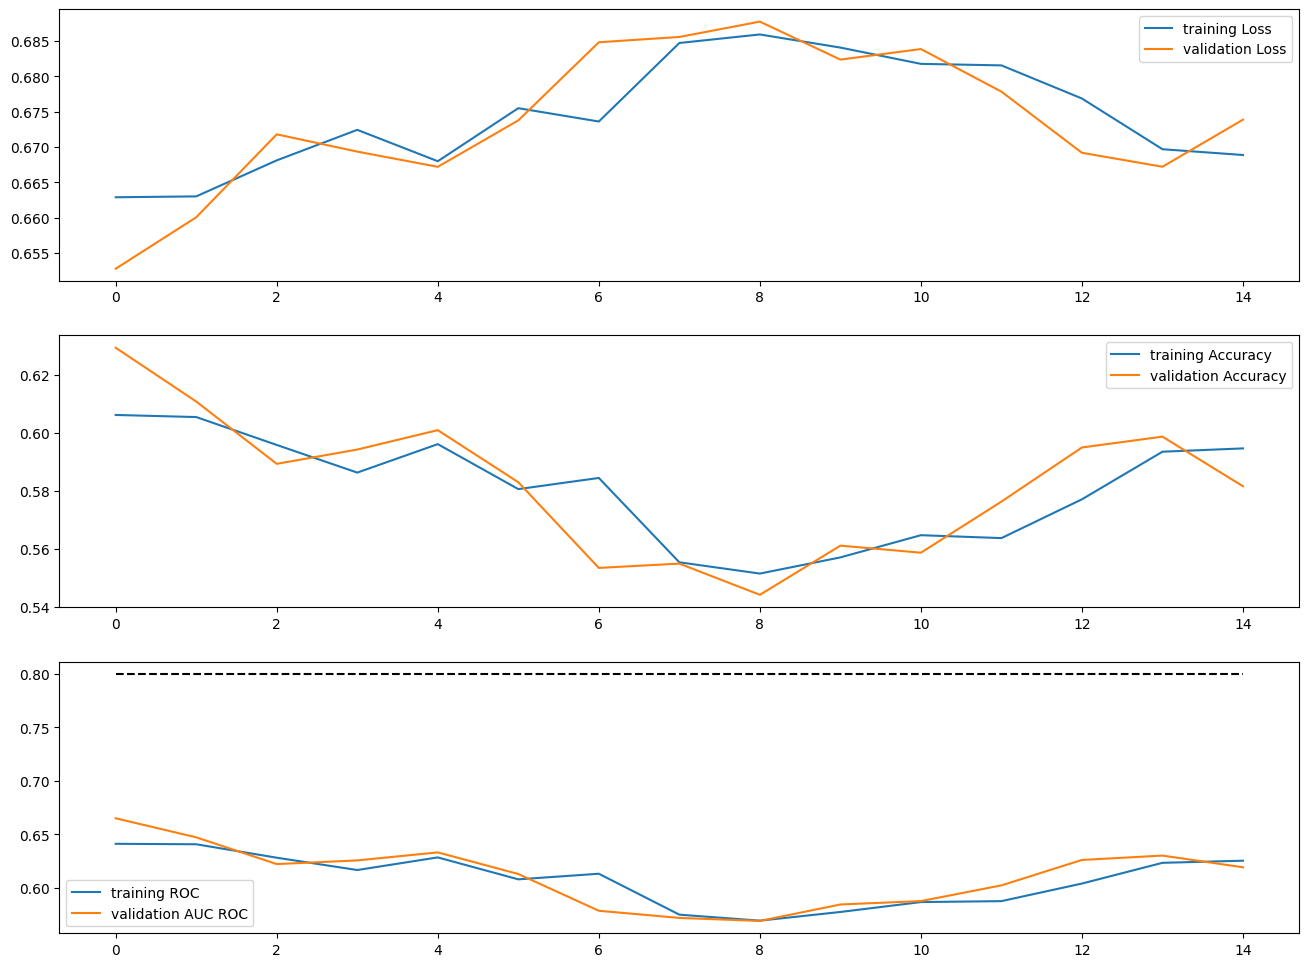

100%|██████████| 779/779 [00:05<00:00, 132.51it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

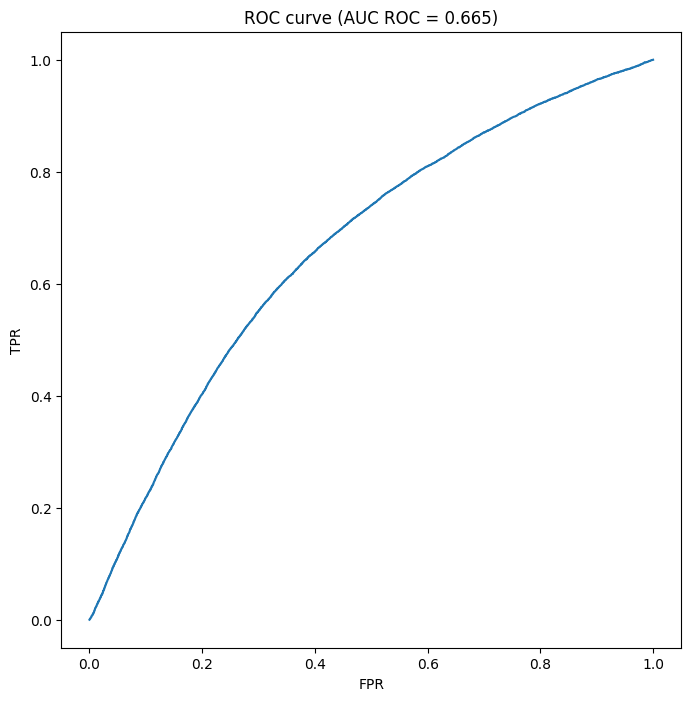

In [ ]:
simpleVit = doExperiment(SimpleViT(image_size = 32,
                                   patch_size = 4,
                                   num_classes = 1,
                                   dim = 256,
                                   depth = 4,
                                   heads = 4,
                                   mlp_dim = 128,
                                   channels = 2), 
                         learning_rate=2.5e-4,
                         input_size=(2,32,32),
                         clean_every=500,
                         epochs=15,
                         nameOfModel="SimpleViT_1_AUC={}.pth")

## ViT (patch merger, for small dataset)

### Architecture

In [ ]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

# helpers

def exists(val):
    return val is not None

def default(val ,d):
    return val if exists(val) else d

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# patch merger class

class PatchMerger(nn.Module):
    def __init__(self, dim, num_tokens_out):
        super().__init__()
        self.scale = dim ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.queries = nn.Parameter(torch.randn(num_tokens_out, dim))

    def forward(self, x):
        x = self.norm(x)
        sim = torch.matmul(self.queries, x.transpose(-1, -2)) * self.scale
        attn = sim.softmax(dim = -1)
        return torch.matmul(attn, x)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0., patch_merge_layer = None, patch_merge_num_tokens = 8):
        super().__init__()
        self.layers = nn.ModuleList([])

        self.patch_merge_layer_index = default(patch_merge_layer, depth // 2) - 1 # default to mid-way through transformer, as shown in paper
        self.patch_merger = PatchMerger(dim = dim, num_tokens_out = patch_merge_num_tokens)

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for index, (attn, ff) in enumerate(self.layers):
            x = attn(x) + x
            x = ff(x) + x

            if index == self.patch_merge_layer_index:
                x = self.patch_merger(x)

        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, patch_merge_layer = None, patch_merge_num_tokens = 8, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, patch_merge_layer, patch_merge_num_tokens)

        self.mlp_head = nn.Sequential(
            Reduce('b n d -> b d', 'mean'),
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        x += self.pos_embedding[:, :n]
        x = self.dropout(x)

        x = self.transformer(x)

        return self.mlp_head(x)


### Experiments

#### Experiment 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 4, 512]               0
         LayerNorm-2               [-1, 4, 512]           1,024
            Linear-3               [-1, 4, 128]          65,664
         LayerNorm-4               [-1, 4, 128]             256
           Dropout-5               [-1, 4, 128]               0
         LayerNorm-6               [-1, 4, 128]             256
            Linear-7              [-1, 4, 3072]         393,216
           Softmax-8             [-1, 16, 4, 4]               0
           Dropout-9             [-1, 16, 4, 4]               0
           Linear-10               [-1, 4, 128]         131,200
          Dropout-11               [-1, 4, 128]               0
        Attention-12               [-1, 4, 128]               0
          PreNorm-13               [-1, 4, 128]               0
        LayerNorm-14               [-1,

loss = 0.6347416451445648, accuracy : 0.649631679058075, AUC ROC 0.6923079233858358: 100%|██████████| 7004/7004 [03:35<00:00, 32.47it/s]


TRAINING ; Loss: 0.6347 Acc: 0.6496 AUC ROC : 0.6923 Time taken : 215.85


100%|██████████| 779/779 [00:03<00:00, 226.47it/s]


VALIDATION : Loss: 0.6173 Acc: 0.6712 AUC ROC : 0.7194 Time taken : 3.46
Epoch 1/24
----------


loss = 0.6098050388438361, accuracy : 0.6788080334663391, AUC ROC 0.7280325088132374: 100%|██████████| 7004/7004 [03:37<00:00, 32.23it/s]


TRAINING ; Loss: 0.6098 Acc: 0.6788 AUC ROC : 0.7281 Time taken : 217.97


100%|██████████| 779/779 [00:03<00:00, 214.57it/s]


VALIDATION : Loss: 0.5928 Acc: 0.6953 AUC ROC : 0.7485 Time taken : 3.65
Epoch 2/24
----------


loss = 0.600787242025137, accuracy : 0.6869218945503235, AUC ROC 0.7391866542964697: 100%|██████████| 7004/7004 [03:35<00:00, 32.44it/s]


TRAINING ; Loss: 0.6008 Acc: 0.6869 AUC ROC : 0.7392 Time taken : 216.51


100%|██████████| 779/779 [00:03<00:00, 222.61it/s]


VALIDATION : Loss: 0.6061 Acc: 0.6844 AUC ROC : 0.7391 Time taken : 3.52
Epoch 3/24
----------


loss = 0.5957329745846135, accuracy : 0.6905624866485596, AUC ROC 0.7451065756408171: 100%|██████████| 7004/7004 [03:35<00:00, 32.48it/s]


TRAINING ; Loss: 0.5957 Acc: 0.6906 AUC ROC : 0.7451 Time taken : 216.22


100%|██████████| 779/779 [00:03<00:00, 215.33it/s]


VALIDATION : Loss: 0.5813 Acc: 0.7033 AUC ROC : 0.7614 Time taken : 3.64
Epoch 4/24
----------


loss = 0.5895777956587928, accuracy : 0.6950758695602417, AUC ROC 0.752180356351732: 100%|██████████| 7004/7004 [03:34<00:00, 32.65it/s]


TRAINING ; Loss: 0.5896 Acc: 0.6951 AUC ROC : 0.7522 Time taken : 215.23


100%|██████████| 779/779 [00:03<00:00, 221.49it/s]


VALIDATION : Loss: 0.5916 Acc: 0.6947 AUC ROC : 0.7590 Time taken : 3.54
Epoch 5/24
----------


loss = 0.5880323325949056, accuracy : 0.6962522268295288, AUC ROC 0.7539359464753747: 100%|██████████| 7004/7004 [03:32<00:00, 32.89it/s]


TRAINING ; Loss: 0.5880 Acc: 0.6963 AUC ROC : 0.7539 Time taken : 213.7


100%|██████████| 779/779 [00:03<00:00, 222.27it/s]


VALIDATION : Loss: 0.5754 Acc: 0.7069 AUC ROC : 0.7679 Time taken : 3.53
Epoch 6/24
----------


loss = 0.5829532845020294, accuracy : 0.7000356912612915, AUC ROC 0.7594008118191652: 100%|██████████| 7004/7004 [03:31<00:00, 33.17it/s]


TRAINING ; Loss: 0.5830 Acc: 0.7000 AUC ROC : 0.7594 Time taken : 211.79


100%|██████████| 779/779 [00:03<00:00, 215.40it/s]


VALIDATION : Loss: 0.5910 Acc: 0.6919 AUC ROC : 0.7513 Time taken : 3.64
Epoch 7/24
----------


loss = 0.5829877727287156, accuracy : 0.6999933123588562, AUC ROC 0.759483165350999: 100%|██████████| 7004/7004 [03:29<00:00, 33.43it/s]


TRAINING ; Loss: 0.5830 Acc: 0.7000 AUC ROC : 0.7595 Time taken : 210.11


100%|██████████| 779/779 [00:03<00:00, 224.11it/s]


VALIDATION : Loss: 0.5705 Acc: 0.7102 AUC ROC : 0.7726 Time taken : 3.5
Epoch 8/24
----------


loss = 0.5794008526759489, accuracy : 0.7022343873977661, AUC ROC 0.7634966062641767: 100%|██████████| 7004/7004 [03:34<00:00, 32.58it/s]


TRAINING ; Loss: 0.5794 Acc: 0.7022 AUC ROC : 0.7635 Time taken : 215.56


100%|██████████| 779/779 [00:03<00:00, 218.60it/s]


VALIDATION : Loss: 0.5830 Acc: 0.7031 AUC ROC : 0.7665 Time taken : 3.59
Epoch 9/24
----------


loss = 0.5783551017769746, accuracy : 0.7037901878356934, AUC ROC 0.7646022739349535: 100%|██████████| 7004/7004 [03:35<00:00, 32.48it/s]


TRAINING ; Loss: 0.5783 Acc: 0.7038 AUC ROC : 0.7646 Time taken : 216.24


100%|██████████| 779/779 [00:03<00:00, 206.43it/s]


VALIDATION : Loss: 0.5706 Acc: 0.7061 AUC ROC : 0.7751 Time taken : 3.8
Epoch 10/24
----------


loss = 0.5753736055876527, accuracy : 0.7057633996009827, AUC ROC 0.7677688442918781: 100%|██████████| 7004/7004 [03:30<00:00, 33.31it/s]


TRAINING ; Loss: 0.5754 Acc: 0.7058 AUC ROC : 0.7678 Time taken : 210.88


100%|██████████| 779/779 [00:03<00:00, 226.06it/s]


VALIDATION : Loss: 0.5719 Acc: 0.7073 AUC ROC : 0.7728 Time taken : 3.47
Epoch 11/24
----------


loss = 0.5742328234400068, accuracy : 0.7066383957862854, AUC ROC 0.7690695969487404: 100%|██████████| 7004/7004 [03:32<00:00, 32.89it/s]


TRAINING ; Loss: 0.5742 Acc: 0.7066 AUC ROC : 0.7691 Time taken : 213.6


100%|██████████| 779/779 [00:03<00:00, 222.00it/s]


VALIDATION : Loss: 0.5641 Acc: 0.7148 AUC ROC : 0.7794 Time taken : 3.53
Epoch 12/24
----------


loss = 0.5713042669211115, accuracy : 0.7093281149864197, AUC ROC 0.7721490469636747: 100%|██████████| 7004/7004 [03:37<00:00, 32.17it/s]


TRAINING ; Loss: 0.5713 Acc: 0.7093 AUC ROC : 0.7721 Time taken : 218.33


100%|██████████| 779/779 [00:03<00:00, 218.11it/s]


VALIDATION : Loss: 0.5728 Acc: 0.7069 AUC ROC : 0.7721 Time taken : 3.6
Epoch 13/24
----------


loss = 0.571347358252321, accuracy : 0.7087477445602417, AUC ROC 0.7721305760477544: 100%|██████████| 7004/7004 [03:37<00:00, 32.25it/s]


TRAINING ; Loss: 0.5713 Acc: 0.7088 AUC ROC : 0.7722 Time taken : 217.77


100%|██████████| 779/779 [00:03<00:00, 203.87it/s]


VALIDATION : Loss: 0.5617 Acc: 0.7180 AUC ROC : 0.7832 Time taken : 3.85
Epoch 14/24
----------


loss = 0.5676547592282295, accuracy : 0.7119731903076172, AUC ROC 0.7759717017784395: 100%|██████████| 7004/7004 [03:34<00:00, 32.68it/s]


TRAINING ; Loss: 0.5676 Acc: 0.7120 AUC ROC : 0.7760 Time taken : 214.92


100%|██████████| 779/779 [00:03<00:00, 204.32it/s]


VALIDATION : Loss: 0.5795 Acc: 0.7043 AUC ROC : 0.7783 Time taken : 3.84
Epoch 15/24
----------


loss = 0.5681522804370949, accuracy : 0.711540162563324, AUC ROC 0.775477021719819: 100%|██████████| 7004/7004 [03:33<00:00, 32.83it/s]


TRAINING ; Loss: 0.5682 Acc: 0.7115 AUC ROC : 0.7755 Time taken : 213.98


100%|██████████| 779/779 [00:03<00:00, 208.40it/s]


VALIDATION : Loss: 0.5580 Acc: 0.7203 AUC ROC : 0.7856 Time taken : 3.77
Epoch 16/24
----------


loss = 0.5658323662153312, accuracy : 0.713470995426178, AUC ROC 0.7777886672568118: 100%|██████████| 7004/7004 [03:35<00:00, 32.51it/s]


TRAINING ; Loss: 0.5658 Acc: 0.7135 AUC ROC : 0.7778 Time taken : 216.1


100%|██████████| 779/779 [00:03<00:00, 215.22it/s]


VALIDATION : Loss: 0.5716 Acc: 0.7103 AUC ROC : 0.7751 Time taken : 3.65
Epoch 17/24
----------


loss = 0.5653405677505902, accuracy : 0.7146741151809692, AUC ROC 0.7783323076398732: 100%|██████████| 7004/7004 [03:34<00:00, 32.67it/s]


TRAINING ; Loss: 0.5653 Acc: 0.7147 AUC ROC : 0.7783 Time taken : 214.97


100%|██████████| 779/779 [00:03<00:00, 211.34it/s]


VALIDATION : Loss: 0.5555 Acc: 0.7227 AUC ROC : 0.7885 Time taken : 3.71
Epoch 18/24
----------


loss = 0.5635399476247175, accuracy : 0.71579909324646, AUC ROC 0.7800621913819368: 100%|██████████| 7004/7004 [03:31<00:00, 33.09it/s]


TRAINING ; Loss: 0.5635 Acc: 0.7158 AUC ROC : 0.7801 Time taken : 212.26


100%|██████████| 779/779 [00:03<00:00, 211.76it/s]


VALIDATION : Loss: 0.5619 Acc: 0.7178 AUC ROC : 0.7824 Time taken : 3.71
Epoch 19/24
----------


loss = 0.5636613127120903, accuracy : 0.7153571248054504, AUC ROC 0.7800658199338657: 100%|██████████| 7004/7004 [03:33<00:00, 32.81it/s]


TRAINING ; Loss: 0.5637 Acc: 0.7153 AUC ROC : 0.7801 Time taken : 214.14


100%|██████████| 779/779 [00:03<00:00, 204.84it/s]


VALIDATION : Loss: 0.5548 Acc: 0.7226 AUC ROC : 0.7886 Time taken : 3.83
Epoch 20/24
----------


loss = 0.562465266423566, accuracy : 0.7164576053619385, AUC ROC 0.7813394530879809: 100%|██████████| 7004/7004 [03:35<00:00, 32.49it/s]


TRAINING ; Loss: 0.5625 Acc: 0.7164 AUC ROC : 0.7813 Time taken : 216.19


100%|██████████| 779/779 [00:03<00:00, 212.51it/s]


VALIDATION : Loss: 0.5686 Acc: 0.7129 AUC ROC : 0.7797 Time taken : 3.69
Epoch 21/24
----------


loss = 0.5627915544424739, accuracy : 0.7157678604125977, AUC ROC 0.781024163307639: 100%|██████████| 7004/7004 [03:35<00:00, 32.56it/s]


TRAINING ; Loss: 0.5628 Acc: 0.7158 AUC ROC : 0.7810 Time taken : 215.71


100%|██████████| 779/779 [00:03<00:00, 214.92it/s]


VALIDATION : Loss: 0.5541 Acc: 0.7238 AUC ROC : 0.7896 Time taken : 3.65
Epoch 22/24
----------


loss = 0.5611023023937429, accuracy : 0.717035710811615, AUC ROC 0.7825664189465912: 100%|██████████| 7004/7004 [03:34<00:00, 32.60it/s]


TRAINING ; Loss: 0.5611 Acc: 0.7171 AUC ROC : 0.7826 Time taken : 215.47


100%|██████████| 779/779 [00:03<00:00, 218.13it/s]


VALIDATION : Loss: 0.5613 Acc: 0.7179 AUC ROC : 0.7831 Time taken : 3.6
Epoch 23/24
----------


loss = 0.5621505670292037, accuracy : 0.7161696553230286, AUC ROC 0.7816518270599064: 100%|██████████| 7004/7004 [03:32<00:00, 32.96it/s]


TRAINING ; Loss: 0.5621 Acc: 0.7162 AUC ROC : 0.7817 Time taken : 213.12


100%|██████████| 779/779 [00:03<00:00, 213.47it/s]


VALIDATION : Loss: 0.5536 Acc: 0.7243 AUC ROC : 0.7899 Time taken : 3.67
Epoch 24/24
----------


loss = 0.5599203122343336, accuracy : 0.7184352874755859, AUC ROC 0.783881671591675: 100%|██████████| 7004/7004 [03:33<00:00, 32.76it/s]


TRAINING ; Loss: 0.5599 Acc: 0.7184 AUC ROC : 0.7839 Time taken : 214.45


100%|██████████| 779/779 [00:03<00:00, 214.59it/s]


VALIDATION : Loss: 0.5692 Acc: 0.7145 AUC ROC : 0.7762 Time taken : 3.66
Training complete in 91m 2s


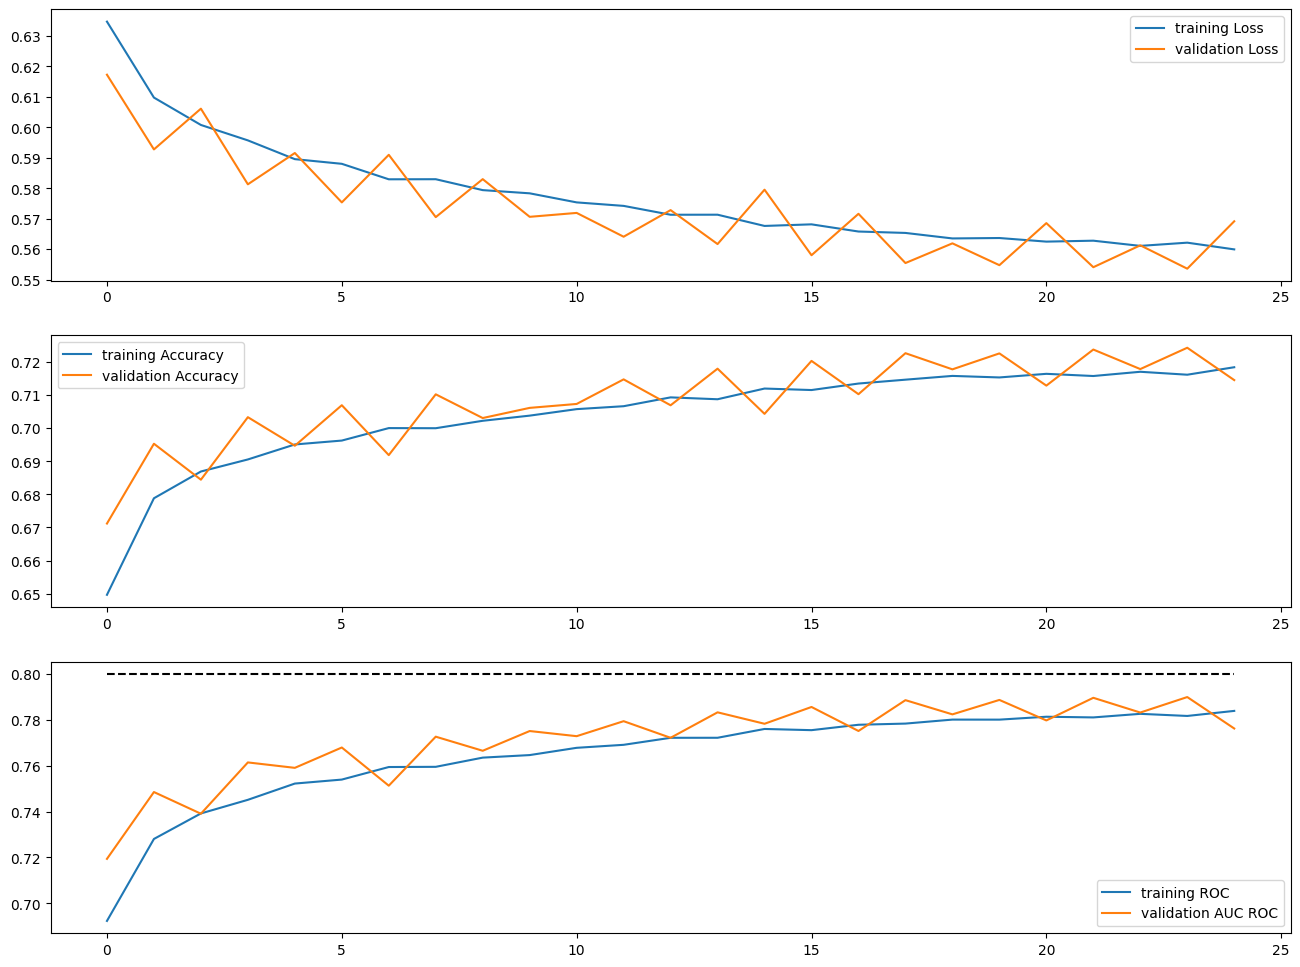

100%|██████████| 779/779 [00:03<00:00, 232.85it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

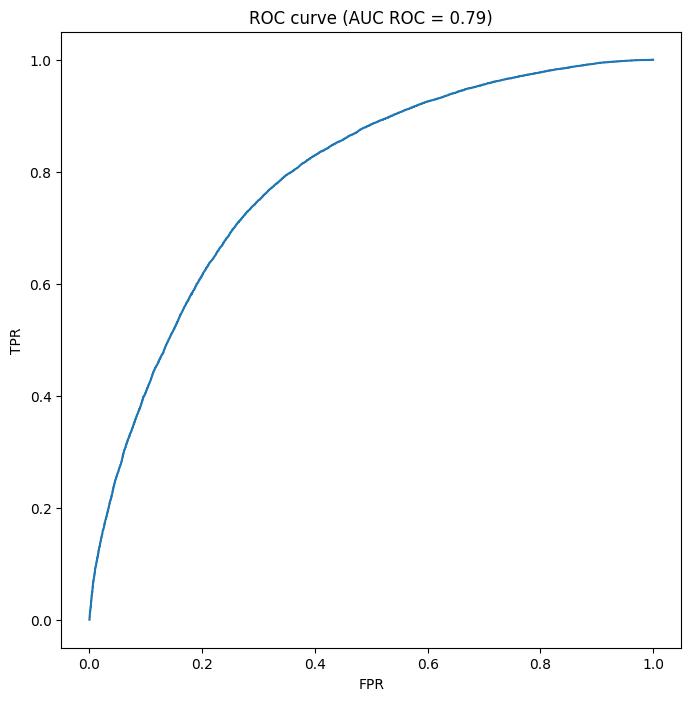

In [ ]:
vit1 = doExperiment(ViT(image_size = 32,
                        patch_size = 16,
                        channels = 2,
                        num_classes = 1,
                        dim = 128,
                        depth = 2,
                        heads = 16,
                        mlp_dim = 2048,
                        dropout = 0.1,
                        emb_dropout = 0.1), 
                        learning_rate=2.5e-4,
                        input_size=(2,32,32),
                        clean_every=500,
                        epochs=25,
                        nameOfModel="ViT_1_AUC={}.pth")


#### Experiment 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 4, 512]               0
         LayerNorm-2               [-1, 4, 512]           1,024
            Linear-3               [-1, 4, 128]          65,664
         LayerNorm-4               [-1, 4, 128]             256
           Dropout-5               [-1, 4, 128]               0
         LayerNorm-6               [-1, 4, 128]             256
            Linear-7              [-1, 4, 3072]         393,216
           Softmax-8             [-1, 16, 4, 4]               0
           Dropout-9             [-1, 16, 4, 4]               0
           Linear-10               [-1, 4, 128]         131,200
          Dropout-11               [-1, 4, 128]               0
        Attention-12               [-1, 4, 128]               0
          PreNorm-13               [-1, 4, 128]               0
        LayerNorm-14               [-1,

loss = 0.6326978058389255, accuracy : 0.6505959630012512, AUC ROC 0.6959122866562344: 100%|██████████| 7004/7004 [03:05<00:00, 37.66it/s]


TRAINING ; Loss: 0.6327 Acc: 0.6506 AUC ROC : 0.6959 Time taken : 186.19


100%|██████████| 779/779 [00:02<00:00, 265.64it/s]


VALIDATION : Loss: 0.6144 Acc: 0.6779 AUC ROC : 0.7252 Time taken : 2.96
Epoch 1/24
----------


loss = 0.6067814430126122, accuracy : 0.6819642782211304, AUC ROC 0.7318397236014699: 100%|██████████| 7004/7004 [03:04<00:00, 38.01it/s]


TRAINING ; Loss: 0.6068 Acc: 0.6819 AUC ROC : 0.7318 Time taken : 184.68


100%|██████████| 779/779 [00:02<00:00, 285.76it/s]


VALIDATION : Loss: 0.5928 Acc: 0.6961 AUC ROC : 0.7480 Time taken : 2.75
Epoch 2/24
----------


loss = 0.5995117120998247, accuracy : 0.6882388591766357, AUC ROC 0.7406938305365114: 100%|██████████| 7004/7004 [03:04<00:00, 38.04it/s]


TRAINING ; Loss: 0.5995 Acc: 0.6882 AUC ROC : 0.7407 Time taken : 184.51


100%|██████████| 779/779 [00:02<00:00, 260.84it/s]


VALIDATION : Loss: 0.5993 Acc: 0.6906 AUC ROC : 0.7410 Time taken : 3.02
Epoch 3/24
----------


loss = 0.5964213775396348, accuracy : 0.6904776692390442, AUC ROC 0.7442689723109601: 100%|██████████| 7004/7004 [03:03<00:00, 38.15it/s]


TRAINING ; Loss: 0.5964 Acc: 0.6905 AUC ROC : 0.7443 Time taken : 184.05


100%|██████████| 779/779 [00:02<00:00, 285.34it/s]


VALIDATION : Loss: 0.5838 Acc: 0.7022 AUC ROC : 0.7585 Time taken : 2.75
Epoch 4/24
----------


loss = 0.5903982322216034, accuracy : 0.6946093440055847, AUC ROC 0.7512351090910243: 100%|██████████| 7004/7004 [03:05<00:00, 37.80it/s]


TRAINING ; Loss: 0.5904 Acc: 0.6946 AUC ROC : 0.7512 Time taken : 185.68


100%|██████████| 779/779 [00:02<00:00, 266.81it/s]


VALIDATION : Loss: 0.5883 Acc: 0.6990 AUC ROC : 0.7542 Time taken : 2.94
Epoch 5/24
----------


loss = 0.587950299258743, accuracy : 0.696196436882019, AUC ROC 0.7542198024346928: 100%|██████████| 7004/7004 [03:00<00:00, 38.87it/s]


TRAINING ; Loss: 0.5880 Acc: 0.6962 AUC ROC : 0.7542 Time taken : 180.63


100%|██████████| 779/779 [00:02<00:00, 291.59it/s]


VALIDATION : Loss: 0.5765 Acc: 0.7050 AUC ROC : 0.7668 Time taken : 2.69
Epoch 6/24
----------


loss = 0.5838132136762142, accuracy : 0.6993705034255981, AUC ROC 0.7586077428444913: 100%|██████████| 7004/7004 [03:05<00:00, 37.76it/s]


TRAINING ; Loss: 0.5838 Acc: 0.6994 AUC ROC : 0.7586 Time taken : 185.94


100%|██████████| 779/779 [00:02<00:00, 273.98it/s]


VALIDATION : Loss: 0.5835 Acc: 0.6985 AUC ROC : 0.7596 Time taken : 2.87
Epoch 7/24
----------


loss = 0.5836841856241226, accuracy : 0.6999553442001343, AUC ROC 0.7588237160941727: 100%|██████████| 7004/7004 [03:04<00:00, 37.95it/s]


TRAINING ; Loss: 0.5837 Acc: 0.6999 AUC ROC : 0.7588 Time taken : 184.98


100%|██████████| 779/779 [00:02<00:00, 271.94it/s]


VALIDATION : Loss: 0.5735 Acc: 0.7077 AUC ROC : 0.7702 Time taken : 2.89
Epoch 8/24
----------


loss = 0.5790790005709444, accuracy : 0.7030022144317627, AUC ROC 0.763834014019131: 100%|██████████| 7004/7004 [03:07<00:00, 37.35it/s]


TRAINING ; Loss: 0.5791 Acc: 0.7030 AUC ROC : 0.7638 Time taken : 187.92


100%|██████████| 779/779 [00:02<00:00, 273.24it/s]


VALIDATION : Loss: 0.5728 Acc: 0.7085 AUC ROC : 0.7709 Time taken : 2.88
Epoch 9/24
----------


loss = 0.5765857570980276, accuracy : 0.7044464349746704, AUC ROC 0.7665373347411292: 100%|██████████| 7004/7004 [02:58<00:00, 39.23it/s]


TRAINING ; Loss: 0.5766 Acc: 0.7045 AUC ROC : 0.7665 Time taken : 178.97


100%|██████████| 779/779 [00:02<00:00, 296.02it/s]


VALIDATION : Loss: 0.5654 Acc: 0.7146 AUC ROC : 0.7781 Time taken : 2.66
Epoch 10/24
----------


loss = 0.5726156608206885, accuracy : 0.708051323890686, AUC ROC 0.7706825986527424: 100%|██████████| 7004/7004 [03:04<00:00, 38.05it/s]


TRAINING ; Loss: 0.5726 Acc: 0.7080 AUC ROC : 0.7707 Time taken : 184.48


100%|██████████| 779/779 [00:02<00:00, 284.90it/s]


VALIDATION : Loss: 0.5664 Acc: 0.7134 AUC ROC : 0.7769 Time taken : 2.76
Epoch 11/24
----------


loss = 0.5714445506036282, accuracy : 0.709359347820282, AUC ROC 0.7720634001186427: 100%|██████████| 7004/7004 [03:06<00:00, 37.65it/s]


TRAINING ; Loss: 0.5715 Acc: 0.7094 AUC ROC : 0.7721 Time taken : 186.47


100%|██████████| 779/779 [00:02<00:00, 279.70it/s]


VALIDATION : Loss: 0.5609 Acc: 0.7192 AUC ROC : 0.7829 Time taken : 2.81
Epoch 12/24
----------


loss = 0.5690824211495263, accuracy : 0.7111093401908875, AUC ROC 0.7745778339061101: 100%|██████████| 7004/7004 [02:59<00:00, 38.94it/s]


TRAINING ; Loss: 0.5691 Acc: 0.7111 AUC ROC : 0.7746 Time taken : 180.28


100%|██████████| 779/779 [00:02<00:00, 291.49it/s]


VALIDATION : Loss: 0.5704 Acc: 0.7133 AUC ROC : 0.7797 Time taken : 2.7
Epoch 13/24
----------


loss = 0.569460008003882, accuracy : 0.7114285826683044, AUC ROC 0.774217243411923: 100%|██████████| 7004/7004 [03:03<00:00, 38.12it/s]


TRAINING ; Loss: 0.5695 Acc: 0.7114 AUC ROC : 0.7742 Time taken : 184.14


100%|██████████| 779/779 [00:02<00:00, 261.07it/s]


VALIDATION : Loss: 0.5620 Acc: 0.7190 AUC ROC : 0.7839 Time taken : 3.01
Epoch 14/24
----------


loss = 0.5672318254368646, accuracy : 0.7124330401420593, AUC ROC 0.7763125427676143: 100%|██████████| 7004/7004 [03:10<00:00, 36.79it/s]


TRAINING ; Loss: 0.5672 Acc: 0.7124 AUC ROC : 0.7763 Time taken : 190.82


100%|██████████| 779/779 [00:02<00:00, 266.19it/s]


VALIDATION : Loss: 0.5680 Acc: 0.7133 AUC ROC : 0.7773 Time taken : 2.95
Epoch 15/24
----------


loss = 0.5682973839427744, accuracy : 0.7109397053718567, AUC ROC 0.7754295946423673: 100%|██████████| 7004/7004 [03:08<00:00, 37.16it/s]


TRAINING ; Loss: 0.5683 Acc: 0.7109 AUC ROC : 0.7754 Time taken : 188.94


100%|██████████| 779/779 [00:02<00:00, 280.93it/s]


VALIDATION : Loss: 0.5578 Acc: 0.7209 AUC ROC : 0.7859 Time taken : 2.8
Epoch 16/24
----------


loss = 0.5657828407883644, accuracy : 0.713129460811615, AUC ROC 0.7779176105233172: 100%|██████████| 7004/7004 [03:08<00:00, 37.13it/s]


TRAINING ; Loss: 0.5658 Acc: 0.7132 AUC ROC : 0.7779 Time taken : 189.04


100%|██████████| 779/779 [00:02<00:00, 280.32it/s]


VALIDATION : Loss: 0.5735 Acc: 0.7079 AUC ROC : 0.7746 Time taken : 2.81
Epoch 17/24
----------


loss = 0.5658734536979879, accuracy : 0.7138325572013855, AUC ROC 0.7779454979131162: 100%|██████████| 7004/7004 [03:08<00:00, 37.06it/s]


TRAINING ; Loss: 0.5659 Acc: 0.7138 AUC ROC : 0.7779 Time taken : 189.41


100%|██████████| 779/779 [00:02<00:00, 276.21it/s]


VALIDATION : Loss: 0.5569 Acc: 0.7224 AUC ROC : 0.7863 Time taken : 2.85
Epoch 18/24
----------


loss = 0.5644306580381734, accuracy : 0.7151584625244141, AUC ROC 0.7793515441756348: 100%|██████████| 7004/7004 [03:08<00:00, 37.11it/s]


TRAINING ; Loss: 0.5644 Acc: 0.7151 AUC ROC : 0.7793 Time taken : 189.18


100%|██████████| 779/779 [00:02<00:00, 277.82it/s]


VALIDATION : Loss: 0.5700 Acc: 0.7178 AUC ROC : 0.7776 Time taken : 2.83
Epoch 19/24
----------


loss = 0.5642265994378498, accuracy : 0.7145647406578064, AUC ROC 0.779560944991468: 100%|██████████| 7004/7004 [03:07<00:00, 37.29it/s]


TRAINING ; Loss: 0.5642 Acc: 0.7146 AUC ROC : 0.7796 Time taken : 188.21


100%|██████████| 779/779 [00:03<00:00, 253.12it/s]


VALIDATION : Loss: 0.5556 Acc: 0.7224 AUC ROC : 0.7877 Time taken : 3.11
Epoch 20/24
----------


loss = 0.5627890558668546, accuracy : 0.7155826091766357, AUC ROC 0.7809311805145888: 100%|██████████| 7004/7004 [03:06<00:00, 37.50it/s]


TRAINING ; Loss: 0.5628 Acc: 0.7156 AUC ROC : 0.7809 Time taken : 187.21


100%|██████████| 779/779 [00:02<00:00, 276.54it/s]


VALIDATION : Loss: 0.5630 Acc: 0.7174 AUC ROC : 0.7812 Time taken : 2.84
Epoch 21/24
----------


loss = 0.5634754089244774, accuracy : 0.7160401940345764, AUC ROC 0.7802516925163502: 100%|██████████| 7004/7004 [03:08<00:00, 37.25it/s]


TRAINING ; Loss: 0.5635 Acc: 0.7160 AUC ROC : 0.7802 Time taken : 188.45


100%|██████████| 779/779 [00:02<00:00, 275.18it/s]


VALIDATION : Loss: 0.5557 Acc: 0.7226 AUC ROC : 0.7883 Time taken : 2.86
Epoch 22/24
----------


loss = 0.5613464424226965, accuracy : 0.7173593640327454, AUC ROC 0.782313621669073: 100%|██████████| 7004/7004 [03:08<00:00, 37.08it/s]


TRAINING ; Loss: 0.5613 Acc: 0.7174 AUC ROC : 0.7823 Time taken : 189.29


100%|██████████| 779/779 [00:02<00:00, 270.46it/s]


VALIDATION : Loss: 0.5594 Acc: 0.7183 AUC ROC : 0.7847 Time taken : 2.91
Epoch 23/24
----------


loss = 0.56224854690688, accuracy : 0.7159509062767029, AUC ROC 0.7814400117544354: 100%|██████████| 7004/7004 [03:09<00:00, 37.03it/s]


TRAINING ; Loss: 0.5622 Acc: 0.7160 AUC ROC : 0.7815 Time taken : 189.59


100%|██████████| 779/779 [00:02<00:00, 264.55it/s]


VALIDATION : Loss: 0.5548 Acc: 0.7239 AUC ROC : 0.7884 Time taken : 2.97
Epoch 24/24
----------


loss = 0.5601870108800275, accuracy : 0.7177075743675232, AUC ROC 0.7835121740729336: 100%|██████████| 7004/7004 [03:03<00:00, 38.14it/s]


TRAINING ; Loss: 0.5602 Acc: 0.7177 AUC ROC : 0.7835 Time taken : 184.04


100%|██████████| 779/779 [00:02<00:00, 292.46it/s]


VALIDATION : Loss: 0.5616 Acc: 0.7195 AUC ROC : 0.7831 Time taken : 2.69
Training complete in 78m 44s


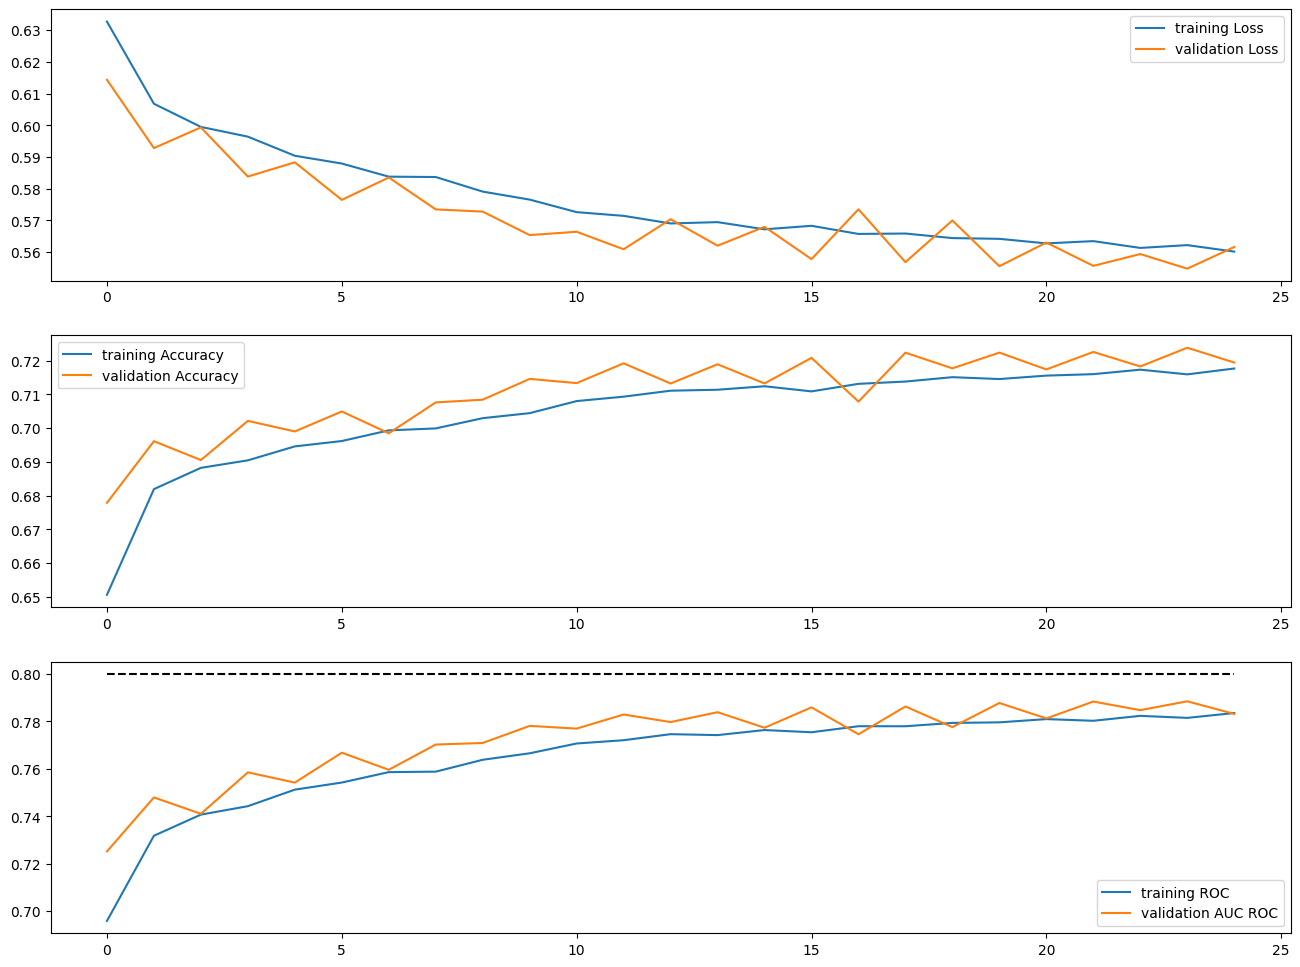

100%|██████████| 779/779 [00:02<00:00, 297.74it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(arra

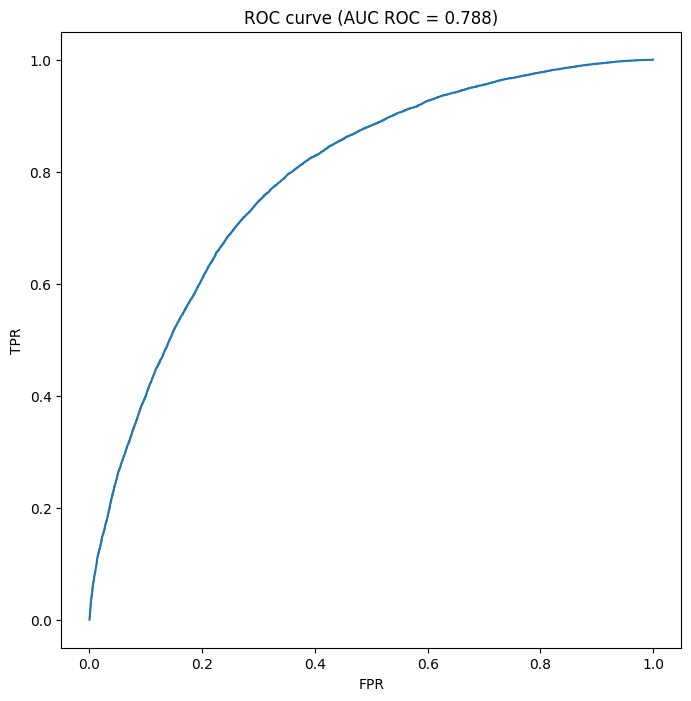

In [ ]:
vit1 = doExperiment(ViT(image_size = 32,
                        patch_size = 16,
                        channels = 2,
                        num_classes = 1,
                        dim = 128,
                        depth = 1,
                        heads = 16,
                        mlp_dim = 2048,
                        dropout = 0.1,
                        emb_dropout = 0.1), 
                        learning_rate=2.5e-4,
                        input_size=(2,32,32),
                        clean_every=500,
                        epochs=25,
                        nameOfModel="ViT_1_AUC={}.pth")
